In [2]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [62]:
# read dataset
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# restructure labor columnss
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower()
)
df_labor[['CountyName', 'State']] = df[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower()
)

In [73]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])

# remove rows with unemployment > 4.5%
print(df[df.Unemployment < 4.5])

        RegionID  RegionName              City State  \
0          84654       60657           chicago    il   
1          84654       60657           chicago    il   
2          84654       60657           chicago    il   
3          84654       60657           chicago    il   
5          84654       60657           chicago    il   
9          84654       60657           chicago    il   
11         84654       60657           chicago    il   
12         84654       60657           chicago    il   
13         84654       60657           chicago    il   
14         84654       60657           chicago    il   
17         84654       60657           chicago    il   
18         84654       60657           chicago    il   
19         84654       60657           chicago    il   
20         84654       60657           chicago    il   
21         84654       60657           chicago    il   
23         84654       60657           chicago    il   
25         84654       60657           chicago  

In [4]:
# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

In [5]:
# metro areas
hot_springs = df.loc[(df['Metro'] == 'hot springs') & (df['State'] == 'ar')]
little_rock = df.loc[(df['Metro'] == 'little rock') & (df['State'] == 'ar')]
fayetteville = df.loc[(df['Metro'] == 'fayetteville') & (df['State'] == 'ar')]
searcy = df.loc[(df['Metro'] == 'searcy') & (df['State'] == 'ar')]

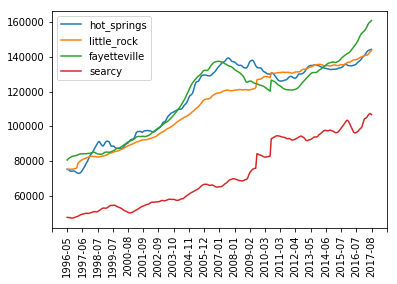

In [6]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [7]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [8]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [9]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [10]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1897.950
Method:                       css-mle   S.D. of innovations            677.352
Date:                Sat, 17 Nov 2018   AIC                           3809.901
Time:                        14:43:31   BIC                           3834.236
Sample:                    02-01-1997   HQIC                          3819.707
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        790.4705    688.262      1.149      0.252    -558.499    2139.440
ar.L1.D.y      0.3906      0.065      6.046      0.000       0.264       0.517
ar.L2.D.y      0.1321      0.068      1.943      0.0

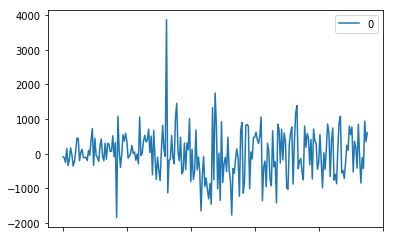

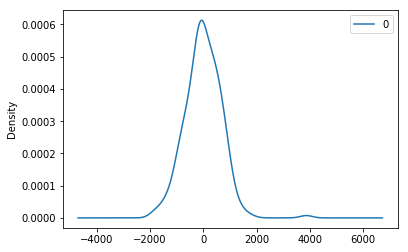

In [11]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [12]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean      2.044148
std     678.828434
min   -1839.800599
25%    -428.541806
50%     -20.754053
75%     440.493914
max    3867.851117


In [13]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=287857.603196, expected=287100.000000
prediction difference: 0.002639

predicted=287857.603196

date: 2017-3
-----------------------------------------------
predicted=289470.754665, expected=288000.000000
prediction difference: 0.005107

predicted=289470.754665

date: 2017-4
-----------------------------------------------
predicted=291093.245235, expected=288800.000000
prediction difference: 0.007941

predicted=291093.245235

date: 2017-5
-----------------------------------------------
predicted=292709.231553, expected=289500.000000
prediction difference: 0.011085

predicted=292709.231553

date: 2017-6
-----------------------------------------------
predicted=294276.612811, expected=291100.000000
prediction difference: 0.010912

predicted=294276.612811

date: 2017-7
-----------------------------------------------
predicted=295827.288992, expected=292000.000000
prediction difference: 0.013107

predicted=295827.28899

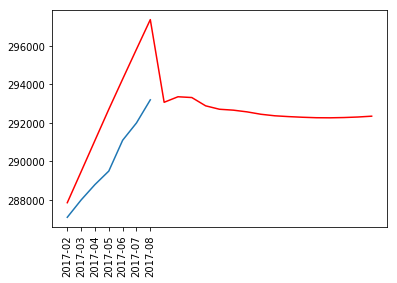

In [14]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [84]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

def compute_arima(df_train):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()
    iterations = (12-len(df_test)) + 18

    for t in range(iterations):
        #
        # determine stationarity value: no need to difference more than
        #     half the lenght of the given series.
        #
        # @delta, the difference factor.
        #
        for delta in range(int(len(history) / 2)):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            autoreg = delta
            print('delta: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use dickey-fuller significance test using
            #     custom 'difference' function. Sometimes, statsmodels
            #     arima algorithm will not agree with our pvalue, so it
            #     is forced to search for another significant difference.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(history, order=(autoreg, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('stationarity not adequate')
                    continue

        output = model_fit.forecast()
        yhat = output[0]

        #
        # observation: if current value doesn't exist from test, append current
        #     predition, to ensure successive rolling prediction computed.
        #
        try:
            obs = df_test[t]
        except:
            obs = yhat
        history.append(obs)
        
        predictions.append(yhat)
        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [56]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

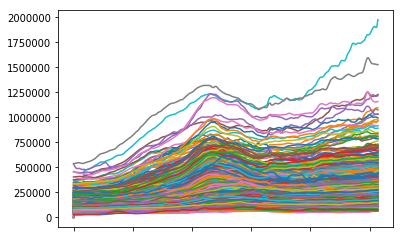

In [57]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [ ]:
## iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


delta: 0, p: nan
delta: 1, p: 0.3187671291031393
delta: 2, p: 0.03475181412401332
predictions: [array([225003.43430598])]
delta: 0, p: nan
delta: 1, p: 0.8726774466975695
delta: 2, p: 0.8482630143016459
delta: 3, p: 0.8666277195058221
delta: 4, p: 0.0
stationarity not adequate
delta: 5, p: 5.099275513103941e-12
stationarity not adequate
delta: 6, p: 2.277322663256925e-09
stationarity not adequate
delta: 7, p: 1.2566473486286529e-07
stationarity not adequate
delta: 8, p: 2.0824250101106382e-06
stationarity not adequate
delta: 9, p: 1.8046025333810255e-05
stationarity not adequate
delta: 10, p: 4.508178507277881e-05
stationarity not adequate
delta: 11, p: 0.0002094230192185614
stationarity not adequate
delta: 12, p: 0.00011687808927066568
stationarity not adequate
delta: 13, p: 0.0022274262662381216
stationarity not adequate
delta: 14, p: 0.004389279472040944
stationarity not adequate
delta: 15, p: 0.007252150409832875
stationarity not adequate
delta: 16, p: 0.013318003214428834
stationa

delta: 92, p: 0.5734510976354932
delta: 93, p: 0.56723190033733
delta: 94, p: 0.5651522633960683
delta: 95, p: 0.570381694102521
delta: 96, p: 0.5763732341100855
delta: 97, p: 0.5778658374006139
delta: 98, p: 0.5854492051108192
delta: 99, p: 0.5976232633839526
delta: 100, p: 0.6045165925514947
delta: 101, p: 0.6060719823176749
delta: 102, p: 0.6094064351679129
delta: 103, p: 0.6115984620601017
delta: 104, p: 0.6104663508542025
delta: 105, p: 0.6055525929926366
delta: 106, p: 0.5975698368359057
delta: 107, p: 0.5867121806495776
delta: 108, p: 0.5728344108291334
delta: 109, p: 0.5569252049761192
delta: 110, p: 0.5410936505463345
delta: 111, p: 0.5279803528795133
delta: 112, p: 0.5184347365487632
delta: 113, p: 0.5110806555787686
delta: 114, p: 0.5072059866939677
delta: 115, p: 0.5041039504871552
delta: 116, p: 0.4978951105705269
delta: 117, p: 0.4892355929074735
delta: 118, p: 0.47875774571397217
delta: 119, p: 0.46466785755469875
delta: 120, p: 0.45501285671202074
delta: 121, p: 0.44951

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less_equal


delta: 0, p: [nan]
delta: 1, p: [9.77173087e-28]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157])]
delta: 0, p: [nan]
delta: 1, p: [1.02332308e-27]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473])]
delta: 0, p: [nan]
delta: 1, p: [1.08190105e-27]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923])]
delta: 0, p: [nan]
delta: 1, p: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27890654]), array([329826.26040603]), array([334843.68227114])]
delta: 0, p: [nan]
delta: 1, p: [1.75347078e-27]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27890654]), array([329826.26040603]), array([334843.68227114]), array([339930.62082807])]
delta: 0, p: [nan]
delta: 1, p: [1.93503478e-27]
predictions: [arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27890654]), array([329826.26040603]), array([334843.68227114]), array([339930.62082807]), array([345081.39445411]), array([350290.7456342]), array([355553.96169372]), array([360867.15605772]), array([366226.47841691])]
delta: 0, p: [nan]
delta: 1, p: [2.45079158e-17]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27

delta: 1, p: [1.9574941e-26]
predictions: [array([343970.13104049]), array([206273.30557523]), array([285796.28053844]), array([285727.28113359]), array([287774.84103415]), array([290650.50514003]), array([290718.0101298]), array([292739.89738885]), array([292076.58917942]), array([291367.09294251]), array([290641.35117137]), array([289904.84889955]), array([289158.62804572]), array([288402.79570931]), array([287637.52747508]), array([286862.75634483]), array([286078.49445959]), array([285284.74186286]), array([284481.46377921]), array([283668.68688532]), array([282846.46652731])]
delta: 0, p: [nan]
delta: 1, p: [1.80981974e-26]
predictions: [array([343970.13104049]), array([206273.30557523]), array([285796.28053844]), array([285727.28113359]), array([287774.84103415]), array([290650.50514003]), array([290718.0101298]), array([292739.89738885]), array([292076.58917942]), array([291367.09294251]), array([290641.35117137]), array([289904.84889955]), array([289158.62804572]), array([28840

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 7, p: 2.5511668502961933e-21
stationarity not adequate
delta: 8, p: 0.3947710088471218
delta: 9, p: 0.9214037380132087
delta: 10, p: 7.981291691245812e-06
stationarity not adequate
delta: 11, p: 0.0002272125153324358
stationarity not adequate
delta: 12, p: 0.0006220357926967157
stationarity not adequate
delta: 13, p: 0.0005581935461887427
stationarity not adequate
delta: 14, p: 0.0023387048675648256
stationarity not adequate
delta: 15, p: 0.0038672945471281465
stationarity not adequate
delta: 16, p: 0.0013161846445348948
stationarity not adequate
delta: 17, p: 0.0034798334639985352
stationarity not adequate
delta: 18, p: 0.010280938735711181
stationarity not adequate
delta: 19, p: 0.012647008740252931
stationarity not adequate
delta: 20, p: 0.01548901913148613
stationarity not adequate
delta: 21, p: 0.01899991172775453
stationarity not adequate
delta: 22, p: 0.023612919413055197
stationarity not adequate
delta: 23, p: 0.028721656223064055
stationarity n

delta: 0, p: [nan]
delta: 1, p: [3.25961832e-27]
predictions: [array([225417.97892642]), array([365366.00081415]), array([365366.00081415]), array([295617.85006706]), array([292719.86770199]), array([294082.51295189]), array([294634.91417621]), array([295674.24730653]), array([298249.80869586]), array([300849.72173987]), array([303460.74883987]), array([306080.22034928]), array([308707.75866946]), array([311343.50596548]), array([313987.30401434]), array([316639.23444194])]
delta: 0, p: [nan]
delta: 1, p: [3.07926444e-27]
predictions: [array([225417.97892642]), array([365366.00081415]), array([365366.00081415]), array([295617.85006706]), array([292719.86770199]), array([294082.51295189]), array([294634.91417621]), array([295674.24730653]), array([298249.80869586]), array([300849.72173987]), array([303460.74883987]), array([306080.22034928]), array([308707.75866946]), array([311343.50596548]), array([313987.30401434]), array([316639.23444194]), array([319299.47602644])]
delta: 0, p: [na

delta: 92, p: 0.5756569292829332
delta: 93, p: 0.5770949634178321
delta: 94, p: 0.5785779813015971
delta: 95, p: 0.5736923845898816
delta: 96, p: 0.5793894880242859
delta: 97, p: 0.5936663069020449
delta: 98, p: 0.5954611782017989
delta: 99, p: 0.5888774432756598
delta: 100, p: 0.5854022831891045
delta: 101, p: 0.5777750486608046
delta: 102, p: 0.566721390085183
delta: 103, p: 0.5593897245922903
delta: 104, p: 0.553582034092851
delta: 105, p: 0.5448288059857557
delta: 106, p: 0.5340494797239365
delta: 107, p: 0.5219267700877444
delta: 108, p: 0.5084654660566338
delta: 109, p: 0.5001831528174114
delta: 110, p: 0.5027737540670654
delta: 111, p: 0.509215991238481
delta: 112, p: 0.511242207362386
delta: 113, p: 0.508597814300463
delta: 114, p: 0.5059554631310351
delta: 115, p: 0.5020065482519795
delta: 116, p: 0.49654934293750747
delta: 117, p: 0.48629619931718837
delta: 118, p: 0.47366440155686296
delta: 119, p: 0.466015547267508
delta: 120, p: 0.4631858525894154
delta: 121, p: 0.45983691

delta: 1, p: [2.71597533e-14]
predictions: [array([248232.91436964]), array([248232.91436964]), array([248232.91436964]), array([294393.99321414]), array([293114.56796507]), array([294423.54262835]), array([294904.45450977]), array([295906.45938398]), array([298772.81676447]), array([301682.0360041]), array([304607.38441323]), array([307543.06046862])]
delta: 0, p: [nan]
delta: 1, p: [2.79647101e-14]
predictions: [array([248232.91436964]), array([248232.91436964]), array([248232.91436964]), array([294393.99321414]), array([293114.56796507]), array([294423.54262835]), array([294904.45450977]), array([295906.45938398]), array([298772.81676447]), array([301682.0360041]), array([304607.38441323]), array([307543.06046862]), array([310487.54000505])]
delta: 0, p: [nan]
delta: 1, p: [2.8781411e-14]
predictions: [array([248232.91436964]), array([248232.91436964]), array([248232.91436964]), array([294393.99321414]), array([293114.56796507]), array([294423.54262835]), array([294904.45450977]), a

delta: 42, p: 0.34407418027712644
delta: 43, p: 0.33651075326327784
delta: 44, p: 0.3276532807953325
delta: 45, p: 0.3270813894830123
delta: 46, p: 0.3397206579302128
delta: 47, p: 0.36811895238831815
delta: 48, p: 0.4025729388383264
delta: 49, p: 0.433059376490953
delta: 50, p: 0.46120633902467656
delta: 51, p: 0.4893319154656562
delta: 52, p: 0.5203315848991257
delta: 53, p: 0.5536117098586866
delta: 54, p: 0.5870093484064266
delta: 55, p: 0.6119078354894459
delta: 56, p: 0.6358537597763504
delta: 57, p: 0.66342767287137
delta: 58, p: 0.6884505715850432
delta: 59, p: 0.6999572417711887
delta: 60, p: 0.7051878086002668
delta: 61, p: 0.7137720341339955
delta: 62, p: 0.722838158643424
delta: 63, p: 0.7218633127684893
delta: 64, p: 0.7142629531430368
delta: 65, p: 0.7119024289971015
delta: 66, p: 0.713900889919297
delta: 67, p: 0.7094551711277473
delta: 68, p: 0.6984094104030554
delta: 69, p: 0.6847016446574401
delta: 70, p: 0.6677895405606803
delta: 71, p: 0.6501197563450651
delta: 72, 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 4, p: 2.310496451860288e-27
stationarity not adequate
delta: 5, p: 0.4572553084263761
delta: 6, p: 1.1323229535004292e-14
stationarity not adequate
delta: 7, p: 5.3350016538055926e-11
stationarity not adequate
delta: 8, p: 0.0011691316143627238
stationarity not adequate
delta: 9, p: 0.0020130710047813515
stationarity not adequate
delta: 10, p: 0.003224606223995113
stationarity not adequate
delta: 11, p: 0.004979425721823932
stationarity not adequate
delta: 12, p: 0.007128412012233976
stationarity not adequate
delta: 13, p: 0.009881962682545927
stationarity not adequate
delta: 14, p: 0.013180981043392012
stationarity not adequate
delta: 15, p: 0.0003783754078167861
stationarity not adequate
delta: 16, p: 0.0016402932952868223
stationarity not adequate
delta: 17, p: 0.004811336122113919
stationarity not adequate
delta: 18, p: 0.030844486870671848
stationarity not adequate
delta: 19, p: 0.03938007443626396
stationarity not adequate
delta: 20, p: 0.04868983

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707])]
delta: 0, p: nan
delta: 1, p: 3.0946709242121487e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866])]
delta: 0, p: nan
delta: 1, p: 2.838582851562157e-28
stationarity not adequate
delta: 2, p: 0.7415213002497155
delta: 3, p: 0.19414068971794723
delta: 4, p: 1.0047324303125208e-13
predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923])]
delta: 0, p: nan
delta: 1, p: 2.609237417613617e-28
predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402])]
delta: 0, p: [nan]
delta: 1, p: [2.40992839e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611])]
delta: 0, p: [nan]
delta: 1, p: [2.22431294e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075])]
delta: 0, p: [nan]
delta: 1, p: [2.05524082e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706])]
delta: 0, p: [nan]
delta: 1, p: [1.9004513e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524])]
delta: 0, p: [nan]
delta: 1, p: [1.75889232e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789])]
delta: 0, p: [nan]
delta: 1, p: [1.62917166e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477])]
delta: 0, p: [nan]
delta: 1, p: [1.51026414e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338])]
delta: 0, p: [nan]
delta: 1, p: [1.40116014e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951])]
delta: 0, p: [nan]
delta: 1, p: [1.30104068e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939])]
delta: 0, p: [nan]
delta: 1, p: [1.2090225e-28]
predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939]), array([313715.15089401])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


delta: 0, p: [nan]
delta: 1, p: [1.12450044e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939]), array([313715.15089401]), array([315594.57316168])]
delta: 0, p: [nan]
delta: 1, p: [1.04658304e-28]
stationarity not adequate


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)


delta: 2, p: [0.00010137]
predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939]), array([313715.15089401]), array([315594.57316168]), array([317482.59385918])]
delta: 0, p: [nan]
delta: 1, p: [9.74841857e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939]), array([313715.15089401]), array([315594.57316168]), array([317482.59385918]), array([319370.28745624])]
delta: 0, p: [nan]
delta: 1, p: [9.08683256e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939]), array([313715.15089401]), array([315594.57316168]), array([317482.59385918]), array([319370.28745624]), array([321272.67590055])]
delta: 0, p: [nan]
delta: 1, p: [8.47713346e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174118.53836778]), array([174118.53836778]), array([357131.7068467]), array([357131.7068467]), array([291307.13723707]), array([292902.66422866]), array([294332.10560923]), array([295323.3736402]), array([297127.51761611]), array([298937.4228075]), array([300744.29640706]), array([302570.33142524]), array([304401.56000789]), array([306242.82166477]), array([308091.48173338]), array([309955.08808951]), array([311824.58418939]), array([313715.15089401]), array([315594.57316168]), array([317482.59385918]), array([319370.28745624]), array([321272.67590055]), array([323169.16359727])]
delta: 0, p: nan
delta: 1, p: 0.38237128536411036
delta: 2, p: 0.08525830312268629
delta: 3, p: 0.3080310661198453
delta: 4, p: 0.2334971597827194
delta: 5, p: 0.04206065523214328
stationarity not adequate
delta: 6, p: 0.20328394097224084
delta: 7, p: 0.15323832815205884
delta: 8, p: 0.02478580049706714
predictions: [array([178189.10643093])]
delta: 0, p: nan
delta: 1, p: 0.966205666416812

delta: 55, p: 0.6507179624537888
delta: 56, p: 0.6550201384976173
delta: 57, p: 0.6576478631951173
delta: 58, p: 0.6618595939383101
delta: 59, p: 0.6670818152253392
delta: 60, p: 0.6731539333886158
delta: 61, p: 0.6797924702943687
delta: 62, p: 0.6863987704459747
delta: 63, p: 0.6901607199583896
delta: 64, p: 0.6925909546938249
delta: 65, p: 0.6937463693406172
delta: 66, p: 0.6923693175276178
delta: 67, p: 0.6910878200457563
delta: 68, p: 0.6928574721564775
delta: 69, p: 0.6936918127307363
delta: 70, p: 0.6921335395565391
delta: 71, p: 0.6904885200424244
delta: 72, p: 0.6901443479161485
delta: 73, p: 0.6894694151616193
delta: 74, p: 0.6868705021801006
delta: 75, p: 0.6843872313890599
delta: 76, p: 0.6833140590966604
delta: 77, p: 0.6804611978183385
delta: 78, p: 0.6784657066182656
delta: 79, p: 0.6781183334386388
delta: 80, p: 0.6740560686286569
delta: 81, p: 0.6690154556130085
delta: 82, p: 0.6679010551802915
delta: 83, p: 0.6654634670247829
delta: 84, p: 0.6604705635107597
delta: 85,

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943])]
delta: 0, p: nan
delta: 1, p: 9.480128384685372e-29
predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876])]
delta: 0, p: nan
delta: 1, p: 8.767173237145063e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752])]
delta: 0, p: nan
delta: 1, p: 8.12525785297282e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752]), array([297202.6133971])]
delta: 0, p: [nan]
delta: 1, p: [7.6944549e-29]
predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752]), array([297202.6133971]), array([300707.18696011])]
delta: 0, p: [nan]
delta: 1, p: [7.30505496e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752]), array([297202.6133971]), array([300707.18696011]), array([304152.17435585])]
delta: 0, p: [nan]
delta: 1, p: [6.93466907e-29]
predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752]), array([297202.6133971]), array([300707.18696011]), array([304152.17435585]), array([307832.34112706])]
delta: 0, p: [nan]
delta: 1, p: [6.61259145e-29]
stationarity not adequate
delta: 2, p: [3.18295902e-07]
stationarity not adequate
delta: 3, p: [0.00097967]
stationarity not adequate
delta: 4, p: [0.00096746]
stationarity not adequate
delta: 5, p: [0.00228539]
stationarity not adequate
delta: 6, p: [0.0007943]
stationarity not adequate
delta: 7, p: [0.00360764]
stationarity not 

delta: 1, p: [4.31495827e-29]
predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752]), array([297202.6133971]), array([300707.18696011]), array([304152.17435585]), array([307832.34112706]), array([307832.34112706]), array([311904.73499688]), array([315407.22562743]), array([319274.76061628]), array([322811.24012132]), array([326695.0783389]), array([330265.52914087]), array([334167.04817758]), array([337771.1024711])]
delta: 0, p: [nan]
delta: 1, p: [4.12208499e-29]
predictions: [array([178189.10643093]), array([434877.47703187]), array([434877.47703187]), array([434877.47703187]), array([301503.5229943]), array([295730.46336876]), array([298467.91056752]), array([297202.6133971]), array([300707.18696011]), array([304152.17435585]), array([307832.34112706]), array([307832.34112706]), array([311904.73499688]), array([315407.22562743]), array([319274.7

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([228824.36823353]), array([370163.08940585])]
delta: 0, p: nan
delta: 1, p: 0.016274211569183922
stationarity not adequate
delta: 2, p: 0.00020349701308050184
stationarity not adequate
delta: 3, p: 0.04180940819581546
stationarity not adequate
delta: 4, p: 0.6279803825940538
delta: 5, p: 0.007978419380366347
stationarity not adequate
delta: 6, p: 0.015743998523330176
stationarity not adequate
delta: 7, p: 1.2820198803238893e-18
stationarity not adequate
delta: 8, p: 0.417693962638878
delta: 9, p: 0.37277803339353416
delta: 10, p: 4.880589756934287e-06
stationarity not adequate
delta: 11, p: 5.163431785796713e-06
stationarity not adequate
delta: 12, p: 0.0003319165006274062
stationarity not adequate
delta: 13, p: 0.0008157370554360996
stationarity not adequate
delta: 14, p: 0.003031820554062244
stationarity not adequate
delta: 15, p: 0.005049016149561679
stationarity not adequate
delta: 16, p: 0.0030795273230437574
stationarity not adequate
delta: 17, p: 0.0040804590

delta: 1, p: [6.41541107e-26]
predictions: [array([228824.36823353]), array([370163.08940585]), array([370163.08940585]), array([292720.78902307]), array([291030.44206361]), array([292340.71752319]), array([292984.99566471]), array([294132.30695222]), array([295001.03283589]), array([295831.46450767]), array([296639.7095691]), array([297435.18362218]), array([298223.40027904]), array([299007.65676982]), array([299789.8678639])]
delta: 0, p: [nan]
delta: 1, p: [5.78619186e-26]
predictions: [array([228824.36823353]), array([370163.08940585]), array([370163.08940585]), array([292720.78902307]), array([291030.44206361]), array([292340.71752319]), array([292984.99566471]), array([294132.30695222]), array([295001.03283589]), array([295831.46450767]), array([296639.7095691]), array([297435.18362218]), array([298223.40027904]), array([299007.65676982]), array([299789.8678639]), array([300571.16489031])]
delta: 0, p: [nan]
delta: 1, p: [5.22199647e-26]
predictions: [array([228824.36823353]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 5, p: 2.1779300437960254e-18
stationarity not adequate
delta: 6, p: 1.8234875174671597e-13
stationarity not adequate
delta: 7, p: 1.3832114527477914e-10
stationarity not adequate
delta: 8, p: 3.600187655253655e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 9, p: 3.8126761807594266e-07
stationarity not adequate
delta: 10, p: 4.975108914352743e-06
stationarity not adequate
delta: 11, p: 3.36140370529635e-05
stationarity not adequate
delta: 12, p: 4.527722638374208e-05
stationarity not adequate
delta: 13, p: 0.0005202332301560789
stationarity not adequate
delta: 14, p: 0.0013572562072254539
stationarity not adequate
delta: 15, p: 0.0028859541614224752
stationarity not adequate
delta: 16, p: 0.0065977532627012935
stationarity not adequate
delta: 17, p: 0.00577129598271081
stationarity not adequate
delta: 18, p: 0.015436862587015347
stationarity not adequate
delta: 19, p: 0.02169630886360259
stationarity not adequate
delta: 20, p: 0.030494616463807876
stationarity not adequate
delta: 21, p: 0.0411488439363843
stationarity not adequate
delta: 22, p: 0.05231079931301854
delta: 23, p: 0.06491821739116227
delta: 24, p: 0.07892680633342863
delta: 25, p: 0.09253809610083424
delta: 26, p: 0.10767242630931673
delta: 2

delta: 107, p: 0.5935559876044054
delta: 108, p: 0.5917297638380273
delta: 109, p: 0.589150929921102
delta: 110, p: 0.5827187521358754
delta: 111, p: 0.575902840723365
delta: 112, p: 0.5702944300193724
delta: 113, p: 0.5663284227547507
delta: 114, p: 0.5611915619971805
delta: 115, p: 0.55740136700854
delta: 116, p: 0.5539211143884952
delta: 117, p: 0.5494346181097959
delta: 118, p: 0.5435482617633086
delta: 119, p: 0.5356988239901452
delta: 120, p: 0.5270907959665687
delta: 121, p: 0.5170220507574078
delta: 122, p: 0.501916316839575
delta: 123, p: 0.4874976401813186
delta: 124, p: 0.48232315947007626
delta: 125, p: 0.482181812037953
delta: 126, p: 0.4837624637629772
delta: 127, p: 0.4879219049838199
delta: 128, p: 0.49044889348720777
delta: 129, p: 0.49084320078749283
predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805])]
delta: 0, p: nan
delta: 1, p: 3.983091840741992e-27
predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.53

delta: 0, p: [nan]
delta: 1, p: [1.84780755e-27]
predictions: [array([237935.5319805]), array([237935.5319805]), array([237935.5319805]), array([293322.87711442]), array([293161.29793247]), array([294194.60424949]), array([294818.63031479]), array([295885.59621868]), array([298619.72333164]), array([301354.83765612]), array([304101.58108438]), array([306857.75375346]), array([309623.77325987]), array([312399.58727753]), array([315185.20681398]), array([317980.76563349]), array([320786.22460611]), array([323601.49253685]), array([326426.68654561]), array([329261.69978849]), array([332106.66368116]), array([334961.51022054]), array([337826.31420704])]
delta: 0, p: nan
delta: 1, p: 0.5033627460401652
delta: 2, p: 0.5562490105305071
delta: 3, p: 0.32201750522977246
delta: 4, p: 0.27739819583020064
delta: 5, p: 0.1206128127166115
delta: 6, p: 0.20897020986154008
delta: 7, p: 0.06626164219700578
delta: 8, p: 0.19344313316332695
delta: 9, p: 1.0454389276501617e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([242267.98595367])]
delta: 0, p: nan
delta: 1, p: 0.9456247765338132
delta: 2, p: 0.716901169547106
delta: 3, p: 0.9160701008348877
delta: 4, p: 0.0
predictions: [array([242267.98595367]), array([352621.32577345])]
delta: 0, p: nan
delta: 1, p: 0.5059128687712002
delta: 2, p: 0.9080238053935334
delta: 3, p: 0.25112134703886535
delta: 4, p: 0.9214293690492124
delta: 5, p: 0.6948299830184997
delta: 6, p: 0.4942190231969301
delta: 7, p: 3.216966869583867e-21
stationarity not adequate
delta: 8, p: 8.082370785655982e-07
stationarity not adequate
delta: 9, p: 8.673690207947043e-06
stationarity not adequate
delta: 10, p: 4.9489340347768e-05
stationarity not adequate
delta: 11, p: 3.413730821138702e-05
stationarity not adequate
delta: 12, p: 0.0003184828267066118
stationarity not adequate
delta: 13, p: 0.0005655824463148061
stationarity not adequate
delta: 14, p: 0.002138774873695763
stationarity not adequate
delta: 15, p: 0.005702265284495546
stationarity not adequate
delt

delta: 82, p: 0.590351004515892
delta: 83, p: 0.5975699411111224
delta: 84, p: 0.598796151411952
delta: 85, p: 0.5984976881134227
delta: 86, p: 0.601420251855785
delta: 87, p: 0.6063303232847704
delta: 88, p: 0.6054757063828127
delta: 89, p: 0.5987714615920088
delta: 90, p: 0.5936559111246418
delta: 91, p: 0.5866735782249368
delta: 92, p: 0.5798333172837061
delta: 93, p: 0.5726361804350241
delta: 94, p: 0.562013176105618
delta: 95, p: 0.5525542595935042
delta: 96, p: 0.5487342612999698
delta: 97, p: 0.5495091025437941
delta: 98, p: 0.5471517500685755
delta: 99, p: 0.5397956582649444
delta: 100, p: 0.5420630223751867
delta: 101, p: 0.5544940656589296
delta: 102, p: 0.563354046529968
delta: 103, p: 0.5677317921987626
delta: 104, p: 0.5713257719188634
delta: 105, p: 0.5720211544159557
delta: 106, p: 0.5706604208806152
delta: 107, p: 0.566844406342577
delta: 108, p: 0.5609753297398347
delta: 109, p: 0.5523070654279981
delta: 110, p: 0.541128648288109
delta: 111, p: 0.5257233853185426
delta

delta: 0, p: [nan]
delta: 1, p: [1.05791788e-15]
predictions: [array([242267.98595367]), array([352621.32577345]), array([352621.32577345]), array([352621.32577345]), array([295793.97878479]), array([294688.57989383]), array([295016.66205257]), array([295995.73963819]), array([298901.4577874]), array([301840.28535871]), array([304794.00620993]), array([307758.21050694]), array([310731.94142898]), array([313715.20050284]), array([316707.60560241]), array([319709.20947305]), array([322720.06230765]), array([325740.20679363]), array([328769.54590058]), array([331808.16879474]), array([334856.10709437]), array([337913.40237045])]
delta: 0, p: [nan]
delta: 1, p: [1.08787374e-15]
predictions: [array([242267.98595367]), array([352621.32577345]), array([352621.32577345]), array([352621.32577345]), array([295793.97878479]), array([294688.57989383]), array([295016.66205257]), array([295995.73963819]), array([298901.4577874]), array([301840.28535871]), array([304794.00620993]), array([307758.2105

delta: 1, p: [8.45786068e-21]
predictions: [array([320472.64290222]), array([234286.84302272]), array([285043.0002143]), array([288635.82605179]), array([289499.62682427]), array([291423.91259776]), array([292147.50547626]), array([293431.26480189]), array([293358.8224238]), array([293143.43158026]), array([292859.39484372]), array([292540.48184469]), array([292202.05066727]), array([291851.1112709]), array([291490.81383377]), array([291122.64678794]), array([290747.22198497]), array([290364.85312256]), array([289975.69346988]), array([289579.80312374]), array([289177.2146396])]
delta: 0, p: [nan]
delta: 1, p: [7.70729882e-21]
predictions: [array([320472.64290222]), array([234286.84302272]), array([285043.0002143]), array([288635.82605179]), array([289499.62682427]), array([291423.91259776]), array([292147.50547626]), array([293431.26480189]), array([293358.8224238]), array([293143.43158026]), array([292859.39484372]), array([292540.48184469]), array([292202.05066727]), array([291851.1

delta: 0, p: [nan]
delta: 1, p: [4.446993e-12]
predictions: [array([264128.70732531]), array([321504.38837448]), array([321504.38837448]), array([291225.00176135]), array([291490.77063001]), array([293287.24281961]), array([293835.06631039]), array([295060.39260265]), array([297106.68952694])]
delta: 0, p: [nan]
delta: 1, p: [4.41490471e-12]
predictions: [array([264128.70732531]), array([321504.38837448]), array([321504.38837448]), array([291225.00176135]), array([291490.77063001]), array([293287.24281961]), array([293835.06631039]), array([295060.39260265]), array([297106.68952694]), array([299203.91110305])]
delta: 0, p: [nan]
delta: 1, p: [4.37656138e-12]
predictions: [array([264128.70732531]), array([321504.38837448]), array([321504.38837448]), array([291225.00176135]), array([291490.77063001]), array([293287.24281961]), array([293835.06631039]), array([295060.39260265]), array([297106.68952694]), array([299203.91110305]), array([301318.54245674])]
delta: 0, p: [nan]
delta: 1, p: [

stationarity not adequate
delta: 19, p: 0.040472989550631194
stationarity not adequate
delta: 20, p: 0.05209558767962256
delta: 21, p: 0.06631259638715632
delta: 22, p: 0.0852402367024977
delta: 23, p: 0.10814550772604598
delta: 24, p: 0.1323793871937906
delta: 25, p: 0.1558987834303992
delta: 26, p: 0.18007838332420878
delta: 27, p: 0.20600669639038632
delta: 28, p: 0.23317296893200928
delta: 29, p: 0.259684936540405
delta: 30, p: 0.28442053610217954
delta: 31, p: 0.3093146157215808
delta: 32, p: 0.3328655825130429
delta: 33, p: 0.3517361233687075
delta: 34, p: 0.3678574948172463
delta: 35, p: 0.3895338912235623
delta: 36, p: 0.4126695212534169
delta: 37, p: 0.4321243382298742
delta: 38, p: 0.44423067125254656
delta: 39, p: 0.45274046649667543
delta: 40, p: 0.46287646698443324
delta: 41, p: 0.47991287875465916
delta: 42, p: 0.49581308141298536
delta: 43, p: 0.50614467808723
delta: 44, p: 0.5116052703609896
delta: 45, p: 0.5139694164211696
delta: 46, p: 0.5164895290944028
delta: 47, p:

delta: 117, p: 0.4547119399250248
delta: 118, p: 0.492576378993699
delta: 119, p: 0.4901195291471746
delta: 120, p: 0.48794709776044826
delta: 121, p: 0.48455754073177204
delta: 122, p: 0.480523320522162
delta: 123, p: 0.4723570829531865
delta: 124, p: 0.46222144012634764
delta: 125, p: 0.45399487724621496
delta: 126, p: 0.4481584856708224
delta: 127, p: 0.44172350704846686
delta: 128, p: 0.4355200626729635
delta: 129, p: 0.43167324538704166
predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665])]
delta: 0, p: nan
delta: 1, p: 1.2825850546949362e-28
stationarity not adequate
delta: 2, p: 6.043495429241407e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746])]
delta: 0, p: nan
delta: 1, p: 1.1852590674972616e-28
predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656])]
delta: 0, p: nan
delta: 1, p: 1.0940957975320282e-28
predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415])]
delta: 0, p: nan
delta: 1, p: 1.0123189125124553e-28
predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525])]
delta: 0, p: [nan]
delta: 1, p: [9.50067728e-29]
predictions: [array([185403.89957425]), array([185403.899574

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438])]
delta: 0, p: [nan]
delta: 1, p: [7.58847316e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339])]
delta: 0, p: [nan]
delta: 1, p: [7.06622389e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045])]
delta: 0, p: [nan]
delta: 1, p: [6.58606584e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771])]
delta: 0, p: [nan]
delta: 1, p: [6.14361121e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122])]
delta: 0, p: [nan]
delta: 1, p: [5.7351887e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363])]
delta: 0, p: [nan]
delta: 1, p: [5.35837465e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401])]
delta: 0, p: [nan]
delta: 1, p: [5.01046923e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401]), array([312937.90776696])]
delta: 0, p: [nan]
delta: 1, p: [4.68915552e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401]), array([312937.90776696]), array([314637.49205143])]
delta: 0, p: [nan]
delta: 1, p: [4.39190359e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401]), array([312937.90776696]), array([314637.49205143]), array([316343.5440037])]
delta: 0, p: [nan]
delta: 1, p: [4.11685358e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401]), array([312937.90776696]), array([314637.49205143]), array([316343.5440037]), array([318055.6544481])]
delta: 0, p: [nan]
delta: 1, p: [3.86215172e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401]), array([312937.90776696]), array([314637.49205143]), array([316343.5440037]), array([318055.6544481]), array([319775.77912973])]
delta: 0, p: [nan]
delta: 1, p: [3.6261676e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([185403.89957425]), array([185403.89957425]), array([317111.11166665]), array([317111.11166665]), array([294996.85717746]), array([295514.01415656]), array([295648.98787415]), array([296330.90081525]), array([299678.72969239]), array([299678.72969239]), array([301182.0972438]), array([302841.40902339]), array([304517.68308045]), array([306198.65191771]), array([307872.70404122]), array([309552.88862363]), array([311239.68320401]), array([312937.90776696]), array([314637.49205143]), array([316343.5440037]), array([318055.6544481]), array([319775.77912973]), array([321500.59918829])]
delta: 0, p: nan
delta: 1, p: 0.08661298752537222
delta: 2, p: 0.009304683461494635
predictions: [array([221169.71087529])]
delta: 0, p: nan
delta: 1, p: 0.9128911712789702
delta: 2, p: 0.5178017077958846
delta: 3, p: 0.9872823191453037
delta: 4, p: 0.0
stationarity not adequate
delta: 5, p: 1.2101345114125933e-10
stationarity not adequate
delta: 6, p: 1.2418616744609876e-09
stationarity 

delta: 69, p: 0.5558593603257863
delta: 70, p: 0.5587033028405175
delta: 71, p: 0.5671390495323771
delta: 72, p: 0.5730335638279294
delta: 73, p: 0.5716603351174984
delta: 74, p: 0.5781214744406136
delta: 75, p: 0.5926235012442903
delta: 76, p: 0.6036554863002889
delta: 77, p: 0.6084100313615406
delta: 78, p: 0.6097105235716616
delta: 79, p: 0.6109533501745678
delta: 80, p: 0.6131716984130191
delta: 81, p: 0.6240331086388243
delta: 82, p: 0.6351095102813296
delta: 83, p: 0.6411283561321708
delta: 84, p: 0.6383542901013878
delta: 85, p: 0.6355357061867087
delta: 86, p: 0.6314994827121759
delta: 87, p: 0.6313546693782894
delta: 88, p: 0.6317371563926659
delta: 89, p: 0.6323581818737718
delta: 90, p: 0.6269271544722781
delta: 91, p: 0.6180840005092844
delta: 92, p: 0.6119291829472921
delta: 93, p: 0.6094830826989635
delta: 94, p: 0.6088943546849015
delta: 95, p: 0.6055418849564551
delta: 96, p: 0.6021674215989419
delta: 97, p: 0.5990573482722612
delta: 98, p: 0.6054111323502183
delta: 99,

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([221169.71087529]), array([221169.71087529]), array([221169.71087529]), array([295516.29004064])]
delta: 0, p: nan
delta: 1, p: 7.589288987559273e-27
predictions: [array([221169.71087529]), array([221169.71087529]), array([221169.71087529]), array([295516.29004064]), array([294636.5059346])]
delta: 0, p: nan
delta: 1, p: 6.890826398172211e-27
predictions: [array([221169.71087529]), array([221169.71087529]), array([221169.71087529]), array([295516.29004064]), array([294636.5059346]), array([295287.4111277])]
delta: 0, p: nan
delta: 1, p: 6.2146387019371244e-27
predictions: [array([221169.71087529]), array([221169.71087529]), array([221169.71087529]), array([295516.29004064]), array([294636.5059346]), array([295287.4111277]), array([295572.57585833])]
delta: 0, p: nan
delta: 1, p: 5.6384541803837826e-27
predictions: [array([221169.71087529]), array([221169.71087529]), array([221169.71087529]), array([295516.29004064]), array([294636.5059346]), array([295287.4111277]),

predictions: [array([312522.13336231])]
delta: 0, p: nan
delta: 1, p: 0.2793953441942917
delta: 2, p: 0.42271239756081147
delta: 3, p: 0.08212202313576605
delta: 4, p: 0.10498411619152576
delta: 5, p: 0.09909182998053906
delta: 6, p: 0.08507934440943948
delta: 7, p: 0.0040123441675396195
predictions: [array([312522.13336231]), array([246738.71170596])]
delta: 0, p: nan
delta: 1, p: 0.007721672471582259
predictions: [array([312522.13336231]), array([246738.71170596]), array([290350.21879974])]
delta: 0, p: nan
delta: 1, p: 0.006294680420850003
predictions: [array([312522.13336231]), array([246738.71170596]), array([290350.21879974]), array([288794.93828259])]
delta: 0, p: nan
delta: 1, p: 0.0075875595506146405


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([312522.13336231]), array([246738.71170596]), array([290350.21879974]), array([288794.93828259]), array([289604.40305058])]
delta: 0, p: nan
delta: 1, p: 0.001332577868892298
predictions: [array([312522.13336231]), array([246738.71170596]), array([290350.21879974]), array([288794.93828259]), array([289604.40305058]), array([291700.06700762])]
delta: 0, p: nan
delta: 1, p: 0.005236682692693864
predictions: [array([312522.13336231]), array([246738.71170596]), array([290350.21879974]), array([288794.93828259]), array([289604.40305058]), array([291700.06700762]), array([292181.05676633])]
delta: 0, p: nan
delta: 1, p: 0.004702297269052581
predictions: [array([312522.13336231]), array([246738.71170596]), array([290350.21879974]), array([288794.93828259]), array([289604.40305058]), array([291700.06700762]), array([292181.05676633]), array([293593.82008388])]
delta: 0, p: [nan]
delta: 1, p: [7.40892682e-15]
predictions: [array([312522.13336231]), array([246738.71170596]), 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([215631.60222566])]
delta: 0, p: nan
delta: 1, p: 0.9621473143246787
delta: 2, p: 0.942441943110689
delta: 3, p: 0.9310329407432525
delta: 4, p: 0.0
stationarity not adequate
delta: 5, p: 1.7842403656056752e-11
stationarity not adequate
delta: 6, p: 4.3255783127481814e-09
predictions: [array([215631.60222566]), array([388231.33782465])]
delta: 0, p: nan
delta: 1, p: 0.7916726404385954
delta: 2, p: 0.0
stationarity not adequate
delta: 3, p: 1.178785558231313e-23
stationarity not adequate
delta: 4, p: 0.9379276180691167
delta: 5, p: 1.7235105969659682e-22
stationarity not adequate
delta: 6, p: 2.5157500822151026e-08
stationarity not adequate
delta: 7, p: 6.146430468178037e-07
stationarity not adequate
delta: 8, p: 6.022748004609614e-06
stationarity not adequate
delta: 9, p: 3.252931502326985e-05
stationarity not adequate
delta: 10, p: 4.783593938180888e-05
stationarity not adequate
delta: 11, p: 0.00014853335558998685
stationarity not adequate
delta: 12, p: 0.00103406

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([215631.60222566]), array([388231.33782465]), array([388231.33782465]), array([293967.96719283])]
delta: 0, p: nan
delta: 1, p: 8.06468296472909e-28
predictions: [array([215631.60222566]), array([388231.33782465]), array([388231.33782465]), array([293967.96719283]), array([294345.9393924])]
delta: 0, p: nan
delta: 1, p: 7.386251379646789e-28
predictions: [array([215631.60222566]), array([388231.33782465]), array([388231.33782465]), array([293967.96719283]), array([294345.9393924]), array([295064.84964368])]
delta: 0, p: nan
delta: 1, p: 6.732748949082541e-28
predictions: [array([215631.60222566]), array([388231.33782465]), array([388231.33782465]), array([293967.96719283]), array([294345.9393924]), array([295064.84964368]), array([295584.7395043])]
delta: 0, p: nan
delta: 1, p: 6.165827873639317e-28
predictions: [array([215631.60222566]), array([388231.33782465]), array([388231.33782465]), array([293967.96719283]), array([294345.9393924]), array([295064.84964368]), 

predictions: [array([233021.36306133])]
delta: 0, p: nan
delta: 1, p: 0.911021192770244
delta: 2, p: 0.9475365236638847
delta: 3, p: 0.9277962462179706
delta: 4, p: 0.0
predictions: [array([233021.36306133]), array([354682.95337939])]
delta: 0, p: nan
delta: 1, p: 0.9637352524397831
delta: 2, p: 0.916681577758307
delta: 3, p: 0.893007471326537
delta: 4, p: 0.9052769532309834
delta: 5, p: 0.7032457442057467
delta: 6, p: 0.8880358574924087
delta: 7, p: 5.6385379668177106e-08
stationarity not adequate
delta: 8, p: 0.9722560802507522
delta: 9, p: 0.972380064760135
delta: 10, p: 3.516617678067461e-18
stationarity not adequate
delta: 11, p: 0.0003024027070612072
stationarity not adequate
delta: 12, p: 0.0008932302257396052
stationarity not adequate
delta: 13, p: 0.002064543090565592
stationarity not adequate
delta: 14, p: 0.0037398965782363663
stationarity not adequate
delta: 15, p: 0.005950820936848503
stationarity not adequate
delta: 16, p: 0.003111794489542386
stationarity not adequate
de

delta: 76, p: 0.5717809874180186
delta: 77, p: 0.5689052465791491
delta: 78, p: 0.571341023327672
delta: 79, p: 0.5713551292492829
delta: 80, p: 0.567246951294913
delta: 81, p: 0.5666431767963582
delta: 82, p: 0.5652999805833723
delta: 83, p: 0.5620410788983484
delta: 84, p: 0.5626828328294242
delta: 85, p: 0.5665263997168228
delta: 86, p: 0.5667628496468016
delta: 87, p: 0.564283976939795
delta: 88, p: 0.5675659010762706
delta: 89, p: 0.5725954153175774
delta: 90, p: 0.5707868254505719
delta: 91, p: 0.566863415599371
delta: 92, p: 0.5683026230374656
delta: 93, p: 0.5689925567224099
delta: 94, p: 0.5632124153925887
delta: 95, p: 0.5545766680319267
delta: 96, p: 0.5493381943560196
delta: 97, p: 0.5465323863809048
delta: 98, p: 0.5432995046513874
delta: 99, p: 0.5409209765082961
delta: 100, p: 0.5383310741746081
delta: 101, p: 0.5315130210179195
delta: 102, p: 0.5323160256703751
delta: 103, p: 0.5391163205717721
delta: 104, p: 0.5449145685791746
delta: 105, p: 0.5464703631269352
delta: 1

delta: 1, p: [5.17151186e-17]
predictions: [array([233021.36306133]), array([354682.95337939]), array([354682.95337939]), array([314045.6024195]), array([314045.6024195]), array([296210.45539992]), array([295943.282275]), array([296509.39665449]), array([299891.59049579]), array([303288.57184508]), array([306696.3579332]), array([310114.8718769]), array([313544.22099411]), array([316984.36858058]), array([320435.22829133]), array([323896.82523837]), array([327369.26387347]), array([330852.44963605]), array([334346.50155814]), array([337851.34778675]), array([341367.03614129]), array([344893.66548473])]
delta: 0, p: [nan]
delta: 1, p: [5.36434854e-17]
predictions: [array([233021.36306133]), array([354682.95337939]), array([354682.95337939]), array([314045.6024195]), array([314045.6024195]), array([296210.45539992]), array([295943.282275]), array([296509.39665449]), array([299891.59049579]), array([303288.57184508]), array([306696.3579332]), array([310114.8718769]), array([313544.2209941

predictions: [array([306702.13218105]), array([265160.23545052]), array([291353.25087452]), array([288350.06595409]), array([289587.62026311]), array([291647.1116118]), array([292162.32245171]), array([293646.68970889]), array([293686.5298199]), array([293604.05573003]), array([293195.49711536]), array([292907.29702425]), array([292704.55113689]), array([292526.09792084]), array([292353.75437507]), array([292182.06755285]), array([292009.42280258]), array([291835.3853431]), array([291659.73794647]), array([291482.46347465]), array([291303.57065397])]
delta: 0, p: [nan]
delta: 1, p: [5.76745572e-16]
predictions: [array([306702.13218105]), array([265160.23545052]), array([291353.25087452]), array([288350.06595409]), array([289587.62026311]), array([291647.1116118]), array([292162.32245171]), array([293646.68970889]), array([293686.5298199]), array([293604.05573003]), array([293195.49711536]), array([292907.29702425]), array([292704.55113689]), array([292526.09792084]), array([292353.7543

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([281419.81548216]), array([296687.45713681]), array([284863.47068171]), array([291604.35238518])]
delta: 0, p: nan
delta: 1, p: 0.5241415959208728
delta: 2, p: 0.6045612618962193
delta: 3, p: 0.20655703043618423
delta: 4, p: 0.38068607436505236
delta: 5, p: 0.255038217565338
delta: 6, p: 0.29180505300275705
delta: 7, p: 0.10995744884990871
delta: 8, p: 0.1376820716424627
delta: 9, p: 0.6271894508699686
delta: 10, p: 7.007622653638776e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([281419.81548216]), array([296687.45713681]), array([284863.47068171]), array([291604.35238518]), array([293315.08662974])]
delta: 0, p: nan
delta: 1, p: 0.4367714805840093
delta: 2, p: 0.11140434040341934
delta: 3, p: 0.20465210563345776
delta: 4, p: 0.2780031951055412
delta: 5, p: 0.21997231301277154
delta: 6, p: 0.28086471381269107
delta: 7, p: 0.11570076395199896
delta: 8, p: 0.1600512236320467
delta: 9, p: 0.6251854283610006
delta: 10, p: 6.194031726608393e-11
predictions: [array([281419.81548216]), array([296687.45713681]), array([284863.47068171]), array([291604.35238518]), array([293315.08662974]), array([290879.53305799])]
delta: 0, p: nan
delta: 1, p: 0.47621712601479615
delta: 2, p: 0.11144044062365144
delta: 3, p: 0.2155642123876197
delta: 4, p: 0.3546648042846937
delta: 5, p: 0.2085395046185886
delta: 6, p: 0.30993370400663134
delta: 7, p: 0.09892764674241283
delta: 8, p: 0.14679735314619896
delta: 9, p: 0.6347553796327786
delta: 10, p: 4.67162902488682

delta: 3, p: [0.3913038]
delta: 4, p: [0.30485281]
delta: 5, p: [0.18834807]
delta: 6, p: [0.3360776]
delta: 7, p: [0.00168454]
predictions: [array([281419.81548216]), array([296687.45713681]), array([284863.47068171]), array([291604.35238518]), array([293315.08662974]), array([290879.53305799]), array([293690.43059065]), array([294075.97740455]), array([295206.80417063]), array([296553.76512724]), array([298373.53443699]), array([300064.23899916]), array([301750.26778943]), array([303428.12925868]), array([305219.0745436]), array([306934.80487727]), array([308590.5715304]), array([310121.23452115]), array([311606.41295145]), array([313065.90069642])]
delta: 0, p: [nan]
delta: 1, p: [0.34055869]
delta: 2, p: [0.08094904]
delta: 3, p: [0.39082439]
delta: 4, p: [0.30656092]
delta: 5, p: [0.1877025]
delta: 6, p: [0.33757406]
delta: 7, p: [0.00159282]
predictions: [array([281419.81548216]), array([296687.45713681]), array([284863.47068171]), array([291604.35238518]), array([293315.08662974

delta: 0, p: [nan]
delta: 1, p: [6.31129618e-27]
predictions: [array([225370.19339728]), array([378484.17743912]), array([315488.82826159]), array([293470.02954289]), array([293013.07927516]), array([294377.32290923]), array([294935.22685665]), array([296363.20069158]), array([299319.07134911]), array([302303.73946157]), array([305303.99514712]), array([308316.03903712]), array([311338.62051657]), array([314371.32446328]), array([317414.14174063]), array([320467.03321296]), array([323530.0140133])]
delta: 0, p: [nan]
delta: 1, p: [6.04182743e-27]
predictions: [array([225370.19339728]), array([378484.17743912]), array([315488.82826159]), array([293470.02954289]), array([293013.07927516]), array([294377.32290923]), array([294935.22685665]), array([296363.20069158]), array([299319.07134911]), array([302303.73946157]), array([305303.99514712]), array([308316.03903712]), array([311338.62051657]), array([314371.32446328]), array([317414.14174063]), array([320467.03321296]), array([323530.014

delta: 117, p: 0.4131011362403144
delta: 118, p: 0.39677782189887134
delta: 119, p: 0.3796415191793396
delta: 120, p: 0.362649559048832
delta: 121, p: 0.35072708800013597
delta: 122, p: 0.3473112659335448
delta: 123, p: 0.34574015386820633
delta: 124, p: 0.34171729759669145
delta: 125, p: 0.337289293790404
delta: 126, p: 0.3297104731173134
delta: 127, p: 0.31895464600180345
delta: 128, p: 0.3113291977341978
predictions: [array([240538.61127595]), array([240538.61127595])]
delta: 0, p: nan
delta: 1, p: 0.2503108782322316
delta: 2, p: 0.35793094162000216
delta: 3, p: 0.3974394530587813
delta: 4, p: 0.6275297102603044
delta: 5, p: 0.33741910378270396
delta: 6, p: 0.10533111587076521
delta: 7, p: 0.8309791273158822
delta: 8, p: 0.1260635412810332
delta: 9, p: 1.525727924737978e-08
stationarity not adequate
delta: 10, p: 7.591234181763233e-07
stationarity not adequate
delta: 11, p: 1.7404385121339242e-06
stationarity not adequate
delta: 12, p: 0.0001516208197472895
stationarity not adequate

delta: 1, p: [4.3223727e-15]
predictions: [array([240538.61127595]), array([240538.61127595]), array([240538.61127595]), array([292792.08931858]), array([292250.77829548]), array([293711.51707552]), array([294284.7738134]), array([295375.04369339]), array([297711.95746668]), array([300126.84045965]), array([302581.00373617]), array([305056.85997739]), array([307546.40580542]), array([310045.82769664]), array([312553.51457791])]
delta: 0, p: [nan]
delta: 1, p: [4.16286223e-15]
predictions: [array([240538.61127595]), array([240538.61127595]), array([240538.61127595]), array([292792.08931858]), array([292250.77829548]), array([293711.51707552]), array([294284.7738134]), array([295375.04369339]), array([297711.95746668]), array([300126.84045965]), array([302581.00373617]), array([305056.85997739]), array([307546.40580542]), array([310045.82769664]), array([312553.51457791]), array([315068.63439361])]
delta: 0, p: [nan]
delta: 1, p: [4.0101099e-15]
predictions: [array([240538.61127595]), ar

delta: 1, p: [2.68785075e-08]
predictions: [array([297887.28999929]), array([272137.88809609]), array([295069.30791367]), array([287966.99985224]), array([290171.09887619]), array([292236.90795512]), array([292616.3706311]), array([294255.45581124]), array([295053.75615313]), array([295769.62732856]), array([296459.30762904]), array([297140.89977562]), array([297820.23189303]), array([298499.16579245])]
delta: 0, p: [nan]
delta: 1, p: [2.51993467e-08]
predictions: [array([297887.28999929]), array([272137.88809609]), array([295069.30791367]), array([287966.99985224]), array([290171.09887619]), array([292236.90795512]), array([292616.3706311]), array([294255.45581124]), array([295053.75615313]), array([295769.62732856]), array([296459.30762904]), array([297140.89977562]), array([297820.23189303]), array([298499.16579245]), array([299178.31070859])]
delta: 0, p: [nan]
delta: 1, p: [2.36268375e-08]
predictions: [array([297887.28999929]), array([272137.88809609]), array([295069.30791367]), 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([225735.27429445]), array([375539.55782074])]
delta: 0, p: nan
delta: 1, p: 0.029326355020517076
stationarity not adequate
delta: 2, p: 0.04030021940902296
stationarity not adequate
delta: 3, p: 0.0
stationarity not adequate
delta: 4, p: 0.7348935819061512
delta: 5, p: 0.21918326069081961
delta: 6, p: 4.1714730932220326e-10
stationarity not adequate
delta: 7, p: 2.046565622446322e-30
stationarity not adequate
delta: 8, p: 1.4461690212788924e-07
stationarity not adequate
delta: 9, p: 5.004252155004057e-06
stationarity not adequate
delta: 10, p: 2.7738423550420137e-05
stationarity not adequate
delta: 11, p: 6.4181802269336114e-06
stationarity not adequate
delta: 12, p: 7.394615533937136e-05
stationarity not adequate
delta: 13, p: 0.00021687630342074376
stationarity not adequate
delta: 14, p: 0.0005527006397532826
stationarity not adequate
delta: 15, p: 0.0018715051450215025
stationarity not adequate
delta: 16, p: 0.0032050619106939356
stationarity not adequate
delta: 

delta: 1, p: [9.75016467e-28]
predictions: [array([225735.27429445]), array([375539.55782074]), array([375539.55782074]), array([293313.23210118]), array([293823.01436226]), array([294747.77696928]), array([295638.75359189]), array([296337.85812964]), array([299517.02137038]), array([302698.55642019]), array([305891.68395883]), array([309094.18546786]), array([312306.90662056]), array([315529.58978268]), array([318762.20965814])]
delta: 0, p: [nan]
delta: 1, p: [9.51475701e-28]
predictions: [array([225735.27429445]), array([375539.55782074]), array([375539.55782074]), array([293313.23210118]), array([293823.01436226]), array([294747.77696928]), array([295638.75359189]), array([296337.85812964]), array([299517.02137038]), array([302698.55642019]), array([305891.68395883]), array([309094.18546786]), array([312306.90662056]), array([315529.58978268]), array([318762.20965814]), array([322004.93197104])]
delta: 0, p: [nan]
delta: 1, p: [9.28728599e-28]
predictions: [array([225735.27429445])

delta: 86, p: 0.6472539151399102
delta: 87, p: 0.6443761596627732
delta: 88, p: 0.6366801106691895
delta: 89, p: 0.6255850763151038
delta: 90, p: 0.6127729784984232
delta: 91, p: 0.6004272310441185
delta: 92, p: 0.5905336240115077
delta: 93, p: 0.5880991378522824
delta: 94, p: 0.5882059449390731
delta: 95, p: 0.5873082860025353
delta: 96, p: 0.596891011582719
delta: 97, p: 0.6130993970099717
delta: 98, p: 0.6199011602936975
delta: 99, p: 0.6194718329118616
delta: 100, p: 0.6197998512761895
delta: 101, p: 0.6193182802318079
delta: 102, p: 0.6167678985018421
delta: 103, p: 0.6161444908648968
delta: 104, p: 0.6191976299352965
delta: 105, p: 0.6192344673941379
delta: 106, p: 0.6110806618410591
delta: 107, p: 0.5974820175197316
delta: 108, p: 0.587319302925847
delta: 109, p: 0.5822083122901888
delta: 110, p: 0.5728149346425084
delta: 111, p: 0.5612361977742352
delta: 112, p: 0.5543130709650497
delta: 113, p: 0.545297617779034
delta: 114, p: 0.5279450246558797
delta: 115, p: 0.50667193335427

delta: 1, p: [7.41908378e-16]
predictions: [array([242195.35133921]), array([242195.35133921]), array([242195.35133921]), array([292917.55815024]), array([292326.80183896]), array([293792.37415571]), array([294416.82819473]), array([295497.98580265]), array([297912.45142384]), array([300379.45545671]), array([302873.06316204]), array([305383.0848782])]
delta: 0, p: [nan]
delta: 1, p: [7.27433454e-16]
predictions: [array([242195.35133921]), array([242195.35133921]), array([242195.35133921]), array([292917.55815024]), array([292326.80183896]), array([293792.37415571]), array([294416.82819473]), array([295497.98580265]), array([297912.45142384]), array([300379.45545671]), array([302873.06316204]), array([305383.0848782]), array([307905.29089877])]
delta: 0, p: [nan]
delta: 1, p: [7.13490759e-16]
predictions: [array([242195.35133921]), array([242195.35133921]), array([242195.35133921]), array([292917.55815024]), array([292326.80183896]), array([293792.37415571]), array([294416.82819473]), 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([177935.7259747]), array([353073.31457378]), array([372380.39253633])]
delta: 0, p: nan
delta: 1, p: 0.9894923254916248
delta: 2, p: 0.9854442168783085
delta: 3, p: 1.3757186128646058e-17
stationarity not adequate
delta: 4, p: 2.663510426698502e-12
stationarity not adequate
delta: 5, p: 4.847962011857639e-05
stationarity not adequate
delta: 6, p: 0.0001371588710375462
stationarity not adequate
delta: 7, p: 1.2538863088256497e-10
stationarity not adequate
delta: 8, p: 0.0006209666050413117
stationarity not adequate
delta: 9, p: 0.004098485827569511
stationarity not adequate
delta: 10, p: 0.007565450319314689
stationarity not adequate
delta: 11, p: 0.013003976320646524
stationarity not adequate
delta: 12, p: 0.02020261069193361
stationarity not adequate
delta: 13, p: 0.02887887253056051
stationarity not adequate
delta: 14, p: 0.03895114926506954
stationarity not adequate
delta: 15, p: 0.00833893084864899
stationarity not adequate
delta: 16, p: 0.010486741418961405
sta

delta: 0, p: [nan]
delta: 1, p: [1.86033793e-28]
predictions: [array([177935.7259747]), array([353073.31457378]), array([372380.39253633]), array([372380.39253633]), array([304969.42899041]), array([296992.11607465]), array([297522.26484226]), array([297835.86780685]), array([302382.45371413]), array([307170.91302567]), array([311757.07789151]), array([316570.59821192]), array([321196.49075333]), array([326038.01736571]), array([330703.50884815]), array([335551.1418085])]
delta: 0, p: [nan]
delta: 1, p: [1.80721083e-28]
predictions: [array([177935.7259747]), array([353073.31457378]), array([372380.39253633]), array([372380.39253633]), array([304969.42899041]), array([296992.11607465]), array([297522.26484226]), array([297835.86780685]), array([302382.45371413]), array([307170.91302567]), array([311757.07789151]), array([316570.59821192]), array([321196.49075333]), array([326038.01736571]), array([330703.50884815]), array([335551.1418085]), array([340254.50082093])]
delta: 0, p: [nan]
d

delta: 91, p: 0.6420102244559316
delta: 92, p: 0.6372692458527875
delta: 93, p: 0.6297541060835945
delta: 94, p: 0.6236606823843138
delta: 95, p: 0.6216798199001197
delta: 96, p: 0.6176123094633056
delta: 97, p: 0.6058113990037625
delta: 98, p: 0.5983535128529294
delta: 99, p: 0.6148439031060503
delta: 100, p: 0.5985253844673609
delta: 101, p: 0.6158089874789155
delta: 102, p: 0.6239103644548434
delta: 103, p: 0.6181135872957926
delta: 104, p: 0.6145328059392181
delta: 105, p: 0.6092359949502363
delta: 106, p: 0.6037503720386799
delta: 107, p: 0.5982178630966357
delta: 108, p: 0.5912166503787334
delta: 109, p: 0.578531096201094
delta: 110, p: 0.5615980827003203
delta: 111, p: 0.5412900979418793
delta: 112, p: 0.5238215494282962
delta: 113, p: 0.5091549574300555
delta: 114, p: 0.4967902453237854
delta: 115, p: 0.48560011734555253
delta: 116, p: 0.48004488634214865
delta: 117, p: 0.4722995397564399
delta: 118, p: 0.4643846168122817
delta: 119, p: 0.45383517037602117
delta: 120, p: 0.4413

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755])]
delta: 0, p: nan
delta: 1, p: 4.471505411381769e-28
predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208])]
delta: 0, p: nan
delta: 1, p: 4.101083325046665e-28
predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208]), array([295251.94455643])]
delta: 0, p: nan
delta: 1, p: 3.754168205255823e-28
predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208]), array([295251.94455643]), array([295935.16059807])]
delta: 0, p: nan
delta: 1, p: 3.4461780569341236e-28
predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208]), array([295251.94455643])

delta: 105, p: [0.52417029]
delta: 106, p: [0.50895144]
delta: 107, p: [0.49883889]
delta: 108, p: [0.49098219]
delta: 109, p: [0.48261957]
delta: 110, p: [0.46919651]
delta: 111, p: [0.4541855]
delta: 112, p: [0.45916248]
delta: 113, p: [0.48077994]
delta: 114, p: [0.48847461]
delta: 115, p: [0.47936466]
delta: 116, p: [0.47258699]
delta: 117, p: [0.46795607]
delta: 118, p: [0.46717797]
delta: 119, p: [0.47077516]
delta: 120, p: [0.4716706]
delta: 121, p: [0.46235119]
delta: 122, p: [0.4411593]
delta: 123, p: [0.41365662]
delta: 124, p: [0.38988529]
delta: 125, p: [0.3728943]
delta: 126, p: [0.35807834]
delta: 127, p: [0.34818007]
delta: 128, p: [0.34654526]
delta: 129, p: [0.34582439]
delta: 130, p: [0.34332899]
delta: 131, p: [0.33629751]
delta: 132, p: [0.32581835]
predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208]), array([295251.94455643]), array([295935.16059807]), array([297032.09122786]),

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208]), array([295251.94455643]), array([295935.16059807]), array([297032.09122786]), array([297032.09122786]), array([297032.09122786]), array([300877.36359118]), array([304862.31603615]), array([308990.09987458]), array([313258.64203665]), array([317654.99605161]), array([322185.36873958]), array([326841.84930524]), array([331629.5464019]), array([336544.1208946])]
delta: 0, p: [nan]
delta: 1, p: [2.01270731e-28]
predictions: [array([190258.4070511]), array([430016.94373708]), array([430016.94373708]), array([294021.32363755]), array([293925.25150208]), array([295251.94455643]), array([295935.16059807]), array([297032.09122786]), array([297032.09122786]), array([297032.09122786]), array([300877.36359118]), array([304862.31603615]), array([308990.09987458]), array([313258.64203665]), array([317654.99605161]), array([322185.36873958]), array([326841.849

delta: 10, p: 4.501461331242777e-05
stationarity not adequate
delta: 11, p: 4.70803437403414e-05
stationarity not adequate
delta: 12, p: 0.0005075819671706062
stationarity not adequate
delta: 13, p: 0.001222955511098032
stationarity not adequate
delta: 14, p: 0.002478115113124642
stationarity not adequate
delta: 15, p: 0.004568083365195055
stationarity not adequate
delta: 16, p: 0.0024092030584100172
stationarity not adequate
delta: 17, p: 0.0062651396709311035
stationarity not adequate
delta: 18, p: 0.017592155792933658
stationarity not adequate
delta: 19, p: 0.026227426708567092
stationarity not adequate
delta: 20, p: 0.036158042976553645
stationarity not adequate
delta: 21, p: 0.04684104302358342
stationarity not adequate
delta: 22, p: 0.05806905743926296
delta: 23, p: 0.07154033145910642
delta: 24, p: 0.08701815921287742
delta: 25, p: 0.1039684452120132
delta: 26, p: 0.11892565936839783
delta: 27, p: 0.13484443003338037
delta: 28, p: 0.15243135192003882
delta: 29, p: 0.172809673267

delta: 105, p: 0.5942915852972528
delta: 106, p: 0.5912332274950671
delta: 107, p: 0.5862205771947162
delta: 108, p: 0.5812941709922181
delta: 109, p: 0.5746266666651618
delta: 110, p: 0.5680331331648787
delta: 111, p: 0.5594148827385041
delta: 112, p: 0.5472618045385778
delta: 113, p: 0.5368979735369876
delta: 114, p: 0.5268928602999129
delta: 115, p: 0.5166937553877134
delta: 116, p: 0.5087722966979606
delta: 117, p: 0.5012017406665619
delta: 118, p: 0.49452128904032067
delta: 119, p: 0.4885701989908648
delta: 120, p: 0.47959176325132785
delta: 121, p: 0.4680547208586813
delta: 122, p: 0.4608122450811021
delta: 123, p: 0.4576921557366589
delta: 124, p: 0.45395011139309716
delta: 125, p: 0.44806713172498447
delta: 126, p: 0.4455824035202066
delta: 127, p: 0.4424683406721205
delta: 128, p: 0.4373081637590945
delta: 129, p: 0.4345146885823846
predictions: [array([230730.0437644]), array([230730.0437644]), array([230730.0437644]), array([230730.0437644])]
delta: 0, p: nan
delta: 1, p: 1.

delta: 0, p: [nan]
delta: 1, p: [1.11744095e-27]
predictions: [array([230730.0437644]), array([230730.0437644]), array([230730.0437644]), array([230730.0437644]), array([293319.70659895]), array([295072.99955867]), array([295272.39728688]), array([296273.80841183]), array([299381.73388426]), array([302495.52523105]), array([305620.17806239]), array([308755.04683282]), array([311899.91390199]), array([315055.20062781]), array([318220.82040536]), array([321396.65460231]), array([324582.79222024]), array([327779.35680966]), array([330986.19167413]), array([334203.38584914]), array([337431.0368054]), array([340668.96549607]), array([343917.37464931])]
delta: 0, p: nan
delta: 1, p: 0.09514859198668318
delta: 2, p: 0.0037434218068446794
predictions: [array([214766.75221726])]
delta: 0, p: nan
delta: 1, p: 0.8032734662432879
delta: 2, p: 0.22905746922849657
delta: 3, p: 0.5833410652469322
delta: 4, p: 0.0
stationarity not adequate
delta: 5, p: 1.0107094556151419e-14
predictions: [array([21476

delta: 56, p: 0.47554517083473613
delta: 57, p: 0.48901169632288743
delta: 58, p: 0.4994992560129469
delta: 59, p: 0.5110185541448702
delta: 60, p: 0.527214167970303
delta: 61, p: 0.5445242000983543
delta: 62, p: 0.5551802957420162
delta: 63, p: 0.5601001936002039
delta: 64, p: 0.56494011843889
delta: 65, p: 0.5703335768520484
delta: 66, p: 0.5754408978856523
delta: 67, p: 0.5803357173676575
delta: 68, p: 0.5836352658774835
delta: 69, p: 0.5874547984513215
delta: 70, p: 0.5893944680604561
delta: 71, p: 0.5898342943416292
delta: 72, p: 0.5911227738644906
delta: 73, p: 0.5912324288459239
delta: 74, p: 0.5915917743453917
delta: 75, p: 0.5930101059644262
delta: 76, p: 0.5915141040026922
delta: 77, p: 0.5849260465093584
delta: 78, p: 0.5806498673551133
delta: 79, p: 0.581438522050747
delta: 80, p: 0.5783950445533368
delta: 81, p: 0.5737844396891669
delta: 82, p: 0.5737703091463882
delta: 83, p: 0.5733604728475207
delta: 84, p: 0.5682415314872784
delta: 85, p: 0.564282636337325
delta: 86, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([214766.75221726]), array([383909.30296569]), array([383909.30296569]), array([383909.30296569]), array([293203.66906622]), array([294756.45101311]), array([295562.70484615]), array([296287.91741944]), array([299914.17484298]), array([303682.75686765]), array([307586.18161662]), array([311615.0299659]), array([315761.19813629]), array([320017.46598688])]
delta: 0, p: [nan]
delta: 1, p: [4.92933066e-28]
predictions: [array([214766.75221726]), array([383909.30296569]), array([383909.30296569]), array([383909.30296569]), array([293203.66906622]), array([294756.45101311]), array([295562.70484615]), array([296287.91741944]), array([299914.17484298]), array([303682.75686765]), array([307586.18161662]), array([311615.0299659]), array([315761.19813629]), array([320017.46598688]), array([324376.81999774])]
delta: 0, p: [nan]
delta: 1, p: [4.97439923e-28]
predictions: [array([214766.75221726]), array([383909.30296569]), array([383909.30296569]), array([383909.30296569]), arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482])]
delta: 0, p: nan
delta: 1, p: 1.4078426958493237e-24
predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897])]
delta: 0, p: nan
delta: 1, p: 1.256111365259559e-24
predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453])]
delta: 0, p: nan
delta: 1, p: 1.1336718349521595e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453]), array([292716.95707451])]
delta: 0, p: nan
delta: 1, p: 1.004928404275637e-24
predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453]), array([292716.95707451]), array([293195.96901517])]
delta: 0, p: nan
delta: 1, p: 9.030625911922693e-25
predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453]), array([292716.95707451]), array([293195.96901517]), array([294247.14123145])]
delta: 0, p: [nan]
delta: 1, p: [8.09250001e-25]
predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453]), array([292716.95707451]), array([293195.96901517]), array([294247.14123145]), array([295188.71011778])]
delta: 0, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453]), array([292716.95707451]), array([293195.96901517]), array([294247.14123145]), array([295188.71011778]), array([296053.02785372]), array([296861.50378548]), array([297629.47997962]), array([298368.1630234]), array([299085.70641447]), array([299787.82586338]), array([300478.8568463]), array([301161.78574843]), array([301838.93298871]), array([302511.82305644]), array([303181.65451336])]
delta: 0, p: [nan]
delta: 1, p: [2.22943559e-25]
predictions: [array([241568.63079477]), array([351569.52032436]), array([294035.44932482]), array([292439.46668897]), array([291653.89813453]), array([292716.95707451]), array([293195.96901517]), array([294247.14123145]), array([295188.71011778]), array([296053.02785372]), array([296861.50378548]), array([297629.47997962]), array([298368.1630234]), array([299085.70641447]), array([299787.82586338]), array([300478.85

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([238883.98788806]), array([353600.3568542]), array([294065.25909163])]
delta: 0, p: nan
delta: 1, p: 1.5858531956020371e-24
predictions: [array([238883.98788806]), array([353600.3568542]), array([294065.25909163]), array([290775.49504908])]
delta: 0, p: nan
delta: 1, p: 1.4146942011179115e-24
predictions: [array([238883.98788806]), array([353600.3568542]), array([294065.25909163]), array([290775.49504908]), array([291260.18352843])]
delta: 0, p: nan
delta: 1, p: 1.274407138983435e-24
predictions: [array([238883.98788806]), array([353600.3568542]), array([294065.25909163]), array([290775.49504908]), array([291260.18352843]), array([292992.39548058])]
delta: 0, p: nan
delta: 1, p: 1.1304470995273295e-24
predictions: [array([238883.98788806]), array([353600.3568542]), array([294065.25909163]), array([290775.49504908]), array([291260.18352843]), array([292992.39548058]), array([293666.83927429])]
delta: 0, p: nan
delta: 1, p: 1.0148141078693686e-24
predictions: [array([

predictions: [array([144001.52499246])]
delta: 0, p: nan
delta: 1, p: 0.9877274295979236
delta: 2, p: 0.8998937218641971
delta: 3, p: 0.9889477904258156
delta: 4, p: 0.9739152558653935
delta: 5, p: 6.425236336344616e-14
stationarity not adequate
delta: 6, p: 1.7970469985194834e-12
stationarity not adequate
delta: 7, p: 0.9853769716033172
delta: 8, p: 3.0396737409717613e-10
stationarity not adequate
delta: 9, p: 0.00010235346074883632
stationarity not adequate
delta: 10, p: 9.75424272791598e-09
stationarity not adequate
delta: 11, p: 4.201784585469203e-08
stationarity not adequate
delta: 12, p: 1.6103984644577334e-07
stationarity not adequate
delta: 13, p: 5.696244064839978e-07
stationarity not adequate
delta: 14, p: 1.8016611266109836e-06
stationarity not adequate
delta: 15, p: 4.608843829980302e-06
stationarity not adequate
delta: 16, p: 1.112721904595814e-05
stationarity not adequate
delta: 17, p: 2.454158822162153e-05
stationarity not adequate
delta: 18, p: 0.13325241167439855
delta

delta: 100, p: 0.5783407123025767
delta: 101, p: 0.5824186904361788
delta: 102, p: 0.5809316364385142
delta: 103, p: 0.5746246904992899
delta: 104, p: 0.5675236187496594
delta: 105, p: 0.5590328540188616
delta: 106, p: 0.5509317047119245
delta: 107, p: 0.5434149651628047
delta: 108, p: 0.5342038720726272
delta: 109, p: 0.5219411904726273
delta: 110, p: 0.5073299716455985
delta: 111, p: 0.4904863888174206
delta: 112, p: 0.4739506661436057
delta: 113, p: 0.4570598849189621
delta: 114, p: 0.4420029673323922
delta: 115, p: 0.4279313584368745
delta: 116, p: 0.4190980834541938
delta: 117, p: 0.40841474355121193
delta: 118, p: 0.3991618310502897
delta: 119, p: 0.38979474165631367
delta: 120, p: 0.3811684924457539
delta: 121, p: 0.3722777633126696
delta: 122, p: 0.36735446931051374
delta: 123, p: 0.36421512537449535
delta: 124, p: 0.3619485486633074
delta: 125, p: 0.35873226477780334
delta: 126, p: 0.3580552024137992
delta: 127, p: 0.3549605949513827
delta: 128, p: 0.35009147122244055
delta: 1

delta: 62, p: 0.6918705714809936
delta: 63, p: 0.6913847604795711
delta: 64, p: 0.6887072788402618
delta: 65, p: 0.6858808995611545
delta: 66, p: 0.6840537579457422
delta: 67, p: 0.6832784409726893
delta: 68, p: 0.6813709724389555
delta: 69, p: 0.6774673511173612
delta: 70, p: 0.6752810836106469
delta: 71, p: 0.6769201998335415
delta: 72, p: 0.6758842046334687
delta: 73, p: 0.6726501512745375
delta: 74, p: 0.6732375140909825
delta: 75, p: 0.6753124038280203
delta: 76, p: 0.6706520199556953
delta: 77, p: 0.664469266315878
delta: 78, p: 0.6597489827153236
delta: 79, p: 0.6534237113402743
delta: 80, p: 0.6400613667306696
delta: 81, p: 0.6275348119425495
delta: 82, p: 0.6166849794892693
delta: 83, p: 0.6071444959879002
delta: 84, p: 0.6004637440355226
delta: 85, p: 0.5974764086795639
delta: 86, p: 0.5900026444465571
delta: 87, p: 0.5799343447077294
delta: 88, p: 0.5759655411876156
delta: 89, p: 0.577677084567642
delta: 90, p: 0.5747190820213729
delta: 91, p: 0.5696976042740778
delta: 92, p

stationarity not adequate
delta: 16, p: 0.05141180098926228
delta: 17, p: 0.05817516187247156
delta: 18, p: 0.0005772672194684453
stationarity not adequate
delta: 19, p: 0.001973689399202817
stationarity not adequate
delta: 20, p: 0.30487756321336873
delta: 21, p: 0.3278100120490549
delta: 22, p: 0.3457326507534505
delta: 23, p: 0.36150346867570193
delta: 24, p: 0.3135656463078449
delta: 25, p: 0.3315673823389148
delta: 26, p: 0.3491859913603654
delta: 27, p: 0.37000632935234523
delta: 28, p: 0.3844489667965505
delta: 29, p: 0.3977732637587637
delta: 30, p: 0.41108380474687833
delta: 31, p: 0.42181471368438617
delta: 32, p: 0.4298154093761425
delta: 33, p: 0.4376549456496016
delta: 34, p: 0.44496757031051803
delta: 35, p: 0.4556853964347803
delta: 36, p: 0.4718976871534213
delta: 37, p: 0.49110553369065985
delta: 38, p: 0.505611090900951
delta: 39, p: 0.5094400059850849
delta: 40, p: 0.511418223287489
delta: 41, p: 0.5185531613736621
delta: 42, p: 0.5287475515835565
delta: 43, p: 0.537

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804])]
delta: 0, p: [nan]
delta: 1, p: [5.33811394e-29]
stationarity not adequate
delta: 2, p: [1.01091981e-06]
stationarity not adequate
delta: 3, p: [1.04144898e-05]
stationarity not adequate
delta: 4, p: [3.65588585e-06]
stationarity not adequate
delta: 5, p: [8.38083666e-05]
stationarity not adequate
delta: 6, p: [0.00064192]
stationarity not adequate
delta: 7, p: [0.0013498]
stationarity not adequate
delta: 8, p: [0.00036564]
stationarity not adequate
delta: 9, p: [0.00097775]
stationarity not adequate
delta: 10, p: [0.06943074]
delta: 11, p: [0.07392259]
delta: 12, p: [0.0778581]
delta: 13, p: [0.08582127]
delta: 14, p: [0.0944407]
delta: 15, p: [0.10255437]
delta: 16, p: [0.10916261]
delta: 17, p: [0.11673174]
delta: 18, p: [0.27325114]
delta: 19, p: [0.28894853]
delt

delta: 0, p: [nan]
delta: 1, p: [4.61964199e-29]
stationarity not adequate
delta: 2, p: [1.65816953e-05]
stationarity not adequate
delta: 3, p: [4.23672049e-06]
stationarity not adequate
delta: 4, p: [0.00031337]
stationarity not adequate
delta: 5, p: [9.3200461e-05]
stationarity not adequate
delta: 6, p: [0.00067428]
stationarity not adequate
delta: 7, p: [0.00239277]
stationarity not adequate
delta: 8, p: [0.00658648]
stationarity not adequate
delta: 9, p: [0.00951251]
stationarity not adequate
delta: 10, p: [0.00300662]
stationarity not adequate
delta: 11, p: [0.00554702]
stationarity not adequate
delta: 12, p: [0.13740432]
delta: 13, p: [0.14329329]
delta: 14, p: [0.14825018]
delta: 15, p: [0.15739833]
delta: 16, p: [0.16889416]
delta: 17, p: [0.18049402]
delta: 18, p: [0.00543849]
stationarity not adequate
delta: 19, p: [0.01036997]
stationarity not adequate
delta: 20, p: [0.01731527]
stationarity not adequate
delta: 21, p: [0.02692217]
stationarity not adequate
delta: 22, p: [0.4

delta: 126, p: [0.34707491]
delta: 127, p: [0.34178539]
delta: 128, p: [0.33604768]
delta: 129, p: [0.33043914]
delta: 130, p: [0.32622533]
delta: 131, p: [0.32378266]
delta: 132, p: [0.32303431]
delta: 133, p: [0.32489866]
predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804])]
delta: 0, p: [nan]
delta: 1, p: [4.03028201e-29]
stationarity not adequate
delta: 2, p: [0.00014221]
stationarity not adequate
delta: 3, p: [0.00019621]
stationarity not adequate
delta: 4, p: [0.00032133]
stationarity not adequate
delta: 5, p: [0.00235905]
stationarity not adequate
delta: 6, p: [0.00068276]
stationarity not adequate
delta: 7, p: [0.00230538]
stationarity not adequate
delta: 8, p: [0.00603284]
stationarity not adequate
delta: 9, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259])]
delta: 0, p: [nan]
delta: 1, p: [3.52039756e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655])]
delta: 0, p: [nan]
delta: 1, p: [3.30317052e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321])]
delta: 0, p: [nan]
delta: 1, p: [3.10199321e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321]), array([304199.90412791])]
delta: 0, p: [nan]
delta: 1, p: [2.91552083e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321]), array([304199.90412791]), array([306368.43274137])]
delta: 0, p: [nan]
delta: 1, p: [2.74261804e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321]), array([304199.90412791]), array([306368.43274137]), array([308516.50675212])]
delta: 0, p: [nan]
delta: 1, p: [2.58178496e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321]), array([304199.90412791]), array([306368.43274137]), array([308516.50675212]), array([310699.24247966])]
delta: 0, p: [nan]
delta: 1, p: [2.43266454e-29]
stationarity not adequate
delta: 2, p: [6.84917692e-05]
predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([29

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321]), array([304199.90412791]), array([306368.43274137]), array([308516.50675212]), array([310699.24247966]), array([312776.7601204]), array([315006.42360351])]
delta: 0, p: [nan]
delta: 1, p: [2.16431007e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([144001.52499246]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([295429.19100804]), array([297759.96481259]), array([299902.08136655]), array([302046.30620321]), array([304199.90412791]), array([306368.43274137]), array([308516.50675212]), array([310699.24247966]), array([312776.7601204]), array([315006.42360351]), array([317194.50813749])]
delta: 0, p: nan
delta: 1, p: 0.509438897069265
delta: 2, p: 0.43877588808934903
delta: 3, p: 0.2813164117141165
delta: 4, p: 0.5298592632285686
delta: 5, p: 0.13415053761870166
delta: 6, p: 0.11697334602093795
delta: 7, p: 0.09553805747635247
delta: 8, p: 0.02901282637479974
predictions: [array([328223.14503974])]
delta: 0, p: nan
delta: 1, p: 0.8966560438168703
delta: 2, p: 0.93271586

delta: 69, p: 0.5398805904430731
delta: 70, p: 0.5463702332607409
delta: 71, p: 0.5553967820860867
delta: 72, p: 0.5479901096511551
delta: 73, p: 0.544197693066125
delta: 74, p: 0.559557522899331
delta: 75, p: 0.5681468615725509
delta: 76, p: 0.5641699151499402
delta: 77, p: 0.5630147542354605
delta: 78, p: 0.5547289235036618
delta: 79, p: 0.5457032094075318
delta: 80, p: 0.5507619900527888
delta: 81, p: 0.5583319160986191
delta: 82, p: 0.5541198769276185
delta: 83, p: 0.5526830068898083
delta: 84, p: 0.5640334818780428
delta: 85, p: 0.5746331750333759
delta: 86, p: 0.5720961127740317
delta: 87, p: 0.5719540410607905
delta: 88, p: 0.5847366407602064
delta: 89, p: 0.587202819795431
delta: 90, p: 0.5835575033727838
delta: 91, p: 0.5842181251571654
delta: 92, p: 0.5808398566875745
delta: 93, p: 0.5705713079586424
delta: 94, p: 0.5623580684569753
delta: 95, p: 0.551809920076147
delta: 96, p: 0.5383511279280748
delta: 97, p: 0.5330476927221443
delta: 98, p: 0.5245976727955227
delta: 99, p: 

delta: 27, p: 0.06836057400677693
delta: 28, p: 0.08358582737192244
delta: 29, p: 0.09748317977116377
delta: 30, p: 0.11014820534378489
delta: 31, p: 0.12888136734494865
delta: 32, p: 0.15023293567151658
delta: 33, p: 0.16639399827918822
delta: 34, p: 0.17778862490134745
delta: 35, p: 0.18432943067531726
delta: 36, p: 0.18617014347722727
delta: 37, p: 0.19177461816483055
delta: 38, p: 0.20039458932030668
delta: 39, p: 0.20890851985854364
delta: 40, p: 0.22747347834957982
delta: 41, p: 0.252503146468133
delta: 42, p: 0.2695806490735735
delta: 43, p: 0.2727134262999428
delta: 44, p: 0.2697865285480396
delta: 45, p: 0.2743170717187866
delta: 46, p: 0.28523039823989615
delta: 47, p: 0.29388433269592495
delta: 48, p: 0.29970387772917473
delta: 49, p: 0.30997836845101484
delta: 50, p: 0.326433029605128
delta: 51, p: 0.34472229540241794
delta: 52, p: 0.35963612924733834
delta: 53, p: 0.37010939220453226
delta: 54, p: 0.38153736217616707
delta: 55, p: 0.3915354327820456
delta: 56, p: 0.4011431

delta: 125, p: 0.4924564911284857
delta: 126, p: 0.4720204928045217
delta: 127, p: 0.4522172595968921
delta: 128, p: 0.43347371098281573
delta: 129, p: 0.4258981880051445
delta: 130, p: 0.4239081688405738
predictions: [array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974])]
delta: 0, p: nan
delta: 1, p: 0.5013318660325321
delta: 2, p: 0.2946040367878404
delta: 3, p: 0.16495068341915076
delta: 4, p: 0.10893726877366011
delta: 5, p: 0.07484772181099365
delta: 6, p: 0.2506342420525338
delta: 7, p: 0.21159417685129822
delta: 8, p: 0.45307508276780234
delta: 9, p: 0.8108142201053145
delta: 10, p: 7.252387275150177e-08
stationarity not adequate
delta: 11, p: 1.6510381971765114e-06
stationarity not adequate
delta: 12, p: 2.6544887508649565e-05
stationarity not adequate
delta: 13, p: 5.299955213537916e-05
stationarity not adequate
delta: 14, p: 0.00010184282482162813
stationarity not adequate
de

delta: 75, p: 0.35142873866629565
delta: 76, p: 0.35128987883112994
delta: 77, p: 0.3637825591702594
delta: 78, p: 0.3802087969861562
delta: 79, p: 0.38459851437246095
delta: 80, p: 0.38945446132905803
delta: 81, p: 0.3929935318313682
delta: 82, p: 0.3965449558189194
delta: 83, p: 0.39928191779076894
delta: 84, p: 0.39490469447019083
delta: 85, p: 0.38951928829916066
delta: 86, p: 0.38704426728002506
delta: 87, p: 0.38469629759684587
delta: 88, p: 0.37473356289890214
delta: 89, p: 0.3700632257278338
delta: 90, p: 0.3738579335957965
delta: 91, p: 0.3739895890010704
delta: 92, p: 0.3592294442858064
delta: 93, p: 0.3517864603091347
delta: 94, p: 0.3613066968940457
delta: 95, p: 0.37452805392821437
delta: 96, p: 0.38348909498036304
delta: 97, p: 0.3984293568509751
delta: 98, p: 0.4151343200920039
delta: 99, p: 0.4184132888646914
delta: 100, p: 0.4107340582885922
delta: 101, p: 0.40536232750281725
delta: 102, p: 0.3966110437011503
delta: 103, p: 0.3844715773821858
delta: 104, p: 0.368731233

delta: 1, p: [6.76617998e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([331224.63049611]), array([331028.57814503]), array([335272.22572822]), array([335129.77026034]), array([339848.84521607])]
delta: 0, p: [nan]
delta: 1, p: [4.87867843e-05]
predictions: [array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([331224.63049611]), array([331028.57814503]), array([335272.22572822]), array([335129.77026034]), array([339848.84521607]), array([339290.56885763])]
delta: 0, p: [nan]
delta: 1, p: [0.19076475]
delta: 2, p: [0.23432082]
delta: 3, p: [0.10725793]
delta: 4, p: [0.01030515]
stationarity not adequate
delta: 5, p: [0.0229

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([331224.63049611]), array([331028.57814503]), array([335272.22572822]), array([335129.77026034]), array([339848.84521607]), array([339290.56885763]), array([350929.32439648]), array([348249.95704466]), array([354904.69489099]), array([356707.29774636]), array([361442.23791393]), array([364140.42410723]), array([371476.22375351])]
delta: 0, p: [nan]
delta: 1, p: [0.00792881]
stationarity not adequate
delta: 2, p: [0.000529]
stationarity not adequate
delta: 3, p: [0.06686791]
delta: 4, p: [0.00944358]
stationarity not adequate
delta: 5, p: [0.01439044]
predictions: [array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503974]), array([328223.14503

delta: 42, p: 0.5243140519584284
delta: 43, p: 0.5310606798451161
delta: 44, p: 0.5355400834094229
delta: 45, p: 0.5401767411882633
delta: 46, p: 0.5463703657181488
delta: 47, p: 0.5546248976477449
delta: 48, p: 0.5646262030843855
delta: 49, p: 0.5718315675075222
delta: 50, p: 0.5780802465012508
delta: 51, p: 0.5835476291468242
delta: 52, p: 0.5894834009409228
delta: 53, p: 0.5919852882837655
delta: 54, p: 0.5954516163820174
delta: 55, p: 0.5987498883061029
delta: 56, p: 0.6061449127649156
delta: 57, p: 0.6154298915875587
delta: 58, p: 0.6256813584729848
delta: 59, p: 0.6363177026339378
delta: 60, p: 0.6463630884670735
delta: 61, p: 0.6544509874179355
delta: 62, p: 0.6624751869830214
delta: 63, p: 0.6672540614565398
delta: 64, p: 0.6693115375255202
delta: 65, p: 0.671351310987528
delta: 66, p: 0.6714401804707386
delta: 67, p: 0.6701227262632296
delta: 68, p: 0.6694418589719907
delta: 69, p: 0.6672230965750058
delta: 70, p: 0.6648283894627725
delta: 71, p: 0.6632277582628092
delta: 72, 

stationarity not adequate
delta: 6, p: 0.0014457550068993717
stationarity not adequate
delta: 7, p: 0.0017285266309972674
stationarity not adequate
delta: 8, p: 0.002099291803836083
stationarity not adequate
delta: 9, p: 0.0025786126790609994
stationarity not adequate
delta: 10, p: 0.003180562850716242
stationarity not adequate
delta: 11, p: 0.0038589535526653567
stationarity not adequate
delta: 12, p: 0.004741645261613811
stationarity not adequate
delta: 13, p: 0.005895265484016359
stationarity not adequate
delta: 14, p: 0.007159102710206892
stationarity not adequate
delta: 15, p: 0.008467023401166309
stationarity not adequate
delta: 16, p: 0.010066741733045776
stationarity not adequate
delta: 17, p: 0.01189798365797714
stationarity not adequate
delta: 18, p: 0.1484593149874368
delta: 19, p: 0.1721644833475185
delta: 20, p: 0.19554983960821887
delta: 21, p: 0.21884603819551357
delta: 22, p: 0.2421978308808358
delta: 23, p: 0.26400438227912665
delta: 24, p: 0.2831755574423167
delta: 25

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425])]
delta: 0, p: nan
delta: 1, p: 5.480250815032751e-29
predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424])]
delta: 0, p: [nan]
delta: 1, p: [5.10928104e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759])]
delta: 0, p: [nan]
delta: 1, p: [4.77305054e-29]
predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374])]
delta: 0, p: [nan]
delta: 1, p: [4.46020012e-29]
stationarity not adequate
delta: 2, p: [0.96315023]
delta: 3, p: [0.80137906]
delta: 4, p: [0.94102905]
delta: 5, p: [9.11573942e-05]
stationarity not adequate
delta: 6, p: [0.00061401]
stationarity not adequate
delta: 7, p: [0.0026482]
stationarity not adequate
delta: 8, p: [0.00740121]
stationarity not adequate
delta: 9, p: [0.01004803]
stationarity not adequate
delta: 10, p: [

delta: 112, p: [0.44035022]
delta: 113, p: [0.43303899]
delta: 114, p: [0.42704558]
delta: 115, p: [0.4250726]
delta: 116, p: [0.42690035]
delta: 117, p: [0.4288944]
delta: 118, p: [0.42690338]
delta: 119, p: [0.4211488]
delta: 120, p: [0.41379368]
delta: 121, p: [0.40948551]
delta: 122, p: [0.40332943]
delta: 123, p: [0.3948115]
delta: 124, p: [0.38786361]
delta: 125, p: [0.38242033]
delta: 126, p: [0.37840111]
delta: 127, p: [0.37657729]
delta: 128, p: [0.37455553]
delta: 129, p: [0.3735647]
delta: 130, p: [0.37566617]
delta: 131, p: [0.38015447]
delta: 132, p: [0.38407518]
delta: 133, p: [0.38632066]
predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374])]
delta: 0, p: [nan]
delta: 1, p: [3.87832754e-29]
stationarity no

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114])]
delta: 0, p: [nan]
delta: 1, p: [3.63180795e-29]
stationarity not adequate
delta: 2, p: [4.62722423e-06]
stationarity not adequate
delta: 3, p: [0.99583651]
delta: 4, p: [7.85291455e-05]
stationarity not adequate
delta: 5, p: [0.0028692]
stationarity not adequate
delta: 6, p: [0.00331615]
stationarity not adequate
delta: 7, p: [0.00290362]
stationarity not adequate
delta: 8, p: [0.00768321]
stationarity not adequate
delta: 9, p: [0.01447724]
stationarity not adequate
delta: 10, p: [0.02522796]
stationarity not adequate
delta: 11, p: [0.04455043]
stationarity not adequate
delta: 12, p: [0.05554936]
delta: 13, p: [0.02256143]
stationarity not 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355])]
delta: 0, p: [nan]
delta: 1, p: [3.14117974e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355]), array([306517.19979931])]
delta: 0, p: [nan]
delta: 1, p: [2.9507904e-29]
predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355]), array([306517.19979931]), array([308702.48582268])]
delta: 0, p: [nan]
delta: 1, p: [2.77730197e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355]), array([306517.19979931]), array([308702.48582268]), array([310664.11178427])]
delta: 0, p: [nan]
delta: 1, p: [2.61311744e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355]), array([306517.19979931]), array([308702.48582268]), array([310664.11178427]), array([312720.6200134])]
delta: 0, p: [nan]
delta: 1, p: [2.46181447e-29]
predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355]), array([306517.19979931]), array([308702.48

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.46035114]), array([304565.74433355]), array([306517.19979931]), array([308702.48582268]), array([310664.11178427]), array([312720.6200134]), array([314571.23188669]), array([316766.76851804]), array([318641.5363509])]
delta: 0, p: [nan]
delta: 1, p: [2.0656541e-29]
predictions: [array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([155409.52462685]), array([293049.25935513]), array([294029.1243425]), array([295121.33907424]), array([297169.01749759]), array([299111.69184374]), array([299111.69184374]), array([299111.69184374]), array([302549.46035114]), array([302549.4603

delta: 49, p: 0.48298635394602046
delta: 50, p: 0.5012965500129024
delta: 51, p: 0.5226232851445388
delta: 52, p: 0.5381933605777325
delta: 53, p: 0.5479685039944895
delta: 54, p: 0.551910363644251
delta: 55, p: 0.5513939258952163
delta: 56, p: 0.5471323903836469
delta: 57, p: 0.545178113227265
delta: 58, p: 0.5445575473432114
delta: 59, p: 0.549425613217148
delta: 60, p: 0.5593198183764694
delta: 61, p: 0.5678187350384429
delta: 62, p: 0.5738595913482238
delta: 63, p: 0.5778565110388252
delta: 64, p: 0.5794554293311496
delta: 65, p: 0.582146697823599
delta: 66, p: 0.5870782905248693
delta: 67, p: 0.5886593472347095
delta: 68, p: 0.5860464727154056
delta: 69, p: 0.5805727088556883
delta: 70, p: 0.5781298145034623
delta: 71, p: 0.5813095801165121
delta: 72, p: 0.5864605726578015
delta: 73, p: 0.5876536177346542
delta: 74, p: 0.5897040771593166
delta: 75, p: 0.5926894596645323
delta: 76, p: 0.595118723113685
delta: 77, p: 0.5962958499782901
delta: 78, p: 0.5985559066615694
delta: 79, p: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([222055.87583807]), array([222055.87583807]), array([222055.87583807]), array([291318.65901697])]
delta: 0, p: nan
delta: 1, p: 6.844745730838738e-27
predictions: [array([222055.87583807]), array([222055.87583807]), array([222055.87583807]), array([291318.65901697]), array([292894.44108816])]
delta: 0, p: nan
delta: 1, p: 6.2168155741719396e-27
predictions: [array([222055.87583807]), array([222055.87583807]), array([222055.87583807]), array([291318.65901697]), array([292894.44108816]), array([294351.39942285])]
delta: 0, p: nan
delta: 1, p: 5.6079491681720634e-27
predictions: [array([222055.87583807]), array([222055.87583807]), array([222055.87583807]), array([291318.65901697]), array([292894.44108816]), array([294351.39942285]), array([294983.72898764])]
delta: 0, p: nan
delta: 1, p: 5.08966185485519e-27
predictions: [array([222055.87583807]), array([222055.87583807]), array([222055.87583807]), array([291318.65901697]), array([292894.44108816]), array([294351.39942

predictions: [array([179092.74075274])]
delta: 0, p: nan
delta: 1, p: 0.7921599661827433
delta: 2, p: 0.0
stationarity not adequate
delta: 3, p: 0.8271229427072001
delta: 4, p: 7.103386136769214e-15
stationarity not adequate
delta: 5, p: 1.1856202518181435e-12
stationarity not adequate
delta: 6, p: 1.5753815912705765e-07
stationarity not adequate
delta: 7, p: 2.106007311468701e-06
stationarity not adequate
delta: 8, p: 1.3883930781765638e-05
stationarity not adequate
delta: 9, p: 5.913032829790856e-05
stationarity not adequate
delta: 10, p: 0.00017921886045188214
stationarity not adequate
delta: 11, p: 0.0009654058237893512
stationarity not adequate
delta: 12, p: 3.123822949713234e-06
stationarity not adequate
delta: 13, p: 8.378863775158162e-06
stationarity not adequate
delta: 14, p: 0.0029194598598187987
stationarity not adequate
delta: 15, p: 0.004773218217238081
stationarity not adequate
delta: 16, p: 0.00011360650533007424
stationarity not adequate
delta: 17, p: 0.0002363276466339

delta: 87, p: 0.6170649150611451
delta: 88, p: 0.6156962077613493
delta: 89, p: 0.6157153483903368
delta: 90, p: 0.6148724636382469
delta: 91, p: 0.6128455211925645
delta: 92, p: 0.6089883749247613
delta: 93, p: 0.6029665745942735
delta: 94, p: 0.5965147335299011
delta: 95, p: 0.5943172560525234
delta: 96, p: 0.593062718674903
delta: 97, p: 0.5907838733033998
delta: 98, p: 0.5897717101899846
delta: 99, p: 0.589780151761504
delta: 100, p: 0.5876018729181657
delta: 101, p: 0.5813208768119081
delta: 102, p: 0.5734844884922371
delta: 103, p: 0.5640620610226179
delta: 104, p: 0.5554792644463664
delta: 105, p: 0.5456812336659085
delta: 106, p: 0.536317827081932
delta: 107, p: 0.5273713397745313
delta: 108, p: 0.5201218642344663
delta: 109, p: 0.5084616388480288
delta: 110, p: 0.493795125665566
delta: 111, p: 0.47728428898949604
delta: 112, p: 0.4597111688829649
delta: 113, p: 0.4427468739466126
delta: 114, p: 0.4282938756604808
delta: 115, p: 0.4168496257261704
delta: 116, p: 0.4024311570104

delta: 41, p: 0.4950561089487842
delta: 42, p: 0.5111436906474699
delta: 43, p: 0.43538179368791
delta: 44, p: 0.5342059204768898
delta: 45, p: 0.47059219251748907
delta: 46, p: 0.4817126871674837
delta: 47, p: 0.48693077944679775
delta: 48, p: 0.4910785033809831
delta: 49, p: 0.49630166983759844
delta: 50, p: 0.5031941284183771
delta: 51, p: 0.510985637176838
delta: 52, p: 0.5768607246936625
delta: 53, p: 0.5270258626484827
delta: 54, p: 0.5286064851536457
delta: 55, p: 0.5306335071960477
delta: 56, p: 0.5406183117270309
delta: 57, p: 0.5513035180219454
delta: 58, p: 0.5578473454701663
delta: 59, p: 0.5632074107775686
delta: 60, p: 0.5668997748358451
delta: 61, p: 0.5658056723036364
delta: 62, p: 0.5683839066504157
delta: 63, p: 0.5771318553205047
delta: 64, p: 0.5822328653563443
delta: 65, p: 0.5825677661004534
delta: 66, p: 0.5782512463625122
delta: 67, p: 0.5665697681470219
delta: 68, p: 0.5575813051309746
delta: 69, p: 0.561267496483197
delta: 70, p: 0.6248343744633889
delta: 71, 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303])]
delta: 0, p: [nan]
delta: 1, p: [7.28327954e-29]
predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134])]
delta: 0, p: [nan]
delta: 1, p: [6.94689436e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565])]
delta: 0, p: [nan]
delta: 1, p: [6.63346613e-29]
stationarity not adequate
delta: 2, p: [0.26396371]
delta: 3, p: [3.19578691e-06]
stationarity not adequate
delta: 4, p: [6.59534279e-09]
stationarity not adequate
delta: 5, p: [5.81825591e-05]
stationarity not adequate
delta: 6, p: [0.00053113]
stationarity not adequate
delta: 7, p: [0.00246875]
stationarity not adequate
delta: 8, p: [0.00712446]
stationarity not adequate
delta: 9, p: [0.009115]
stationarity not adequate
delta: 10, p: [0.0015145]
stationarity not adequate
delta: 11, p: [0.00300736]
stationarity not adequate
delta: 12, p: [0.09664822]
delta: 13, p: [0.10324603]
delta: 14, p: [0.11033837]
delta: 15, p: [0.11829936]
delta: 16, p: [0.12809964]
delta: 17, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565]), array([304221.38534565]), array([307559.7463513]), array([310920.69069455]), array([314268.70756872]), array([317701.42620521]), array([321064.75263353])]
delta: 0, p: [nan]
delta: 1, p: [4.61860025e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565]), array([304221.38534565]), array([307559.7463513]), array([310920.69069455]), array([314268.70756872]), array([317701.42620521]), array([321064.75263353]), array([324393.36690819])]
delta: 0, p: [nan]
delta: 1, p: [4.39549096e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565]), array([304221.38534565]), array([307559.7463513]), array([310920.69069455]), array([314268.70756872]), array([317701.42620521]), array([321064.75263353]), array([324393.36690819]), array([327727.31835463])]
delta: 0, p: [nan]
delta: 1, p: [4.18525982e-29]
predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565]), array([304221.38534565]), array([307559.7463513]), array([310920.69069455]), array([314268.70756872]), array([317701.42620521]), array([321064.75263353]), array([324393.36690819]), array([327727.318

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565]), array([304221.38534565]), array([307559.7463513]), array([310920.69069455]), array([314268.70756872]), array([317701.42620521]), array([321064.75263353]), array([324393.36690819]), array([327727.31835463]), array([331023.8842248]), array([334370.46202072])]
delta: 0, p: [nan]
delta: 1, p: [3.79772659e-29]
predictions: [array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([179092.74075274]), array([295317.1900815]), array([294768.47609918]), array([296852.95984303]), array([300515.09796134]), array([304221.38534565]), array([304221.38534565]), array([307559.7463513]), array([310920.69069455]), array([314268.70756872]), array([317701.42620521]), array([321064.7526

delta: 18, p: 0.02227975442721733
stationarity not adequate
delta: 19, p: 0.027172225535176953
stationarity not adequate
delta: 20, p: 0.03584293880865899
stationarity not adequate
delta: 21, p: 0.04842699142914276
stationarity not adequate
delta: 22, p: 0.06601643353828303
delta: 23, p: 0.0878426450527578
delta: 24, p: 0.10487714532898418
delta: 25, p: 0.12322130542288867
delta: 26, p: 0.13535177783394514
delta: 27, p: 0.13857773500192755
delta: 28, p: 0.13889116702573162
delta: 29, p: 0.17182517307655987
delta: 30, p: 0.18295850829954563
delta: 31, p: 0.20111543106963237
delta: 32, p: 0.22552333553007164
delta: 33, p: 0.24447787944738691
delta: 34, p: 0.258972042647595
delta: 35, p: 0.2701067943944976
delta: 36, p: 0.27871145820678445
delta: 37, p: 0.2880041192337033
delta: 38, p: 0.33596752653514017
delta: 39, p: 0.3514763006481849
delta: 40, p: 0.3775595405439459
delta: 41, p: 0.40643965353910916
delta: 42, p: 0.43211417342784436
delta: 43, p: 0.4459184253567776
delta: 44, p: 0.453

delta: 113, p: 0.4970949562690891
delta: 114, p: 0.5003808564832496
delta: 115, p: 0.5020596314483143
delta: 116, p: 0.5041441820001042
delta: 117, p: 0.5074315928098463
delta: 118, p: 0.5106483691280918
delta: 119, p: 0.5077850471799188
delta: 120, p: 0.49811882769890786
delta: 121, p: 0.4906512902747554
delta: 122, p: 0.48620571589254136
delta: 123, p: 0.48357764472277354
delta: 124, p: 0.4862494608526423
delta: 125, p: 0.49045666779244856
delta: 126, p: 0.49070866252244594
delta: 127, p: 0.48981613932988527
delta: 128, p: 0.48889466497453804
delta: 129, p: 0.4860876437875468
delta: 130, p: 0.4850592783304208
predictions: [array([199333.54119231]), array([199333.54119231]), array([199333.54119231]), array([292052.5436867]), array([292052.5436867])]
delta: 0, p: nan
delta: 1, p: 3.8001149992419317e-28
predictions: [array([199333.54119231]), array([199333.54119231]), array([199333.54119231]), array([292052.5436867]), array([292052.5436867]), array([294970.45710567])]
delta: 0, p: nan
d

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([199333.54119231]), array([199333.54119231]), array([199333.54119231]), array([292052.5436867]), array([292052.5436867]), array([294970.45710567]), array([295628.58761104]), array([296616.93159061])]
delta: 0, p: [nan]
delta: 1, p: [3.00869727e-28]
predictions: [array([199333.54119231]), array([199333.54119231]), array([199333.54119231]), array([292052.5436867]), array([292052.5436867]), array([294970.45710567]), array([295628.58761104]), array([296616.93159061]), array([300091.9224907])]
delta: 0, p: [nan]
delta: 1, p: [2.87176999e-28]
predictions: [array([199333.54119231]), array([199333.54119231]), array([199333.54119231]), array([292052.5436867]), array([292052.5436867]), array([294970.45710567]), array([295628.58761104]), array([296616.93159061]), array([300091.9224907]), array([303576.45909228])]
delta: 0, p: [nan]
delta: 1, p: [2.74198929e-28]
predictions: [array([199333.54119231]), array([199333.54119231]), array([199333.54119231]), array([292052.5436867]), 

stationarity not adequate
delta: 12, p: 0.00015219903256793324
stationarity not adequate
delta: 13, p: 0.0007029166193361843
stationarity not adequate
delta: 14, p: 0.0016773159094354
stationarity not adequate
delta: 15, p: 0.005328507473097843
stationarity not adequate
delta: 16, p: 0.0029102373619954635
stationarity not adequate
delta: 17, p: 0.007968697161857748
stationarity not adequate
delta: 18, p: 0.021513094110138537
stationarity not adequate
delta: 19, p: 0.030216913844439405
stationarity not adequate
delta: 20, p: 0.041249644127850975
stationarity not adequate
delta: 21, p: 0.05390169946666005
delta: 22, p: 0.0678632912403551
delta: 23, p: 0.08391335224249741
delta: 24, p: 0.09729375977665966
delta: 25, p: 0.10605837146689784
delta: 26, p: 0.11513104804321739
delta: 27, p: 0.12569151872948603
delta: 28, p: 0.13509562106344813
delta: 29, p: 0.1458623696440392
delta: 30, p: 0.15896627661936397
delta: 31, p: 0.1679254021212533
delta: 32, p: 0.1789116218980379
delta: 33, p: 0.191

delta: 1, p: [1.83106763e-27]
predictions: [array([223243.99518628]), array([373842.91934548]), array([373842.91934548]), array([294603.91719778]), array([294510.78693099]), array([294691.95136229]), array([295225.98712518]), array([296222.32300016]), array([299333.73671496]), array([302458.53983375]), array([305593.88844335]), array([308739.67533438]), array([311895.87590483]), array([315062.84283015]), array([318240.13353352]), array([321428.07932085]), array([324626.65912588])]
delta: 0, p: [nan]
delta: 1, p: [1.76789441e-27]
predictions: [array([223243.99518628]), array([373842.91934548]), array([373842.91934548]), array([294603.91719778]), array([294510.78693099]), array([294691.95136229]), array([295225.98712518]), array([296222.32300016]), array([299333.73671496]), array([302458.53983375]), array([305593.88844335]), array([308739.67533438]), array([311895.87590483]), array([315062.84283015]), array([318240.13353352]), array([321428.07932085]), array([324626.65912588]), array([32

delta: 112, p: 0.5218804649338648
delta: 113, p: 0.5148315690231067
delta: 114, p: 0.5094311366756288
delta: 115, p: 0.5043484453508944
delta: 116, p: 0.5010030426482907
delta: 117, p: 0.5005307007254464
delta: 118, p: 0.5029124615402915
delta: 119, p: 0.5045780978207782
delta: 120, p: 0.5026088899760955
delta: 121, p: 0.49673820012561
delta: 122, p: 0.48993587170313935
delta: 123, p: 0.48620454624900566
delta: 124, p: 0.4865463700891748
delta: 125, p: 0.48970552306080073
delta: 126, p: 0.49210089595678635
delta: 127, p: 0.4900539971068001
delta: 128, p: 0.4844781057218807
predictions: [array([131445.53177524]), array([131445.53177524])]
delta: 0, p: nan
delta: 1, p: 0.9645138395075818
delta: 2, p: 3.2408141514404565e-26
stationarity not adequate
delta: 3, p: 0.929928527328769
delta: 4, p: 0.8445475529108535
delta: 5, p: 0.9556160678940226
delta: 6, p: 1.6151096208237772e-06
stationarity not adequate
delta: 7, p: 0.0002631199385052203
stationarity not adequate
delta: 8, p: 0.0015353843

delta: 75, p: 0.5418014724769941
delta: 76, p: 0.5419276134815747
delta: 77, p: 0.5391479050500624
delta: 78, p: 0.5353278617422932
delta: 79, p: 0.5308720950968845
delta: 80, p: 0.5224538614502829
delta: 81, p: 0.5119321946508444
delta: 82, p: 0.5054967939668018
delta: 83, p: 0.49777717679704814
delta: 84, p: 0.48692441311631
delta: 85, p: 0.480253861123962
delta: 86, p: 0.4799672211795875
delta: 87, p: 0.4805019594954115
delta: 88, p: 0.47975727452209005
delta: 89, p: 0.48120389824384024
delta: 90, p: 0.48884559220234736
delta: 91, p: 0.49589590488788793
delta: 92, p: 0.5031509328294891
delta: 93, p: 0.5178571522708267
delta: 94, p: 0.5307944692543708
delta: 95, p: 0.5388068482799113
delta: 96, p: 0.5514083558007605
delta: 97, p: 0.5640985138978827
delta: 98, p: 0.5686416311557576
delta: 99, p: 0.5694241280185265
delta: 100, p: 0.5705152789039699
delta: 101, p: 0.5705790522511409
delta: 102, p: 0.5664943082637901
delta: 103, p: 0.5622036642978775
delta: 104, p: 0.5602109050914377
del

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429])]
delta: 0, p: nan
delta: 1, p: 8.965686042611643e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906])]
delta: 0, p: nan
delta: 1, p: 8.29826274982036e-29
stationarity not adequate
delta: 2, p: 0.8070585540002888
delta: 3, p: 0.7845561905871499
delta: 4, p: 7.456947850416462e-14
stationarity not adequate
delta: 5, p: 0.3806914735849262
delta: 6, p: 3.6274679732156024e-05
stationarity not adequate
delta: 7, p: 0.00018237389078504333
stationarity not adequate
delta: 8, p: 0.03126992447110825
stationarity not adequate
delta: 9, p: 0.03232448436246362
stationarity not adequate
delta: 10, p: 0.0342171263943067
stationarity not adequate
delta: 11, p: 0.03678913116840401
stationarity not adequate
delta: 12, p: 0.03897742659581613
stationarity not adequate
delta: 13, p: 0.042457501892700034
stationarity not adequate
delta: 14, p: 0.04514819342039826
stationarity not adequate
delta: 15, p: 0.04437181507001648
stationarity not ade

delta: 84, p: 0.4292331944941571
delta: 85, p: 0.4231729609568139
delta: 86, p: 0.42309258886458356
delta: 87, p: 0.42134921302355377
delta: 88, p: 0.41700480351833313
delta: 89, p: 0.4135906649029584
delta: 90, p: 0.4136259427390101
delta: 91, p: 0.4126713113755431
delta: 92, p: 0.41676578720722807
delta: 93, p: 0.4244566077149988
delta: 94, p: 0.4286019403985513
delta: 95, p: 0.4293164424037288
delta: 96, p: 0.43489371168885743
delta: 97, p: 0.44647425155845055
delta: 98, p: 0.4551922590671471
delta: 99, p: 0.4649866129828707
delta: 100, p: 0.47442123006149706
delta: 101, p: 0.4814638952936397
delta: 102, p: 0.48330975002386706
delta: 103, p: 0.48396118189373655
delta: 104, p: 0.4755025180776287
delta: 105, p: 0.4609542235172898
delta: 106, p: 0.45044625511124164
delta: 107, p: 0.4393866305958768
delta: 108, p: 0.429819446832689
delta: 109, p: 0.4208413018852019
delta: 110, p: 0.4107266238692331
delta: 111, p: 0.3988755387293729
delta: 112, p: 0.3962778512903869
delta: 113, p: 0.3984

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307])]
delta: 0, p: [nan]
delta: 1, p: [6.62192866e-29]
stationarity not adequate
delta: 2, p: [4.73115655e-06]
stationarity not adequate
delta: 3, p: [0.70377972]
delta: 4, p: [6.45569689e-06]
stationarity not adequate
delta: 5, p: [0.91025698]
delta: 6, p: [1.43851209e-05]
stationarity not adequate
delta: 7, p: [0.00037547]
stationarity not adequate
delta: 8, p: [0.00239599]
stationarity not adequate
delta: 9, p: [0.00316003]
stationarity not adequate
delta: 10, p: [0.0061276]
stationarity not adequate
delta: 11, p: [0.13082192]
delta: 12, p: [0.13335232]
delta: 13, p: [0.1382427]
delta: 14, p: [0.14342761]
delta: 15, p: [0.14762151]
delta: 16, p: [0.15137729]
delta: 17, p: [0.15488462]
delta: 18, p: [0.00652758]
stationarity not adequate
delta: 19

delta: 128, p: [0.40664943]
delta: 129, p: [0.39917652]
delta: 130, p: [0.39613688]
delta: 131, p: [0.39636759]
delta: 132, p: [0.39990765]
delta: 133, p: [0.40093538]
predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307])]
delta: 0, p: [nan]
delta: 1, p: [5.71287134e-29]
stationarity not adequate
delta: 2, p: [2.92195717e-05]
stationarity not adequate
delta: 3, p: [6.06240768e-08]
stationarity not adequate
delta: 4, p: [0.00022745]
stationarity not adequate
delta: 5, p: [0.00018579]
stationarity not adequate
delta: 6, p: [0.00071384]
stationarity not adequate
delta: 7, p: [0.00256168]
stationarity not adequate
delta: 8, p: [0.00589213]
stationarity not adequate
delta: 9, p: [0.00466509]
stationarity not adequate
delta: 10, p: [0.01164544]
stationar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649])]
delta: 0, p: [nan]
delta: 1, p: [4.95611538e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103])]
delta: 0, p: [nan]
delta: 1, p: [4.63470587e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947])]
delta: 0, p: [nan]
delta: 1, p: [4.33764638e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947]), array([304569.98042818])]
delta: 0, p: [nan]
delta: 1, p: [4.06303923e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947]), array([304569.98042818]), array([306809.89580845])]
delta: 0, p: [nan]
delta: 1, p: [3.80898871e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947]), array([304569.98042818]), array([306809.89580845]), array([309056.00367155])]
delta: 0, p: [nan]
delta: 1, p: [3.57373157e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947]), array([304569.98042818]), array([306809.89580845]), array([309056.00367155]), array([310940.51212165])]
delta: 0, p: [nan]
delta: 1, p: [3.35113716e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947]), array([304569.98042818]), array([306809.89580845]), array([309056.00367155]), array([310940.51212165]), array([313206.40385041])]
delta: 0, p: [nan]
delta: 1, p: [3.14913228e-29]
stationarity not adequate
delta: 2, p: [2.4027553e-05]
predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([131445.53177524]), array([291808.35837429]), array([293402.66795906]), array([293402.66795906]), array([293402.66795906]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([295672.0467307]), array([297902.10645649]), array([300120.23557103]), array([302339.9064947]), array([304569.98042818]), array([306809.89580845]), array([309056.00367155]), array([310940.51212165]), array([313206.40385041]), array([315550.93677488]), array([317776.13392225]), array([320071.01769693])]
delta: 0, p: nan
delta: 1, p: 0.14335403893789733
delta: 2, p: 0.10843421504396045
delta: 3, p: 0.21738321454120346
delta: 4, p: 0.148297740264479
delta: 5, p: 0.03076121201488256
predictions: [array([292182.32168973])]
delta: 0, p: nan
delta: 1, p: 0.2866876302735951
delta: 2, p: 0.22043110184623055
delta: 3, p: 0.00510657238088353
predictions: [array([292182.32168973]), array([280173.5201

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([292182.32168973]), array([280173.52012013]), array([294073.43166337]), array([286895.46515454]), array([290288.96621765]), array([292591.30673965]), array([291784.98561468]), array([294520.4323584]), array([295401.56980063]), array([295951.59619852]), array([296385.31831502])]
delta: 0, p: [nan]
delta: 1, p: [0.16341613]
delta: 2, p: [0.20967029]
delta: 3, p: [0.16802986]
delta: 4, p: [0.12525621]
delta: 5, p: [0.02058972]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([292182.32168973]), array([280173.52012013]), array([294073.43166337]), array([286895.46515454]), array([290288.96621765]), array([292591.30673965]), array([291784.98561468]), array([294520.4323584]), array([295401.56980063]), array([295951.59619852]), array([296385.31831502]), array([296758.02871685])]
delta: 0, p: [nan]
delta: 1, p: [0.16205145]
delta: 2, p: [0.1380343]
delta: 3, p: [0.16403968]
delta: 4, p: [0.12495858]
delta: 5, p: [0.02067747]
predictions: [array([292182.32168973]), array([280173.52012013]), array([294073.43166337]), array([286895.46515454]), array([290288.96621765]), array([292591.30673965]), array([291784.98561468]), array([294520.4323584]), array([295401.56980063]), array([295951.59619852]), array([296385.31831502]), array([296758.02871685]), array([297068.32523093])]
delta: 0, p: [nan]
delta: 1, p: [0.16968947]
delta: 2, p: [0.13630116]
delta: 3, p: [0.16228768]
delta: 4, p: [0.11461923]
delta: 5, p: [0.02033512]
predictions: [array([292182

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([340109.75084491]), array([212607.79868037])]
delta: 0, p: nan
delta: 1, p: 0.0026137522375168135
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473])]
delta: 0, p: nan
delta: 1, p: 5.372726362994579e-19
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619])]
delta: 0, p: nan
delta: 1, p: 4.784971584113466e-19
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619]), array([288953.2117576])]
delta: 0, p: nan
delta: 1, p: 4.3107673206361066e-19
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619]), array([288953.2117576]), array([290908.56151042])]
delta: 0, p: nan
delta: 1, p: 3.813739722086678e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619]), array([288953.2117576]), array([290908.56151042]), array([291573.02627341])]
delta: 0, p: nan
delta: 1, p: 3.4179847702573976e-19
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619]), array([288953.2117576]), array([290908.56151042]), array([291573.02627341]), array([292895.03700812])]
delta: 0, p: [nan]
delta: 1, p: [3.01798883e-19]
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619]), array([288953.2117576]), array([290908.56151042]), array([291573.02627341]), array([292895.03700812]), array([292034.45400427])]
delta: 0, p: [nan]
delta: 1, p: [2.73630758e-19]
predictions: [array([340109.75084491]), array([212607.79868037]), array([285315.49051473]), array([288268.92208619]), array([288953.2117576]), array([290908.56151042]), array([291573.026

predictions: [array([261561.10532275]), array([324460.95116914]), array([288435.46268847]), array([289331.9217397]), array([289981.72302202])]
delta: 0, p: nan
delta: 1, p: 0.003249787898640917
predictions: [array([261561.10532275]), array([324460.95116914]), array([288435.46268847]), array([289331.9217397]), array([289981.72302202]), array([292057.97868704])]
delta: 0, p: nan
delta: 1, p: 0.014081118031865205
predictions: [array([261561.10532275]), array([324460.95116914]), array([288435.46268847]), array([289331.9217397]), array([289981.72302202]), array([292057.97868704]), array([292600.08240687])]
delta: 0, p: nan
delta: 1, p: 2.7979877182197677e-15
predictions: [array([261561.10532275]), array([324460.95116914]), array([288435.46268847]), array([289331.9217397]), array([289981.72302202]), array([292057.97868704]), array([292600.08240687]), array([293959.62098541])]
delta: 0, p: [nan]
delta: 1, p: [2.50106347e-15]
predictions: [array([261561.10532275]), array([324460.95116914]), ar

predictions: [array([252218.9729005]), array([341253.26107717])]
delta: 0, p: nan
delta: 1, p: 0.00861103532776045
predictions: [array([252218.9729005]), array([341253.26107717]), array([289964.53856612])]
delta: 0, p: nan
delta: 1, p: 6.37070805282654e-17
predictions: [array([252218.9729005]), array([341253.26107717]), array([289964.53856612]), array([289909.24856389])]
delta: 0, p: nan
delta: 1, p: 5.701481633814394e-17
predictions: [array([252218.9729005]), array([341253.26107717]), array([289964.53856612]), array([289909.24856389]), array([290536.71201191])]
delta: 0, p: nan
delta: 1, p: 5.193063409518909e-17
predictions: [array([252218.9729005]), array([341253.26107717]), array([289964.53856612]), array([289909.24856389]), array([290536.71201191]), array([292552.27104977])]
delta: 0, p: nan
delta: 1, p: 4.574440556979689e-17
predictions: [array([252218.9729005]), array([341253.26107717]), array([289964.53856612]), array([289909.24856389]), array([290536.71201191]), array([292552.2

predictions: [array([253036.23765196])]
delta: 0, p: nan
delta: 1, p: 0.48791120707109253
delta: 2, p: 0.6468039824711138
delta: 3, p: 0.642745925627118
delta: 4, p: 0.2483611986187068
delta: 5, p: 0.5920150562996518
delta: 6, p: 0.01320518112240529
stationarity not adequate
delta: 7, p: 0.47421634443374394
delta: 8, p: 0.05489770509926158
delta: 9, p: 9.458347013361021e-29
stationarity not adequate
delta: 10, p: 4.1127265328339593e-07
predictions: [array([253036.23765196]), array([339805.74890536])]
delta: 0, p: nan
delta: 1, p: 0.0013198685546173144
predictions: [array([253036.23765196]), array([339805.74890536]), array([290730.3871069])]
delta: 0, p: nan
delta: 1, p: 6.943934773446288e-05
predictions: [array([253036.23765196]), array([339805.74890536]), array([290730.3871069]), array([291093.02860994])]
delta: 0, p: nan
delta: 1, p: 0.00011769717357238007
predictions: [array([253036.23765196]), array([339805.74890536]), array([290730.3871069]), array([291093.02860994]), array([29145

delta: 1, p: [2.28712807e-21]
predictions: [array([253036.23765196]), array([339805.74890536]), array([290730.3871069]), array([291093.02860994]), array([291457.93965567]), array([293257.3634563]), array([293838.04317508]), array([295069.62870415]), array([297119.41170058]), array([299216.24435632]), array([301329.30653997]), array([303451.25618593]), array([305580.3927721]), array([307716.42541591]), array([309859.22556407]), array([312008.82208473]), array([314165.14424514]), array([316328.22776327]), array([318498.14637589]), array([320674.8418657]), array([322858.3354157]), array([325048.60190621]), array([327245.76252479])]
delta: 0, p: nan
delta: 1, p: 0.23114187316675217
delta: 2, p: 0.04835996370018675
predictions: [array([208990.81544587])]
delta: 0, p: nan
delta: 1, p: 0.0957584597895193
delta: 2, p: 0.35601251383251076
delta: 3, p: 0.15078417727941495
delta: 4, p: 0.0
stationarity not adequate
delta: 5, p: 0.579289805401445
delta: 6, p: 2.637532275797417e-11
stationarity not

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([208990.81544587]), array([372947.28925003]), array([372947.28925003]), array([294002.54998882]), array([290710.23265095]), array([294804.44833661]), array([295062.83134677])]
delta: 0, p: nan
delta: 1, p: 1.6422491100116828e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([208990.81544587]), array([372947.28925003]), array([372947.28925003]), array([294002.54998882]), array([290710.23265095]), array([294804.44833661]), array([295062.83134677]), array([296055.56501764])]
delta: 0, p: [nan]
delta: 1, p: [1.5464397e-28]
stationarity not adequate
delta: 2, p: [0.59961325]
delta: 3, p: [1.60658395e-07]
stationarity not adequate
delta: 4, p: [5.91542071e-07]
stationarity not adequate
delta: 5, p: [3.56962914e-05]
stationarity not adequate
delta: 6, p: [4.8933044e-05]
predictions: [array([208990.81544587]), array([372947.28925003]), array([372947.28925003]), array([294002.54998882]), array([290710.23265095]), array([294804.44833661]), array([295062.83134677]), array([296055.56501764]), array([305809.31724964])]
delta: 0, p: [nan]
delta: 1, p: [2.08638468e-28]
stationarity not adequate
delta: 2, p: [0.64569333]
delta: 3, p: [1.95314632e-05]
predictions: [array([208990.81544587]), array([372947.28925003]), array([372947.28925003]), array([294

delta: 12, p: 0.0010045904852833448
stationarity not adequate
delta: 13, p: 0.0016371152116215649
stationarity not adequate
delta: 14, p: 0.003858389592884186
stationarity not adequate
delta: 15, p: 0.007453898553315537
stationarity not adequate
delta: 16, p: 0.010561898764703348
stationarity not adequate
delta: 17, p: 0.001475852259594569
stationarity not adequate
delta: 18, p: 0.015613898949068322
stationarity not adequate
delta: 19, p: 0.020138731898025293
stationarity not adequate
delta: 20, p: 0.026193514898083296
stationarity not adequate
delta: 21, p: 0.03170016635648746
stationarity not adequate
delta: 22, p: 0.04862748144608799
stationarity not adequate
delta: 23, p: 0.057241864613501066
delta: 24, p: 0.06577045130587669
delta: 25, p: 0.07301426585400096
delta: 26, p: 0.08242372931466918
delta: 27, p: 0.10110450853009217
delta: 28, p: 0.12764864250834945
delta: 29, p: 0.16157785955612725
delta: 30, p: 0.1907973133680121
delta: 31, p: 0.2090561051395961
delta: 32, p: 0.22678549

delta: 112, p: 0.5221808879617377
delta: 113, p: 0.5246182851291746
delta: 114, p: 0.5275052812177367
delta: 115, p: 0.5281151179048583
delta: 116, p: 0.52317218313317
delta: 117, p: 0.517540003902927
delta: 118, p: 0.5131574669303732
delta: 119, p: 0.5068649173535998
delta: 120, p: 0.5017146343153958
delta: 121, p: 0.49710117900403794
delta: 122, p: 0.4858098065130564
delta: 123, p: 0.46562455216986604
delta: 124, p: 0.5017214666990286
delta: 125, p: 0.49269258737231797
delta: 126, p: 0.4859041771634535
delta: 127, p: 0.47768753263170227
delta: 128, p: 0.4630126765362457
delta: 129, p: 0.442969625852666
predictions: [array([199726.00927831]), array([199726.00927831]), array([199726.00927831])]
delta: 0, p: nan
delta: 1, p: 6.039379203109593e-28
predictions: [array([199726.00927831]), array([199726.00927831]), array([199726.00927831]), array([294579.46332448])]
delta: 0, p: nan
delta: 1, p: 5.519391718455397e-28
stationarity not adequate
delta: 2, p: 0.03184745524603812
stationarity no

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([199726.00927831]), array([199726.00927831]), array([199726.00927831]), array([294579.46332448]), array([294579.46332448]), array([295139.42870466]), array([295624.0420331]), array([296708.256305])]
delta: 0, p: [nan]
delta: 1, p: [3.98901883e-28]
predictions: [array([199726.00927831]), array([199726.00927831]), array([199726.00927831]), array([294579.46332448]), array([294579.46332448]), array([295139.42870466]), array([295624.0420331]), array([296708.256305]), array([300164.82125879])]
delta: 0, p: [nan]
delta: 1, p: [3.79722502e-28]
predictions: [array([199726.00927831]), array([199726.00927831]), array([199726.00927831]), array([294579.46332448]), array([294579.46332448]), array([295139.42870466]), array([295624.0420331]), array([296708.256305]), array([300164.82125879]), array([303617.38864806])]
delta: 0, p: [nan]
delta: 1, p: [3.61512845e-28]
predictions: [array([199726.00927831]), array([199726.00927831]), array([199726.00927831]), array([294579.46332448]), 

predictions: [array([266716.25452643]), array([318912.52217351]), array([285598.59428413]), array([290160.19567493]), array([290459.20095873]), array([292626.4857337])]
delta: 0, p: nan
delta: 1, p: 5.411315956121e-13
predictions: [array([266716.25452643]), array([318912.52217351]), array([285598.59428413]), array([290160.19567493]), array([290459.20095873]), array([292626.4857337]), array([293037.03505754])]
delta: 0, p: nan
delta: 1, p: 4.986494338440796e-13
predictions: [array([266716.25452643]), array([318912.52217351]), array([285598.59428413]), array([290160.19567493]), array([290459.20095873]), array([292626.4857337]), array([293037.03505754]), array([294471.20385168])]
delta: 0, p: [nan]
delta: 1, p: [4.59025996e-13]
predictions: [array([266716.25452643]), array([318912.52217351]), array([285598.59428413]), array([290160.19567493]), array([290459.20095873]), array([292626.4857337]), array([293037.03505754]), array([294471.20385168]), array([295749.23945249])]
delta: 0, p: [nan]

delta: 4, p: 0.827956078719468
delta: 5, p: 6.780118785456377e-09
stationarity not adequate
delta: 6, p: 1.860667837598897e-07
stationarity not adequate
delta: 7, p: 2.233547796381043e-06
stationarity not adequate
delta: 8, p: 1.2680484926988793e-05
stationarity not adequate
delta: 9, p: 4.678500285396127e-05
stationarity not adequate
delta: 10, p: 0.0001465547216199123
stationarity not adequate
delta: 11, p: 0.0003945367453929761
stationarity not adequate
delta: 12, p: 0.0009019560109956111
stationarity not adequate
delta: 13, p: 0.0017467607773792898
stationarity not adequate
delta: 14, p: 0.0029929805114873916
stationarity not adequate
delta: 15, p: 0.004832898315189509
stationarity not adequate
delta: 16, p: 0.007665437616338419
stationarity not adequate
delta: 17, p: 0.0002668003380540631
stationarity not adequate
delta: 18, p: 0.02566600687713026
stationarity not adequate
delta: 19, p: 0.03201635291971367
stationarity not adequate
delta: 20, p: 0.03994125951484466
stationarity no

delta: 97, p: 0.59489137487791
delta: 98, p: 0.5998034716728131
delta: 99, p: 0.6051784498246013
delta: 100, p: 0.6106973331701725
delta: 101, p: 0.615719775250847
delta: 102, p: 0.6192313260001208
delta: 103, p: 0.6222106087338604
delta: 104, p: 0.6256824177885779
delta: 105, p: 0.6269041875019201
delta: 106, p: 0.6250925373500116
delta: 107, p: 0.619717200027056
delta: 108, p: 0.6146411008178301
delta: 109, p: 0.6086770478667103
delta: 110, p: 0.6046479072988653
delta: 111, p: 0.5993656191572204
delta: 112, p: 0.5941430133571645
delta: 113, p: 0.5836396043048183
delta: 114, p: 0.5705833928938409
delta: 115, p: 0.5563999617121183
delta: 116, p: 0.544953005044985
delta: 117, p: 0.5304157903808461
delta: 118, p: 0.5168719757401293
delta: 119, p: 0.5044122659192742
delta: 120, p: 0.49128423587232983
delta: 121, p: 0.4753650375779755
delta: 122, p: 0.46155437893467655
delta: 123, p: 0.44875591903589446
delta: 124, p: 0.4358456654402155
delta: 125, p: 0.4257306304140479
delta: 126, p: 0.42

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943])]
delta: 0, p: nan
delta: 1, p: 1.2080872950899051e-28
stationarity not adequate
delta: 2, p: 0.886722229071087
delta: 3, p: 8.491482352725506e-13
stationarity not adequate
delta: 4, p: 2.199122364634399e-11
stationarity not adequate
delta: 5, p: 7.10507435155374e-09
stationarity not adequate
delta: 6, p: 0.0007232757500019358
stationarity not adequate
delta: 7, p: 0.0010858198702875645
stationarity not adequate
delta: 8, p: 0.0014566292195454613
stationarity not adequate
delta: 9, p: 0.0019649693556645026
stationarity not adequate
delta: 10, p: 0.002620747585798645
stationarity not adequate
delta: 11, p: 0.003352333445111605
stationarity not adequate
delta: 12, p: 0.0043874954219101925
stationarity not adequate
delta: 13, p: 0.005460704059679644
stationarity not adequate
delta: 14, p: 0.006487436855959684
stationarity not adequate
delta: 15, p: 0.007783289360060564
stati

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415])]
delta: 0, p: nan
delta: 1, p: 1.0314942973436573e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695])]
delta: 0, p: nan
delta: 1, p: 9.547508612126879e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014])]
delta: 0, p: [nan]
delta: 1, p: [8.86288741e-29]
stationarity not adequate
delta: 2, p: [0.83546122]
delta: 3, p: [6.11063049e-10]
stationarity not adequate
delta: 4, p: [1.02828821e-06]
stationarity not adequate
delta: 5, p: [6.7667455e-08]
stationarity not adequate
delta: 6, p: [1.8750186e-05]
stationarity not adequate
delta: 7, p: [5.19174752e-05]
stationarity not adequate
delta: 8, p: [0.00013106]
stationarity not adequate
delta: 9, p: [0.00041834]
stationarity not adequate
delta: 10, p: [0.04913896]
stationarity not adequate
delta: 11, p: [0.0538717]
delta: 12, p: [0.05858967]
delta: 13, p: [0.06304778]
delta: 14, p: [0.06634261]
delta: 15, p: [0.06935452]
delta: 16, p: [0.0740118]
delta: 17, p: [0.07826199]
delta: 18, p: [0.11103536]
delta: 19, p: [0.12385927]
d

delta: 119, p: [0.48415237]
delta: 120, p: [0.48378852]
delta: 121, p: [0.4846414]
delta: 122, p: [0.4801877]
delta: 123, p: [0.47207185]
delta: 124, p: [0.47223614]
delta: 125, p: [0.4763846]
delta: 126, p: [0.47557376]
delta: 127, p: [0.46679918]
delta: 128, p: [0.45898651]
delta: 129, p: [0.45655526]
delta: 130, p: [0.45754961]
delta: 131, p: [0.45518417]
delta: 132, p: [0.45483729]
delta: 133, p: [0.45673334]
predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485])]
delta: 0, p: [nan]
delta: 1, p: [7.01807102e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485]), array([298770.12109984])]
delta: 0, p: [nan]
delta: 1, p: [6.51163214e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485]), array([298770.12109984]), array([300151.62109066])]
delta: 0, p: [nan]
delta: 1, p: [6.05975995e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485]), array([298770.12109984]), array([300151.62109066]), array([302094.26932228]), array([303496.09175297]), array([305439.90086015]), array([306866.34888037]), array([308811.96408537])]
delta: 0, p: [nan]
delta: 1, p: [4.32173154e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485]), array([298770.12109984]), array([300151.62109066]), array([302094.26932228]), array([303496.09175297]), array([305439.90086015]), array([306866.34888037]), array([308811

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485]), array([298770.12109984]), array([300151.62109066]), array([302094.26932228]), array([303496.09175297]), array([305439.90086015]), array([306866.34888037]), array([308811.96408537]), array([310261.90120921]), array([312210.03789465]), array([313683.47471696]), array([315634.21683336])]
delta: 0, p: [nan]
delta: 1, p: [3.34395103e-29]
predictions: [array([174137.73037884]), array([174137.73037884]), array([174137.73037884]), array([293740.16023943]), array([293740.16023943]), array([292926.99385415]), array([293678.69826695]), array([294952.86692014]), array([294952.86692014]), array([296823.94711485]), array([296823.94711485]), array([298770.12109984]), array([300151.62109066]), array([302094

delta: 63, p: 0.656964597493067
delta: 64, p: 0.6532880762040002
delta: 65, p: 0.6503290565882665
delta: 66, p: 0.6506575672901522
delta: 67, p: 0.6542509430471748
delta: 68, p: 0.6611096558095628
delta: 69, p: 0.6653237453975216
delta: 70, p: 0.6684265329648003
delta: 71, p: 0.6741978312687712
delta: 72, p: 0.6821729597049974
delta: 73, p: 0.6840600273679494
delta: 74, p: 0.6822494610170667
delta: 75, p: 0.6814643224935448
delta: 76, p: 0.6805633312298758
delta: 77, p: 0.6774070855654643
delta: 78, p: 0.6785975678926885
delta: 79, p: 0.6780904769709143
delta: 80, p: 0.6741795399328138
delta: 81, p: 0.669742168359355
delta: 82, p: 0.6695666300561239
delta: 83, p: 0.6651281059028342
delta: 84, p: 0.6583224996773207
delta: 85, p: 0.6515797734738871
delta: 86, p: 0.6489307323426072
delta: 87, p: 0.6512216318557382
delta: 88, p: 0.6600037882069805
delta: 89, p: 0.6711105241409625
delta: 90, p: 0.676676325359662
delta: 91, p: 0.6774774992105088
delta: 92, p: 0.6759121503701457
delta: 93, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([290932.45040954])]
delta: 0, p: nan
delta: 1, p: 1.8390071787894038e-27
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([290932.45040954]), array([295023.53234389])]
delta: 0, p: nan
delta: 1, p: 1.6682638942967784e-27
stationarity not adequate
delta: 2, p: 0.5924291588376189
delta: 3, p: 0.21072776359757428
delta: 4, p: 7.920424105500614e-09
stationarity not adequate
delta: 5, p: 2.487369314922745e-12
stationarity not adequate
delta: 6, p: 3.3815906033921824e-10
stationarity not adequate
delta: 7, p: 3.1980582972890224e-08
stationarity not adequate
delta: 8, p: 0.8740737177515576
delta: 9, p: 3.665120145723834e-07
stationarity not adequate
delta: 10, p: 0.0028200428233508506
stationarity not adequate
delta: 11, p: 0.005093493661924712
stationarity not adequate
delta: 12, p: 0.00779856740

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([290932.45040954]), array([295023.53234389]), array([295023.53234389]), array([295807.65496042])]
delta: 0, p: [nan]
delta: 1, p: [1.4235527e-27]
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([290932.45040954]), array([295023.53234389]), array([295023.53234389]), array([295807.65496042]), array([299085.92701444])]
delta: 0, p: [nan]
delta: 1, p: [1.37894951e-27]
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([290932.45040954]), array([295023.53234389]), array([295023.53234389]), array([295807.65496042]), array([299085.92701444]), array([302392.68104397])]
delta: 0, p: [nan]
delta: 1, p: [1.33712415e-27]
predictions: [array([219879.02356002]), array([219879.02356002]), array([219879.02356002]), array([219879.0235

stationarity not adequate
delta: 15, p: 0.011329473214342554
stationarity not adequate
delta: 16, p: 0.015955506373672122
stationarity not adequate
delta: 17, p: 0.003961042274232419
stationarity not adequate
delta: 18, p: 0.02771199472363147
stationarity not adequate
delta: 19, p: 0.032247798928224825
stationarity not adequate
delta: 20, p: 0.03933251937459648
stationarity not adequate
delta: 21, p: 0.04749784150374383
stationarity not adequate
delta: 22, p: 0.05432370867830868
delta: 23, p: 0.07293753952623455
delta: 24, p: 0.08400794425934571
delta: 25, p: 0.09373982641327983
delta: 26, p: 0.10026210752560977
delta: 27, p: 0.10741168296572551
delta: 28, p: 0.1025684045134686
delta: 29, p: 0.11588904915083592
delta: 30, p: 0.13129584320494092
delta: 31, p: 0.14717262965838335
delta: 32, p: 0.1648537574345244
delta: 33, p: 0.18364183026862835
delta: 34, p: 0.20171147684675333
delta: 35, p: 0.21423810997940257
delta: 36, p: 0.22810768301992684
delta: 37, p: 0.25163287001003287
delta: 3

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523])]
delta: 0, p: nan
delta: 1, p: 7.125367144276345e-28
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941])]
delta: 0, p: nan
delta: 1, p: 6.49750795503794e-28
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654])]
delta: 0, p: nan
delta: 1, p: 5.949364646262261e-28
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117])]
delta: 0, p: [nan]
delta: 1, p: [5.59090488e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298])]
delta: 0, p: [nan]
delta: 1, p: [5.30823192e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514])]
delta: 0, p: [nan]
delta: 1, p: [5.03858626e-28]
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833])]
delta: 0, p: [nan]
delta: 1, p: [4.78041205e-28]
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008])]
delta: 0, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008]), array([311574.34000499])]
delta: 0, p: [nan]
delta: 1, p: [4.36375441e-28]
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008]), array([311574.34000499]), array([315134.23822887])]
delta: 0, p: [nan]
delta: 1, p: [4.226942e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008]), array([311574.34000499]), array([315134.23822887]), array([318789.60140804])]
delta: 0, p: [nan]
delta: 1, p: [4.10903673e-28]
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008]), array([311574.34000499]), array([315134.23822887]), array([318789.60140804]), array([322541.33518552])]
delta: 0, p: [nan]
delta: 1, p: [4.00902497e-28]
predictions: [array([211481.15936759]), array([211481.15936759]), array([3

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008]), array([311574.34000499]), array([315134.23822887]), array([318789.60140804]), array([322541.33518552]), array([326385.91608125]), array([330323.62414921]), array([334350.700003]), array([338468.30987942])]
delta: 0, p: [nan]
delta: 1, p: [3.76371697e-28]
predictions: [array([211481.15936759]), array([211481.15936759]), array([324074.951195]), array([294341.49512145]), array([293070.07118523]), array([294439.95036941]), array([295196.0752654]), array([296209.85010117]), array([299217.81510298]), array([302213.12647514]), array([305188.14820833]), array([308569.80397008]), array([311574.34000499]), array([315134.23822887]), array([318789.60140804]), array([322541.3351855

delta: 1, p: [1.88166211e-05]
predictions: [array([282987.25728356]), array([293947.2606008]), array([285863.97789762]), array([291477.26084616]), array([289453.32529325]), array([293457.34438546]), array([292313.35185977]), array([294916.89446516]), array([296466.67426]), array([297928.31757217]), array([299344.0712328]), array([300736.51458139]), array([302117.71743964]), array([303494.15456348]), array([304869.30465131]), array([306245.02204899]), array([307622.27262182]), array([309001.60940839]), array([310383.31431365]), array([311767.54528268])]
delta: 0, p: [nan]
delta: 1, p: [1.81979064e-05]
predictions: [array([282987.25728356]), array([293947.2606008]), array([285863.97789762]), array([291477.26084616]), array([289453.32529325]), array([293457.34438546]), array([292313.35185977]), array([294916.89446516]), array([296466.67426]), array([297928.31757217]), array([299344.0712328]), array([300736.51458139]), array([302117.71743964]), array([303494.15456348]), array([304869.30465

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([191389.04293466]), array([439985.45789741])]
delta: 0, p: nan
delta: 1, p: 0.021511402948423936
stationarity not adequate
delta: 2, p: 0.04948045924815573
stationarity not adequate
delta: 3, p: 0.6907820297446656
delta: 4, p: 0.7789980803537798
delta: 5, p: 2.0025087947849427e-18
stationarity not adequate
delta: 6, p: 0.900281098728067
delta: 7, p: 0.9081492568399596
delta: 8, p: 5.100586400444415e-06
stationarity not adequate
delta: 9, p: 2.2953130914314534e-05
stationarity not adequate
delta: 10, p: 6.956197618157525e-05
stationarity not adequate
delta: 11, p: 0.00016705178055955372
stationarity not adequate
delta: 12, p: 0.00035606828559274056
stationarity not adequate
delta: 13, p: 0.0007391324383331121
stationarity not adequate
delta: 14, p: 0.00152979569429779
stationarity not adequate
delta: 15, p: 0.008247945681648113
stationarity not adequate
delta: 16, p: 0.01297258062033789
stationarity not adequate
delta: 17, p: 0.01952699517437783
stationarity not adeq

delta: 1, p: [9.87197057e-28]
predictions: [array([191389.04293466]), array([439985.45789741]), array([439985.45789741]), array([297160.42238359]), array([296014.15990977]), array([296643.44361508]), array([296879.18908022]), array([297760.0856202]), array([302410.70722596]), array([307060.32900026]), array([311730.22534682]), array([316416.32301988]), array([321118.95110171]), array([325837.96028397]), array([330573.74516631]), array([335326.12593647])]
delta: 0, p: [nan]
delta: 1, p: [9.62822728e-28]
predictions: [array([191389.04293466]), array([439985.45789741]), array([439985.45789741]), array([297160.42238359]), array([296014.15990977]), array([296643.44361508]), array([296879.18908022]), array([297760.0856202]), array([302410.70722596]), array([307060.32900026]), array([311730.22534682]), array([316416.32301988]), array([321118.95110171]), array([325837.96028397]), array([330573.74516631]), array([335326.12593647]), array([340095.25857739])]
delta: 0, p: [nan]
delta: 1, p: [9.39

delta: 102, p: 0.6330724906214895
delta: 103, p: 0.6347203516063149
delta: 104, p: 0.6377226869556949
delta: 105, p: 0.6378567256187601
delta: 106, p: 0.634225405290927
delta: 107, p: 0.6305275379428925
delta: 108, p: 0.6268646016264644
delta: 109, p: 0.6221030637850478
delta: 110, p: 0.6160498819184282
delta: 111, p: 0.6089014057225106
delta: 112, p: 0.6005297740396539
delta: 113, p: 0.5954241706789198
delta: 114, p: 0.5929198088180401
delta: 115, p: 0.5893274789991186
delta: 116, p: 0.5832299043884106
delta: 117, p: 0.5770506307396709
delta: 118, p: 0.56884106376912
delta: 119, p: 0.5594666621517105
delta: 120, p: 0.548831627579216
delta: 121, p: 0.5318162784094622
delta: 122, p: 0.513395892653856
delta: 123, p: 0.5046444607100465
delta: 124, p: 0.4990546435764857
delta: 125, p: 0.4905387243599766
delta: 126, p: 0.48124063185261484
delta: 127, p: 0.4738595467917923
delta: 128, p: 0.47345251095333635
predictions: [array([220768.81092017]), array([220768.81092017])]
delta: 0, p: nan
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128])]
delta: 0, p: nan
delta: 1, p: 4.947190577975225e-27
predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128]), array([293890.98650307])]
delta: 0, p: nan
delta: 1, p: 4.495803102462408e-27
predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128]), array([293890.98650307]), array([294999.48919508])]
delta: 0, p: nan
delta: 1, p: 4.061225665629199e-27
predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128]), array([293890.98650307]), array([294999.48919508]), array([295389.25781193])]
delta: 0, p: nan
delta: 1, p: 3.689284108693205e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128]), array([293890.98650307]), array([294999.48919508]), array([295389.25781193]), array([296497.05128256])]
delta: 0, p: [nan]
delta: 1, p: [3.50090055e-27]
predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128]), array([293890.98650307]), array([294999.48919508]), array([295389.25781193]), array([296497.05128256]), array([299719.31852632])]
delta: 0, p: [nan]
delta: 1, p: [3.36228218e-27]
predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.14117128]), array([293890.98650307]), array([294999.48919508]), array([295389.25781193]), array([296497.05128256]), array([299719.31852632]), array([302973.90212337])]
delta: 0, p: [nan]
delta: 1, p: [3.23546235e-27]
predictions: [array([220768.81092017]), array([220768.81092017]), array([220768.81092017]), array([294581.141

delta: 5, p: 0.052546144100716195
delta: 6, p: 0.41396485573114733
delta: 7, p: 0.056216808968104215
delta: 8, p: 0.5605016806278805
delta: 9, p: 3.784046703970568e-07
stationarity not adequate
delta: 10, p: 2.8169809825376793e-06
stationarity not adequate
delta: 11, p: 8.005629285474935e-10
stationarity not adequate
delta: 12, p: 5.2583551646852406e-05
stationarity not adequate
delta: 13, p: 0.000169704188426567
stationarity not adequate
delta: 14, p: 0.00046673517976608475
stationarity not adequate
delta: 15, p: 0.0010110679714065381
stationarity not adequate
delta: 16, p: 0.0017850292395056094
stationarity not adequate
delta: 17, p: 0.0029515668169446505
stationarity not adequate
delta: 18, p: 0.006968726597870349
stationarity not adequate
delta: 19, p: 0.01138788797957257
stationarity not adequate
delta: 20, p: 0.01789321352629128
stationarity not adequate
delta: 21, p: 0.024404468874115168
stationarity not adequate
delta: 22, p: 0.029611573651732843
stationarity not adequate
delta

delta: 0, p: [nan]
delta: 1, p: [5.40888947e-12]
predictions: [array([265722.93808312]), array([319698.46860543]), array([319698.46860543]), array([290088.2607233]), array([291576.86033893]), array([292500.57560004]), array([293531.19699195]), array([294782.14631645]), array([296475.57464758]), array([298205.46524042]), array([299949.75166495]), array([301701.95472168]), array([303460.16822234]), array([305223.83104716]), array([306992.74651065]), array([308766.89138725])]
delta: 0, p: [nan]
delta: 1, p: [5.21863506e-12]
predictions: [array([265722.93808312]), array([319698.46860543]), array([319698.46860543]), array([290088.2607233]), array([291576.86033893]), array([292500.57560004]), array([293531.19699195]), array([294782.14631645]), array([296475.57464758]), array([298205.46524042]), array([299949.75166495]), array([301701.95472168]), array([303460.16822234]), array([305223.83104716]), array([306992.74651065]), array([308766.89138725]), array([310546.26039153])]
delta: 0, p: [nan]

delta: 1, p: [0.04384939]
predictions: [array([287006.03513073]), array([287054.96419995]), array([289560.92191809]), array([288977.96492497]), array([290374.34119836]), array([292885.11589072]), array([292151.26184283]), array([294873.04895162]), array([296120.01940442]), array([297012.80948284]), array([297666.73533925]), array([298158.00930341]), array([298538.0520815]), array([298841.73335072]), array([299092.68213355])]
delta: 0, p: [nan]
delta: 1, p: [0.04326901]
predictions: [array([287006.03513073]), array([287054.96419995]), array([289560.92191809]), array([288977.96492497]), array([290374.34119836]), array([292885.11589072]), array([292151.26184283]), array([294873.04895162]), array([296120.01940442]), array([297012.80948284]), array([297666.73533925]), array([298158.00930341]), array([298538.0520815]), array([298841.73335072]), array([299092.68213355]), array([299306.87636079])]
delta: 0, p: [nan]
delta: 1, p: [0.04284885]
predictions: [array([287006.03513073]), array([28705

delta: 76, p: 0.6279148394317176
delta: 77, p: 0.6335254026395939
delta: 78, p: 0.6400201441773137
delta: 79, p: 0.6448672807878124
delta: 80, p: 0.6476199122432911
delta: 81, p: 0.6514339282245015
delta: 82, p: 0.6574691928669383
delta: 83, p: 0.6601644361351006
delta: 84, p: 0.6537328799600886
delta: 85, p: 0.6416032113074133
delta: 86, p: 0.6313659704470989
delta: 87, p: 0.6252920131503451
delta: 88, p: 0.6211776546158552
delta: 89, p: 0.6142412568836415
delta: 90, p: 0.6020346685801045
delta: 91, p: 0.5888708913530869
delta: 92, p: 0.5798110595960237
delta: 93, p: 0.5692986024565353
delta: 94, p: 0.5564484532809273
delta: 95, p: 0.5465962287336801
delta: 96, p: 0.5411928919359662
delta: 97, p: 0.53141655732157
delta: 98, p: 0.5224881283849793
delta: 99, p: 0.5205295800706009
delta: 100, p: 0.5202959769038146
delta: 101, p: 0.5167838488658811
delta: 102, p: 0.5162277104921343
delta: 103, p: 0.516214486443975
delta: 104, p: 0.513341792078831
delta: 105, p: 0.5104537392716291
delta: 1

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308])]
delta: 0, p: nan
delta: 1, p: 6.928885315163935e-29
predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924])]
delta: 0, p: nan
delta: 1, p: 6.425441099360959e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691])]
delta: 0, p: nan
delta: 1, p: 5.967350563434288e-29
stationarity not adequate
delta: 2, p: 0.12402214062692651
delta: 3, p: 3.3043147119486543e-16
stationarity not adequate
delta: 4, p: 2.207030927000282e-08
stationarity not adequate
delta: 5, p: 2.8955671381951438e-08
stationarity not adequate
delta: 6, p: 6.843868976520886e-07
stationarity not adequate
delta: 7, p: 0.003712904185368277
stationarity not adequate
delta: 8, p: 0.004341484914880538
stationarity not adequate
delta: 9, p: 0.0051180501198973
stationarity not adequate
delta: 10, p: 0.005812869975735783
stationarity not adequate
delta: 11, p: 0.006332647631528616
stationarity not adequate
delta: 12, p: 0.006907501827957211
stationarity not adequate
delta: 13, p: 0.007885535903461829
stationarity not adequate
delta: 14, p: 0.00916303192594876
stationarity not adequate
delta: 15, p: 0.0

delta: 87, p: 0.5624204688426414
delta: 88, p: 0.5593774784679797
delta: 89, p: 0.5558076698084274
delta: 90, p: 0.5488589208262195
delta: 91, p: 0.5444892814461862
delta: 92, p: 0.5428243642264023
delta: 93, p: 0.5381629235216211
delta: 94, p: 0.5333697810047966
delta: 95, p: 0.5312289259434289
delta: 96, p: 0.5291518670806057
delta: 97, p: 0.5307207096548368
delta: 98, p: 0.5247258076081155
delta: 99, p: 0.507275816469214
delta: 100, p: 0.4896404611791323
delta: 101, p: 0.4814012223966962
delta: 102, p: 0.4794005230187686
delta: 103, p: 0.48012774176165
delta: 104, p: 0.47564365216665067
delta: 105, p: 0.4738899133792378
delta: 106, p: 0.4684367141852406
delta: 107, p: 0.4569400324510018
delta: 108, p: 0.45208984915983297
delta: 109, p: 0.45337080442530425
delta: 110, p: 0.45089802644495386
delta: 111, p: 0.44934601956714615
delta: 112, p: 0.4474031463116126
delta: 113, p: 0.439892794284259
delta: 114, p: 0.43322305437424696
delta: 115, p: 0.4267972494089797
delta: 116, p: 0.42161362

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167])]
delta: 0, p: [nan]
delta: 1, p: [4.80546391e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284])]
delta: 0, p: [nan]
delta: 1, p: [4.4861975e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627])]
delta: 0, p: [nan]
delta: 1, p: [4.19154519e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879])]
delta: 0, p: [nan]
delta: 1, p: [3.92004514e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199])]
delta: 0, p: [nan]
delta: 1, p: [3.66896175e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558])]
delta: 0, p: [nan]
delta: 1, p: [3.43773661e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376])]
delta: 0, p: [nan]
delta: 1, p: [3.22312234e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929])]
delta: 0, p: [nan]
delta: 1, p: [3.02522254e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069])]
delta: 0, p: [nan]
delta: 1, p: [2.84122327e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069]), array([311075.7756532])]
delta: 0, p: [nan]
delta: 1, p: [2.67130746e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069]), array([311075.7756532]), array([312878.11986537])]
delta: 0, p: [nan]
delta: 1, p: [2.51311401e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069]), array([311075.7756532]), array([312878.11986537]), array([314739.81586239])]
delta: 0, p: [nan]
delta: 1, p: [2.36682496e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069]), array([311075.7756532]), array([312878.11986537]), array([314739.81586239]), array([316555.16405719])]
delta: 0, p: [nan]
delta: 1, p: [2.23040145e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069]), array([311075.7756532]), array([312878.11986537]), array([314739.81586239]), array([316555.16405719]), array([318430.98364255])]
delta: 0, p: [nan]
delta: 1, p: [2.1040822e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34493376]), array([307442.11343929]), array([309229.32683069]), array([311075.7756532]), array([312878.11986537]), array([314739.81586239]), array([316555.16405719]), array([318430.98364255]), array([320261.97205656])]
delta: 0, p: [nan]
delta: 1, p: [1.98612135e-29]
predictions: [array([163404.48623827]), array([163404.48623827]), array([236529.39988308]), array([290827.87413924]), array([290895.48836691]), array([290895.48836691]), array([290895.48836691]), array([294974.95736167]), array([296732.17628284]), array([298480.57883627]), array([300256.1820879]), array([302016.08361199]), array([303834.31754558]), array([305608.34

delta: 1, p: [5.0669647e-28]
predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254])]
delta: 0, p: [nan]
delta: 1, p: [5.35025303e-28]
predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254]), array([318143.74330106])]
delta: 0, p: [nan]
delta: 1, p: [5.68421844e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254]), array([318143.74330106]), array([323662.45337663])]
delta: 0, p: [nan]
delta: 1, p: [5.62190579e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254]), array([318143.74330106]), array([323662.45337663]), array([329197.21936753])]
delta: 0, p: [nan]
delta: 1, p: [5.60994785e-28]
predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254]), array([318143.74330106]), array([323662.45337663]), array([329197.21936753]), array([336212.79988493])]
delta: 0, p: [nan]
delta: 1, p: [5.95661523e-28]
predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), ar

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254]), array([318143.74330106]), array([323662.45337663]), array([329197.21936753]), array([336212.79988493]), array([343302.68725459]), array([350459.36489387]), array([357677.30941218]), array([364949.70189438]), array([371081.90899167])]
delta: 0, p: [nan]
delta: 1, p: [7.75948371e-28]
predictions: [array([187004.95803247]), array([452787.75057692]), array([317873.34545834]), array([324848.72576218]), array([297543.87166516]), array([299605.77475185]), array([297799.78449999]), array([297799.78449999]), array([304406.41553227]), array([311195.98088254]), array([318143.74330106]), array([323662.45337663]), array([329197.21936753]), array([336212.79988493]), array([343302.68725459]), array([350459.36489387]), array([357677

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([241234.10782305]), array([344244.18097246]), array([294559.61923339]), array([296983.55645746])]
delta: 0, p: nan
delta: 1, p: 0.0044882024792645085
predictions: [array([241234.10782305]), array([344244.18097246]), array([294559.61923339]), array([296983.55645746]), array([293497.43298071])]
delta: 0, p: nan
delta: 1, p: 0.006921421777672794
predictions: [array([241234.10782305]), array([344244.18097246]), array([294559.61923339]), array([296983.55645746]), array([293497.43298071]), array([294939.02815643])]
delta: 0, p: nan
delta: 1, p: 0.017494086309850533
predictions: [array([241234.10782305]), array([344244.18097246]), array([294559.61923339]), array([296983.55645746]), array([293497.43298071]), array([294939.02815643]), array([295385.59148225])]
delta: 0, p: nan
delta: 1, p: 1.4631871151994012e-23
predictions: [array([241234.10782305]), array([344244.18097246]), array([294559.61923339]), array([296983.55645746]), array([293497.43298071]), array([294939.0281564

delta: 6, p: 0.22249176888664957
delta: 7, p: 0.01798287918347908
predictions: [array([272598.29402049])]
delta: 0, p: nan
delta: 1, p: 0.9733031295984651
delta: 2, p: 0.4020456105667802
delta: 3, p: 0.746457276544292
delta: 4, p: 0.9428218720712376
delta: 5, p: 0.6229677143659269
delta: 6, p: 0.8703241873829195
delta: 7, p: 0.3976772127764112
delta: 8, p: 0.06382921664549969
delta: 9, p: 8.591685144450164e-24
predictions: [array([272598.29402049]), array([310651.23949015])]
delta: 0, p: nan
delta: 1, p: 0.49429472339500213
delta: 2, p: 0.1988203139033229
delta: 3, p: 0.06964142932475251
delta: 4, p: 0.15393472880533826
delta: 5, p: 0.05702993774143569
delta: 6, p: 0.12708993308550748
delta: 7, p: 0.0061675288632261705
predictions: [array([272598.29402049]), array([310651.23949015]), array([287327.68108405])]
delta: 0, p: nan
delta: 1, p: 0.4567906513298008
delta: 2, p: 0.17380582214861107
delta: 3, p: 0.08435343668598766
delta: 4, p: 0.1877024066412688
delta: 5, p: 0.08779759545689719

delta: 0, p: [nan]
delta: 1, p: [3.48693472e-05]
predictions: [array([272598.29402049]), array([310651.23949015]), array([287327.68108405]), array([287384.33437335]), array([295503.17686089]), array([293352.51170901]), array([293440.29384398]), array([295166.04650989]), array([297992.97425891]), array([300716.2175537]), array([303545.44970827]), array([306264.29295559]), array([308895.92156099]), array([311497.36274636]), array([314091.62442839]), array([316687.97073316]), array([319290.11821751]), array([321899.57907966]), array([324516.93775004]), array([327142.47272322]), array([329776.29359477])]
delta: 0, p: [nan]
delta: 1, p: [3.51161787e-05]
predictions: [array([272598.29402049]), array([310651.23949015]), array([287327.68108405]), array([287384.33437335]), array([295503.17686089]), array([293352.51170901]), array([293440.29384398]), array([295166.04650989]), array([297992.97425891]), array([300716.2175537]), array([303545.44970827]), array([306264.29295559]), array([308895.9215

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([181214.18149658]), array([403661.93127549])]
delta: 0, p: nan
delta: 1, p: 0.9073027297962287
delta: 2, p: 0.0
stationarity not adequate
delta: 3, p: 1.6244276455193785e-20
stationarity not adequate
delta: 4, p: 2.9113344325902333e-08
stationarity not adequate
delta: 5, p: 2.62246476774009e-07
stationarity not adequate
delta: 6, p: 0.9606241068329022
delta: 7, p: 7.360532859636882e-06
stationarity not adequate
delta: 8, p: 2.5593615194356646e-05
stationarity not adequate
delta: 9, p: 7.451660455415034e-05
stationarity not adequate
delta: 10, p: 0.00017877827067988756
stationarity not adequate
delta: 11, p: 0.00040920746962473436
stationarity not adequate
delta: 12, p: 0.0008496937225757619
stationarity not adequate
delta: 13, p: 0.0017275575201684977
stationarity not adequate
delta: 14, p: 0.003178715056354432
stationarity not adequate
delta: 15, p: 0.0051701468962253245
stationarity not adequate
delta: 16, p: 0.007532742315101223
stationarity not adequate
delta: 1

delta: 90, p: 0.6126400664830157
delta: 91, p: 0.6112534086457222
delta: 92, p: 0.6071360969735107
delta: 93, p: 0.6014228019725194
delta: 94, p: 0.5985706444694151
delta: 95, p: 0.5924012302175465
delta: 96, p: 0.5816417106196372
delta: 97, p: 0.5713319588042656
delta: 98, p: 0.5662570862550271
delta: 99, p: 0.5640807628370216
delta: 100, p: 0.557472887159029
delta: 101, p: 0.5472941978309834
delta: 102, p: 0.5411649268479037
delta: 103, p: 0.5371975617812143
delta: 104, p: 0.5336712177975654
delta: 105, p: 0.5293682009512477
delta: 106, p: 0.519938136949362
delta: 107, p: 0.5119388235280118
delta: 108, p: 0.5050859726967597
delta: 109, p: 0.4917807884332375
delta: 110, p: 0.4705587309226057
delta: 111, p: 0.44841838719605004
delta: 112, p: 0.47046423524776154
delta: 113, p: 0.41938124593640785
delta: 114, p: 0.40195030213132266
delta: 115, p: 0.38476090102186594
delta: 116, p: 0.425954140466376
delta: 117, p: 0.41425941091157553
delta: 118, p: 0.39836523243440464
delta: 119, p: 0.383

delta: 32, p: 0.45163155037106345
delta: 33, p: 0.46231435206568217
delta: 34, p: 0.47032246390485666
delta: 35, p: 0.4792735338416325
delta: 36, p: 0.49193744192858313
delta: 37, p: 0.506268522115341
delta: 38, p: 0.5187521197135977
delta: 39, p: 0.5280822050608436
delta: 40, p: 0.5357026900451205
delta: 41, p: 0.5432531282372913
delta: 42, p: 0.5548134066910179
delta: 43, p: 0.5729162074163697
delta: 44, p: 0.5923100829770988
delta: 45, p: 0.6086008817123717
delta: 46, p: 0.6202145775594365
delta: 47, p: 0.6297086931321721
delta: 48, p: 0.6349375676696267
delta: 49, p: 0.6353287171605625
delta: 50, p: 0.6356370963300237
delta: 51, p: 0.6427593398213691
delta: 52, p: 0.651658945766472
delta: 53, p: 0.6556621342494727
delta: 54, p: 0.6543610203698433
delta: 55, p: 0.651574493939891
delta: 56, p: 0.653196838736027
delta: 57, p: 0.6573375724740689
delta: 58, p: 0.6614541994886595
delta: 59, p: 0.6659394377625871
delta: 60, p: 0.6720167812727413
delta: 61, p: 0.6780071225038902
delta: 62,

delta: 1, p: [4.4322362e-28]
predictions: [array([181214.18149658]), array([403661.93127549]), array([403661.93127549]), array([403661.93127549]), array([296152.77249776]), array([299393.20176104]), array([299393.20176104]), array([299393.20176104]), array([305733.92118524]), array([312384.04789672]), array([319306.60334446]), array([326472.39619393]), array([333853.80638075]), array([341427.65325441]), array([349172.18051016]), array([357070.88412139]), array([365107.6471794]), array([373268.9949184]), array([381542.95218343]), array([389919.31060995])]
delta: 0, p: [nan]
delta: 1, p: [4.90805437e-28]
predictions: [array([181214.18149658]), array([403661.93127549]), array([403661.93127549]), array([403661.93127549]), array([296152.77249776]), array([299393.20176104]), array([299393.20176104]), array([299393.20176104]), array([305733.92118524]), array([312384.04789672]), array([319306.60334446]), array([326472.39619393]), array([333853.80638075]), array([341427.65325441]), array([34917

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([280826.23371662]), array([298961.24932955]), array([286666.51217002]), array([288383.57419238]), array([295265.93886463]), array([290659.74479556]), array([292862.19004191]), array([294136.961246]), array([294206.97885955]), array([296277.59378214]), array([297816.65271969]), array([299987.54811748])]
delta: 0, p: [nan]
delta: 1, p: [0.41035]
delta: 2, p: [0.56644372]
delta: 3, p: [0.29218423]
delta: 4, p: [0.5440106]
delta: 5, p: [0.19482103]
delta: 6, p: [0.52077236]
delta: 7, p: [0.02495947]
stationarity not adequate
delta: 8, p: [0.07819172]
delta: 9, p: [0.6565485]
delta: 10, p: [4.11334179e-11]
predictions: [array([280826.23371662]), array([298961.24932955]), array([286666.51217002]), array([288383.57419238]), array([295265.93886463]), array([290659.74479556]), array([292862.19004191]), array([294136.961246]), array([294206.97885955]), array([296277.59378214]), array([297816.65271969]), array([299987.54811748]), array([302330.63977577])]
delta: 0, p: [nan]
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([280826.23371662]), array([298961.24932955]), array([286666.51217002]), array([288383.57419238]), array([295265.93886463]), array([290659.74479556]), array([292862.19004191]), array([294136.961246]), array([294206.97885955]), array([296277.59378214]), array([297816.65271969]), array([299987.54811748]), array([302330.63977577]), array([305519.37992765])]
delta: 0, p: [nan]
delta: 1, p: [0.39480403]
delta: 2, p: [0.57321598]
delta: 3, p: [0.50767034]
delta: 4, p: [0.48815294]
delta: 5, p: [0.20119574]
delta: 6, p: [0.48272833]
delta: 7, p: [0.02679875]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([280826.23371662]), array([298961.24932955]), array([286666.51217002]), array([288383.57419238]), array([295265.93886463]), array([290659.74479556]), array([292862.19004191]), array([294136.961246]), array([294206.97885955]), array([296277.59378214]), array([297816.65271969]), array([299987.54811748]), array([302330.63977577]), array([305519.37992765]), array([307760.99805351])]
delta: 0, p: [nan]
delta: 1, p: [0.39088228]
delta: 2, p: [0.50691884]
delta: 3, p: [0.4694144]
delta: 4, p: [0.41694023]
delta: 5, p: [0.17714201]
delta: 6, p: [0.49989191]
delta: 7, p: [0.07394421]
delta: 8, p: [0.07693331]
delta: 9, p: [0.69514517]
delta: 10, p: [2.91669259e-11]
predictions: [array([280826.23371662]), array([298961.24932955]), array([286666.51217002]), array([288383.57419238]), array([295265.93886463]), array([290659.74479556]), array([292862.19004191]), array([294136.961246]), array([294206.97885955]), array([296277.59378214]), array([297816.65271969]), array([299987.548

delta: 28, p: 0.208086731222079
delta: 29, p: 0.20985314403604344
delta: 30, p: 0.22350662890282097
delta: 31, p: 0.2378558419697276
delta: 32, p: 0.2566673690977013
delta: 33, p: 0.2757045745777811
delta: 34, p: 0.29839060612958
delta: 35, p: 0.32139087053498905
delta: 36, p: 0.3375044794410139
delta: 37, p: 0.3394137852604455
delta: 38, p: 0.33538741566059344
delta: 39, p: 0.3300806491200301
delta: 40, p: 0.32162677692112007
delta: 41, p: 0.310761196168069
delta: 42, p: 0.3119547161069194
delta: 43, p: 0.3241815440037089
delta: 44, p: 0.3458998837494312
delta: 45, p: 0.3598756370071057
delta: 46, p: 0.3696153810384416
delta: 47, p: 0.38779033522455386
delta: 48, p: 0.40777453803877084
delta: 49, p: 0.4110108482044576
delta: 50, p: 0.4060775326770327
delta: 51, p: 0.4067438085969968
delta: 52, p: 0.4112856905157493
delta: 53, p: 0.4183629139284772
delta: 54, p: 0.4225125398070618
delta: 55, p: 0.429494133480304
delta: 56, p: 0.4374583577376613
delta: 57, p: 0.44180787298860885
delta: 

delta: 3, p: 0.6788623310864768
delta: 4, p: 0.6265411589673808
delta: 5, p: 0.6831770038193578
delta: 6, p: 0.6867764486790868
delta: 7, p: 0.5697114442788761
delta: 8, p: 0.7519693642173039
delta: 9, p: 0.8469930392630862
delta: 10, p: 0.809566855266131
delta: 11, p: 4.226156474736208e-05
stationarity not adequate
delta: 12, p: 0.000995995937277559
stationarity not adequate
delta: 13, p: 0.00010101881914432404
stationarity not adequate
delta: 14, p: 0.0013682437089308874
stationarity not adequate
delta: 15, p: 0.01970033012102743
stationarity not adequate
delta: 16, p: 0.023294842535728662
stationarity not adequate
delta: 17, p: 0.03429883914688363
stationarity not adequate
delta: 18, p: 0.012081001115519758
stationarity not adequate
delta: 19, p: 0.018530490289401406
stationarity not adequate
delta: 20, p: 0.028667322090757574
stationarity not adequate
delta: 21, p: 0.050979427730055295
delta: 22, p: 0.06487503847255788
delta: 23, p: 0.06557162491517325
delta: 24, p: 0.0682231057052

delta: 96, p: 0.31412339851701665
delta: 97, p: 0.30579547740201574
delta: 98, p: 0.2982739051930259
delta: 99, p: 0.29325922619761025
delta: 100, p: 0.29389423194232756
delta: 101, p: 0.2919191729323458
delta: 102, p: 0.3022074347628739
delta: 103, p: 0.32881479249331164
delta: 104, p: 0.3444098068669641
delta: 105, p: 0.3378388233348584
delta: 106, p: 0.33896743937987417
delta: 107, p: 0.34886251946503843
delta: 108, p: 0.35976962188093575
delta: 109, p: 0.3686495723283259
delta: 110, p: 0.38128625323475057
delta: 111, p: 0.3935805393738696
delta: 112, p: 0.4000730301658503
delta: 113, p: 0.4024439165285498
delta: 114, p: 0.39678298151409774
delta: 115, p: 0.3868798048304556
delta: 116, p: 0.38638955072435865
delta: 117, p: 0.4033282502290978
delta: 118, p: 0.41817796675640284
delta: 119, p: 0.4202695070600278
delta: 120, p: 0.415557737023826
delta: 121, p: 0.4193405945011237
delta: 122, p: 0.4323343960991101
delta: 123, p: 0.4379322738501274
delta: 124, p: 0.42834973175142244
delta:

delta: 45, p: 0.17797519391780492
delta: 46, p: 0.17789781576014868
delta: 47, p: 0.1718240486561191
delta: 48, p: 0.1661447156803723
delta: 49, p: 0.1652040907549051
delta: 50, p: 0.16373547498246366
delta: 51, p: 0.1613085306853403
delta: 52, p: 0.16999438833089547
delta: 53, p: 0.18970599833198304
delta: 54, p: 0.21398518487694956
delta: 55, p: 0.23169254898706232
delta: 56, p: 0.24744435602268688
delta: 57, p: 0.26614648007584585
delta: 58, p: 0.28393078738165145
delta: 59, p: 0.28954764493070656
delta: 60, p: 0.29273469190081225
delta: 61, p: 0.29521140634174375
delta: 62, p: 0.2977236500168386
delta: 63, p: 0.3010967010892738
delta: 64, p: 0.3003211768789959
delta: 65, p: 0.2988842009119812
delta: 66, p: 0.30345586331454855
delta: 67, p: 0.31049918276110006
delta: 68, p: 0.31557124101853185
delta: 69, p: 0.325247378917834
delta: 70, p: 0.33150234833630365
delta: 71, p: 0.33014141700661587
delta: 72, p: 0.32777714398020125
delta: 73, p: 0.3355005185964134
delta: 74, p: 0.342108660

delta: 0, p: [nan]
delta: 1, p: [0.48183661]
delta: 2, p: [0.60598765]
delta: 3, p: [0.01419501]
stationarity not adequate
delta: 4, p: [0.10168934]
delta: 5, p: [1.84175283e-07]
stationarity not adequate
delta: 6, p: [8.73186874e-06]
stationarity not adequate
delta: 7, p: [5.26900281e-05]
stationarity not adequate
delta: 8, p: [0.00059644]
stationarity not adequate
delta: 9, p: [0.01422614]
stationarity not adequate
delta: 10, p: [0.00334946]
stationarity not adequate
delta: 11, p: [0.00046598]
stationarity not adequate
delta: 12, p: [0.0061647]
stationarity not adequate
delta: 13, p: [0.01415277]
stationarity not adequate
delta: 14, p: [0.02711503]
stationarity not adequate
delta: 15, p: [0.04347216]
stationarity not adequate
delta: 16, p: [0.04344736]
stationarity not adequate
delta: 17, p: [0.01177643]
stationarity not adequate
delta: 18, p: [0.0979548]
delta: 19, p: [0.08901955]
delta: 20, p: [0.0809173]
delta: 21, p: [0.09298115]
delta: 22, p: [0.11399836]
delta: 23, p: [0.104065

delta: 90, p: [0.21986545]
delta: 91, p: [0.22416303]
delta: 92, p: [0.22118798]
delta: 93, p: [0.21423367]
delta: 94, p: [0.21163735]
delta: 95, p: [0.20927586]
delta: 96, p: [0.20556122]
delta: 97, p: [0.20345053]
delta: 98, p: [0.20541942]
delta: 99, p: [0.20629188]
delta: 100, p: [0.20855293]
delta: 101, p: [0.21207877]
delta: 102, p: [0.21438591]
delta: 103, p: [0.2110265]
delta: 104, p: [0.20640468]
delta: 105, p: [0.21015144]
delta: 106, p: [0.21305847]
delta: 107, p: [0.21186072]
delta: 108, p: [0.2088844]
delta: 109, p: [0.20476781]
delta: 110, p: [0.1971941]
delta: 111, p: [0.18885037]
delta: 112, p: [0.18936916]
delta: 113, p: [0.19649526]
delta: 114, p: [0.20011228]
delta: 115, p: [0.20742839]
delta: 116, p: [0.2239047]
delta: 117, p: [0.24468854]
delta: 118, p: [0.25915031]
delta: 119, p: [0.2797666]
delta: 120, p: [0.3117746]
delta: 121, p: [0.33877903]
delta: 122, p: [0.35047184]
delta: 123, p: [0.36230963]
delta: 124, p: [0.36963493]
delta: 125, p: [0.37113628]
delta: 1

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623])]
delta: 0, p: [nan]
delta: 1, p: [0.11067315]
delta: 2, p: [0.00047497]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623]), array([618763.57620232])]
delta: 0, p: [nan]
delta: 1, p: [0.19127901]
delta: 2, p: [0.39631963]
delta: 3, p: [5.78277574e-11]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623]), array([618763.57620232]), array([623651.92010381])]
delta: 0, p: [nan]
delta: 1, p: [0.24046172]
delta: 2, p: [0.25834049]
delta: 3, p: [0.00014019]
predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623]), array([618763.57620232]), array([623651.92010381]), array([637068.10999242])]
delta: 0, p: [nan]
delta: 1, p: [0.01199369]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623]), array([618763.57620232]), array([623651.92010381]), array([637068.10999242]), array([644608.63228218])]
delta: 0, p: [nan]
delta: 1, p: [0.00026037]
stationarity not adequate
delta: 2, p: [0.00157609]
predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623]), array([618763.57620232]), array([623651.92010381]), array([637068.10999242]), array([644608.632

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.68343623]), array([618763.57620232]), array([623651.92010381]), array([637068.10999242]), array([644608.63228218]), array([651377.35977256]), array([656841.46124427]), array([661631.82068566]), array([662313.82559059]), array([667110.71624883])]
delta: 0, p: [nan]
delta: 1, p: [0.9617225]
delta: 2, p: [0.00224253]
predictions: [array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([464407.87145015]), array([466116.53080768]), array([507250.04307328]), array([600226.6834

delta: 66, p: 0.555064904911185
delta: 67, p: 0.5622733489300602
delta: 68, p: 0.5645766220031513
delta: 69, p: 0.5660067129101685
delta: 70, p: 0.568346164360712
delta: 71, p: 0.5657207125337032
delta: 72, p: 0.5649051398887399
delta: 73, p: 0.5766516315894423
delta: 74, p: 0.5867773451449496
delta: 75, p: 0.5869869935601897
delta: 76, p: 0.5847547804472901
delta: 77, p: 0.578456838639978
delta: 78, p: 0.5711434054587086
delta: 79, p: 0.5678165158752421
delta: 80, p: 0.5697349251282643
delta: 81, p: 0.5665542274660607
delta: 82, p: 0.5643876753372743
delta: 83, p: 0.5704548712416736
delta: 84, p: 0.5773807982699932
delta: 85, p: 0.5737391990047376
delta: 86, p: 0.5687635057448841
delta: 87, p: 0.5699352645013269
delta: 88, p: 0.568093659979551
delta: 89, p: 0.5611770189558056
delta: 90, p: 0.5540718481718624
delta: 91, p: 0.5497405586500324
delta: 92, p: 0.5479327175350241
delta: 93, p: 0.5469258191064882
delta: 94, p: 0.5508792029364583
delta: 95, p: 0.5591251282721844
delta: 96, p: 

delta: 42, p: 0.43617885000421586
delta: 43, p: 0.4537161033927245
delta: 44, p: 0.4681246830094618
delta: 45, p: 0.48209750980374944
delta: 46, p: 0.48809782869395324
delta: 47, p: 0.48189645683319005
delta: 48, p: 0.48339166214405804
delta: 49, p: 0.49912778019645015
delta: 50, p: 0.5150611230231179
delta: 51, p: 0.5191383568158613
delta: 52, p: 0.5156946608690424
delta: 53, p: 0.5155169848625182
delta: 54, p: 0.5208686357360293
delta: 55, p: 0.5293941828088682
delta: 56, p: 0.5360908664202838
delta: 57, p: 0.5377425526140363
delta: 58, p: 0.5414614208428407
delta: 59, p: 0.5507669668504833
delta: 60, p: 0.5546073132414946
delta: 61, p: 0.5523455336275909
delta: 62, p: 0.5534451071694376
delta: 63, p: 0.5617523639186593
delta: 64, p: 0.5678345309917752
delta: 65, p: 0.5679080773760586
delta: 66, p: 0.5644063545300549
delta: 67, p: 0.5652495771490422
delta: 68, p: 0.562545527676827
delta: 69, p: 0.5615676576013358
delta: 70, p: 0.5686129253171476
delta: 71, p: 0.5807765739494524
delta

stationarity not adequate
delta: 14, p: 0.6556523738330864
delta: 15, p: 0.7932936202203331
delta: 16, p: 0.025869253516065976
stationarity not adequate
delta: 17, p: 0.03452241314213229
stationarity not adequate
delta: 18, p: 0.046492811167743425
stationarity not adequate
delta: 19, p: 0.06375634553774728
delta: 20, p: 0.08841370579950802
delta: 21, p: 0.10923921254866814
delta: 22, p: 0.12349840896132058
delta: 23, p: 0.14283733361452433
delta: 24, p: 0.1717975302924587
delta: 25, p: 0.20117867372877846
delta: 26, p: 0.21873479826361553
delta: 27, p: 0.22676773900034525
delta: 28, p: 0.23429880619318927
delta: 29, p: 0.25489434517052145
delta: 30, p: 0.2864188218619841
delta: 31, p: 0.31294146993096883
delta: 32, p: 0.3245138915251599
delta: 33, p: 0.33346047323537775
delta: 34, p: 0.33438494043755185
delta: 35, p: 0.33560011808754814
delta: 36, p: 0.34728700735652585
delta: 37, p: 0.373460957757932
delta: 38, p: 0.395479100820597
delta: 39, p: 0.4124610918152743
delta: 40, p: 0.4160

delta: 119, p: 0.5158132204199808
delta: 120, p: 0.5195664973628978
delta: 121, p: 0.5178724291927833
delta: 122, p: 0.5127040118743253
delta: 123, p: 0.5044663946249426
delta: 124, p: 0.4950307086060663
delta: 125, p: 0.4890166222390231
delta: 126, p: 0.4924418957187818
delta: 127, p: 0.4990866049762061
delta: 128, p: 0.5013764837922923
delta: 129, p: 0.496806745896075
delta: 130, p: 0.49320807368117753
delta: 131, p: 0.4933338409580448
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681])]
delta: 0, p: [nan]
delta: 1, p: [0.0745994]
delta: 2, p: [0.25483177]
delta: 3, p: [0.19200566]
delta: 4, p: [0.08910972]
delta: 5, p: [0.01578025]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635])]
delta: 0, p: [nan]
delta: 1, p: [1.46673655e-18]
stationarity not adequate
delta: 2, p: [4.47649251e-08]
stationarity not adequate
delta: 3, p: [1.66198572e-06]
stationarity not adequate
delta: 4, p: [0.00037077]
stationarity not adequate
delta: 5, p: [0.00124243]
stationarity not adequate
delta: 6, p: [0.00017905]
stationarity not adequate
delta: 7, p: [7.00277906e-06]
stationarity not adequate
delta: 8, p: [3.34991993e-07]
stationarity not adequate
delta: 9, p: [4.22222497e-06]
stationarity not adequate
delta: 10, p: [9.95454158e-05]
stationarity not adequate
delta: 11, p: [0.08285441]
delta: 12, p: [0.05140264]
delta: 13, p: [0.21859399]
delta: 14, p: [0.28554089]
delta: 15, p: [0.23030529]
delta: 16, p: [0.25221153]
delta: 17, p: [0.00688

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175])]
delta: 0, p: [nan]
delta: 1, p: [9.46809616e-22]
stationarity not adequate
delta: 2, p: [1.48945785e-10]
stationarity not adequate
delta: 3, p: [5.40229467e-12]
stationarity not adequate
delta: 4, p: [0.40072598]
delta: 5, p: [3.70128975e-06]
stationarity not adequate
delta: 6, p: [0.00249227]
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148])]
delta: 0, p: [nan]
delta: 1, p: [2.47736437e-09]
predictions: [array([625178.48

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.2626351]), array([754528.03018699])]
delta: 0, p: [nan]
delta: 1, p: [0.18023409]
delta: 2, p: [4.89929306e-09]
stationarity not adequate
delta: 3, p: [2.3339041e-06]
stationarity not adequate
delta: 4, p: [4.72850088e-10]
stationarity not adequate
delta: 5, p: [7.56127633e-05]
stationarity not adequate
delta: 6, p: [0.00665972]
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.2626351]), array([754528.03018699]), array([802670.32477967]), array([809284.88829694]), array([828202.7941355])]
delta: 0, p: [nan]
delta: 1, p: [2.66842024e-11]
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.2626351]), array([754528.03018699]), array([802670.32477967]), array([809284.88829694]), array([828202.79

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.2626351]), array([754528.03018699]), array([802670.32477967]), array([809284.88829694]), array([828202.7941355]), array([832589.18479946]), array([850168.14483381])]
delta: 0, p: [nan]
delta: 1, p: [0.00250526]
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.2626351]), array([754528.03018699]), array([802670.324779

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.2626351]), array([754528.03018699]), array([802670.32477967]), array([809284.88829694]), array([828202.7941355]), array([832589.18479946]), array([850168.14483381]), array([839080.53828136]), array([841802.52029647])]
delta: 0, p: [nan]
delta: 1, p: [0.03637353]
predictions: [array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([625178.48894681]), array([681101.73923635]), array([681101.73923635]), array([667785.98590175]), array([756150.61883148]), array([765903.20748365]), array([768522.26263

delta: 62, p: 0.6748328973661868
delta: 63, p: 0.6752581765839241
delta: 64, p: 0.6774694560930029
delta: 65, p: 0.6766016973986984
delta: 66, p: 0.6747948221886635
delta: 67, p: 0.6745563695060126
delta: 68, p: 0.6749682976117486
delta: 69, p: 0.673608462230076
delta: 70, p: 0.6758424165082483
delta: 71, p: 0.6796749565165431
delta: 72, p: 0.6846104847618301
delta: 73, p: 0.6891416085534455
delta: 74, p: 0.6906099547259266
delta: 75, p: 0.6835546786754101
delta: 76, p: 0.6749881524821104
delta: 77, p: 0.6686796469366003
delta: 78, p: 0.6637860321756825
delta: 79, p: 0.6599274954516373
delta: 80, p: 0.6569791678312518
delta: 81, p: 0.6542777828136165
delta: 82, p: 0.6528947190969575
delta: 83, p: 0.654721748750695
delta: 84, p: 0.6512285285585089
delta: 85, p: 0.6417509606356662
delta: 86, p: 0.6326794644455402
delta: 87, p: 0.6232174785152422
delta: 88, p: 0.6065840094133017
delta: 89, p: 0.589069152449405
delta: 90, p: 0.574689733321401
delta: 91, p: 0.566606000734919
delta: 92, p: 0

predictions: [array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([292586.1536299]), array([293798.02826733]), array([294283.92149598]), array([294787.54811726])]
delta: 0, p: [nan]
delta: 1, p: [0.41260497]
delta: 2, p: [0.5401218]
delta: 3, p: [0.44238472]
delta: 4, p: [0.63398532]
delta: 5, p: [0.3254277]
delta: 6, p: [0.8098822]
delta: 7, p: [0.00297591]
predictions: [array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([292586.1536299]), array([293798.02826733]), array([294283.92149598]), array([294787.54811726]), array([299118.59145772])]
delta: 0, p: [nan]
delta: 1, p: [0.45173831]
delta: 2, p: [0.22071154]
delta: 3, p: [0.63400131]
delta: 4, p: [0.50422387]
delta: 5, p: [0.46654698]
delta: 6, p: [0.85556845]
delta: 7, p: [0.04281987]
predictions: [array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([292586.1

predictions: [array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([292586.1536299]), array([293798.02826733]), array([294283.92149598]), array([294787.54811726]), array([299118.59145772]), array([303203.08792985]), array([308598.34996543]), array([310765.62329216]), array([314268.2262579]), array([316999.63009102]), array([319527.62308618]), array([321220.62381931]), array([323346.06657093]), array([325940.17676788]), array([329400.53327225]), array([332558.59504004]), array([335969.33454402])]
delta: 0, p: [nan]
delta: 1, p: [0.38957584]
delta: 2, p: [0.42435787]
delta: 3, p: [0.40070839]
delta: 4, p: [0.45233719]
delta: 5, p: [0.39366805]
delta: 6, p: [0.7374182]
delta: 7, p: [0.09150782]
delta: 8, p: [0.13759229]
delta: 9, p: [5.00092348e-30]
predictions: [array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([269030.72541226]), array([292586.1536299]), array([293798.02826733]), array([294283.921

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([252595.82982034])]
delta: 0, p: nan
delta: 1, p: 0.8115357990487355
delta: 2, p: 0.7689262068753666
delta: 3, p: 0.7507186310766808
delta: 4, p: 0.7886267523322879
delta: 5, p: 0.8780502976726057
delta: 6, p: 0.5930823689320426
delta: 7, p: 0.8358708361864411
delta: 8, p: 0.8632534721795253
delta: 9, p: 1.57483825289314e-26
stationarity not adequate
delta: 10, p: 3.878652964037692e-10
stationarity not adequate
delta: 11, p: 6.600484883148727e-06
stationarity not adequate
delta: 12, p: 4.553502409135412e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:632: RuntimeWarning: divide by zero encountered in double_scalars
  (1-a**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:631: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (params[kiter] + a * params[j-kiter-1])/\
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 13, p: 0.00039634017271005114
stationarity not adequate
delta: 14, p: 0.0012615747706359673
stationarity not adequate
delta: 15, p: 0.006381745752045673
stationarity not adequate
delta: 16, p: 0.01704503152013913
stationarity not adequate
delta: 17, p: 0.02331486771908172
stationarity not adequate
delta: 18, p: 0.043506985193045876
stationarity not adequate
delta: 19, p: 0.06014007861805029
delta: 20, p: 0.07920387582511312
delta: 21, p: 0.09920745112525986
delta: 22, p: 0.11807934011746152
delta: 23, p: 0.13689883796781604
delta: 24, p: 0.15540291846452148
delta: 25, p: 0.18067888995355375
delta: 26, p: 0.21343361430195557
delta: 27, p: 0.24109723132261301
delta: 28, p: 0.2586118463435786
delta: 29, p: 0.2753458933133443
delta: 30, p: 0.2983801917088499
delta: 31, p: 0.3237199812187054
delta: 32, p: 0.34274968881721535
delta: 33, p: 0.35637281556446554
delta: 34, p: 0.37104847563443855
delta: 35, p: 0.3897097255823443
delta: 36, p: 0.40870183596069704


delta: 119, p: 0.33969525870343537
delta: 120, p: 0.318480983495344
delta: 121, p: 0.30035058803924
delta: 122, p: 0.2808152967479676
delta: 123, p: 0.26100839216403937
delta: 124, p: 0.24534619101720062
delta: 125, p: 0.23587252169368927
delta: 126, p: 0.22550259170101244
delta: 127, p: 0.21426115859507533
delta: 128, p: 0.20480902690574476
delta: 129, p: 0.20135235016988579
predictions: [array([252595.82982034]), array([252595.82982034]), array([252595.82982034])]
delta: 0, p: nan
delta: 1, p: 0.6398583128836175
delta: 2, p: 0.19877409728736767
delta: 3, p: 0.45403855452710995
delta: 4, p: 0.23514255554659563
delta: 5, p: 0.841907680633923
delta: 6, p: 0.4079773670445905
delta: 7, p: 0.8721115200533714
delta: 8, p: 0.5572181042758495
delta: 9, p: 2.252828962525245e-06
stationarity not adequate
delta: 10, p: 6.126938267344112e-05
stationarity not adequate
delta: 11, p: 0.00020976464269793025
stationarity not adequate
delta: 12, p: 0.0005488036083027188
stationarity not adequate
delta:

delta: 2, p: [0.62158222]
delta: 3, p: [0.82632291]
delta: 4, p: [0.71314444]
delta: 5, p: [0.2035779]
delta: 6, p: [0.02683923]
predictions: [array([252595.82982034]), array([252595.82982034]), array([252595.82982034]), array([252595.82982034]), array([293056.05646793]), array([294493.89185606]), array([294363.75748657]), array([295935.32373043]), array([298903.23771323]), array([302622.20929156]), array([306924.04790761]), array([310990.85776799]), array([315266.77967644])]
delta: 0, p: [nan]
delta: 1, p: [0.19428359]
delta: 2, p: [0.7233796]
delta: 3, p: [0.30217875]
delta: 4, p: [0.22502021]
delta: 5, p: [0.32370875]
delta: 6, p: [0.0298869]
predictions: [array([252595.82982034]), array([252595.82982034]), array([252595.82982034]), array([252595.82982034]), array([293056.05646793]), array([294493.89185606]), array([294363.75748657]), array([295935.32373043]), array([298903.23771323]), array([302622.20929156]), array([306924.04790761]), array([310990.85776799]), array([315266.779676

delta: 15, p: 0.009104959183830186
stationarity not adequate
delta: 16, p: 0.014609424815953644
stationarity not adequate
delta: 17, p: 0.033072781908865104
stationarity not adequate
delta: 18, p: 0.023957499210493123
stationarity not adequate
delta: 19, p: 0.035125202558217654
stationarity not adequate
delta: 20, p: 0.04626709903165835
stationarity not adequate
delta: 21, p: 0.055774958751845016
delta: 22, p: 0.06413888817889575
delta: 23, p: 0.07309963628066796
delta: 24, p: 0.08138081329549601
delta: 25, p: 0.09106077179851368
delta: 26, p: 0.09913455141336763
delta: 27, p: 0.12888238966726506
delta: 28, p: 0.11485618621962723
delta: 29, p: 0.15775247421710953
delta: 30, p: 0.17286770260896928
delta: 31, p: 0.1570885646305828
delta: 32, p: 0.17531794221419655
delta: 33, p: 0.19710177655219602
delta: 34, p: 0.2569051894976922
delta: 35, p: 0.23572822572297408
delta: 36, p: 0.24271911572812999
delta: 37, p: 0.24838807296191512
delta: 38, p: 0.25706320062960286
delta: 39, p: 0.26122612

delta: 122, p: 0.3709375292642941
delta: 123, p: 0.3654544005550491
delta: 124, p: 0.3528707871774148
delta: 125, p: 0.33722471031190554
delta: 126, p: 0.3310909913316944
delta: 127, p: 0.3328489354820314
delta: 128, p: 0.33044272029069727
delta: 129, p: 0.3256865026854664
predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035])]
delta: 0, p: nan
delta: 1, p: 0.7159025920591875
delta: 2, p: 0.31531322600532685
delta: 3, p: 0.3462043539492492
delta: 4, p: 0.4876872300793684
delta: 5, p: 0.5478254826768533
delta: 6, p: 0.27877397810457033
delta: 7, p: 0.24875606538845174
delta: 8, p: 0.4327969036922891
delta: 9, p: 0.5988015395421653
delta: 10, p: 1.2018182076868227e-13
stationarity not adequate
delta: 11, p: 6.244673163886877e-06
stationarity not adequate
delta: 12, p: 0.0009313213384066528
stationarity not adequate
delta: 13, p: 0.002456509341200974
stationarity not adequate
delta: 14, p: 0.005428888327102076
stationarity not adequate
delta: 15, p: 0.0

delta: 80, p: 0.33230737811394284
delta: 81, p: 0.3349716577368571
delta: 82, p: 0.33618360973838723
delta: 83, p: 0.3344411700576424
delta: 84, p: 0.32573754899918705
delta: 85, p: 0.31318214332731026
delta: 86, p: 0.3062012131213496
delta: 87, p: 0.30834786703784145
delta: 88, p: 0.3122302236111231
delta: 89, p: 0.3099653584316031
delta: 90, p: 0.30558952731953803
delta: 91, p: 0.3009371725271144
delta: 92, p: 0.29311284707568186
delta: 93, p: 0.28337697363781583
delta: 94, p: 0.27108066381540086
delta: 95, p: 0.4123815813112533
delta: 96, p: 0.2462872507971844
delta: 97, p: 0.24334899404847732
delta: 98, p: 0.2479029246948024
delta: 99, p: 0.2523155627810427
delta: 100, p: 0.2546656370656103
delta: 101, p: 0.25466286486178624
delta: 102, p: 0.2562649459302889
delta: 103, p: 0.26428014184162235
delta: 104, p: 0.38965563507637124
delta: 105, p: 0.3963591853836335
delta: 106, p: 0.26458015673981894
delta: 107, p: 0.2753318720880781
delta: 108, p: 0.42000122685044017
delta: 109, p: 0.30

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492])]
delta: 0, p: nan
delta: 1, p: 1.2317093563639066e-28
stationarity not adequate
delta: 2, p: 0.08322048813439492
delta: 3, p: 0.15723699833031457
delta: 4, p: 0.11981268575250481
delta: 5, p: 0.13106252387173434
delta: 6, p: 0.0004197637435264216
stationarity not adequate
delta: 7, p: 0.3813995074982365
delta: 8, p: 0.4567613388912318
delta: 9, p: 3.3695054638504264e-08
stationarity not adequate
delta: 10, p: 1.043828556958502e-06
stationarity not adequate
delta: 11, p: 1.2355650813214626e-05
stationarity not adequate
delta: 12, p: 6.936601601822349e-05
stationarity not adequate
delta: 13, p: 0.0002361818063397613
stationarity not adequate
delta: 14, p: 0.0006506421206523569
stationarity not adequate
delta: 15, p: 0.0016321034210855785
stationarity not adequate
delta: 16, p: 0.00368316778522387

delta: 80, p: [0.31895833]
delta: 81, p: [0.31422771]
delta: 82, p: [0.30620591]
delta: 83, p: [0.30346572]
delta: 84, p: [0.29873996]
delta: 85, p: [0.28896136]
delta: 86, p: [0.28302232]
delta: 87, p: [0.28734748]
delta: 88, p: [0.29184486]
delta: 89, p: [0.29135376]
delta: 90, p: [0.28664677]
delta: 91, p: [0.27775859]
delta: 92, p: [0.27198571]
delta: 93, p: [0.26960276]
delta: 94, p: [0.26834768]
delta: 95, p: [0.26517194]
delta: 96, p: [0.26641442]
delta: 97, p: [0.26719066]
delta: 98, p: [0.26627056]
delta: 99, p: [0.26455904]
delta: 100, p: [0.2580521]
delta: 101, p: [0.25174171]
delta: 102, p: [0.24951431]
delta: 103, p: [0.24884851]
delta: 104, p: [0.24281872]
delta: 105, p: [0.23941424]
delta: 106, p: [0.24364928]
delta: 107, p: [0.25616469]
delta: 108, p: [0.27074991]
delta: 109, p: [0.27735646]
delta: 110, p: [0.28103147]
delta: 111, p: [0.29220104]
delta: 112, p: [0.30814606]
delta: 113, p: [0.3158488]
delta: 114, p: [0.32442656]
delta: 115, p: [0.34026541]
delta: 116, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423])]
delta: 0, p: [nan]
delta: 1, p: [9.04834171e-29]
stationarity not adequate
delta: 2, p: [0.53937275]
delta: 3, p: [0.18212621]
delta: 4, p: [0.58311998]
delta: 5, p: [0.02097903]
predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518])]
delta: 0, p: [nan]
delta: 1, p: [8.43633773e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135])]
delta: 0, p: [nan]
delta: 1, p: [7.85156152e-29]
stationarity not adequate
delta: 2, p: [0.24228024]
delta: 3, p: [0.58974396]
delta: 4, p: [0.0213662]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735])]
delta: 0, p: [nan]
delta: 1, p: [7.28980993e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157])]
delta: 0, p: [nan]
delta: 1, p: [6.80600137e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198])]
delta: 0, p: [nan]
delta: 1, p: [6.35151923e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058])]
delta: 0, p: [nan]
delta: 1, p: [5.93097594e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058]), array([279561.42384877])]
delta: 0, p: [nan]
delta: 1, p: [5.54416787e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058]), array([279561.42384877]), array([278053.96926478])]
delta: 0, p: [nan]
delta: 1, p: [5.19174013e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058]), array([279561.42384877]), array([278053.96926478]), array([276544.13725608])]
delta: 0, p: [nan]
delta: 1, p: [4.86543986e-29]
stationarity not adequate
delta: 2, p: [3.77852667e-05]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058]), array([279561.42384877]), array([278053.96926478]), array([276544.13725608]), array([275071.42316104])]
delta: 0, p: [nan]
delta: 1, p: [4.56231435e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058]), array([279561.42384877]), array([278053.96926478]), array([276544.13725608]), array([275071.42316104]), array([273716.52225608])]
delta: 0, p: [nan]
delta: 1, p: [4.27925005e-29]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([463637.83886035]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([289958.02943492]), array([288159.5202423]), array([286437.17220518]), array([285249.55545135]), array([285176.22041735]), array([283277.15959157]), array([281982.3754198]), array([280808.53606058]), array([279561.42384877]), array([278053.96926478]), array([276544.13725608]), array([275071.42316104]), array([273716.52225608]), array([272333.21674261])]
delta: 0, p: nan
delta: 1, p: 0.39355394409580535
delta: 2, p: 0.11284813672982508
delta: 3, p: 0.3209027657575456
delta: 4, p: 0.017175438451841225
predictions: [array([209792.78456135])]
delta: 0, p: nan
delta: 1, p: 0.990896999426779
delta: 2, p: 0.9796996244883192
delta: 3, p: 0.9557600779132995
delta: 4, p: 0.9768169283236495
delta: 5, p: 0.990091464154197
delta: 6, p: 0.98903438698

delta: 86, p: 0.6516856860476843
delta: 87, p: 0.6395401736363737
delta: 88, p: 0.6289166616819879
delta: 89, p: 0.6248291443492904
delta: 90, p: 0.6221654543043241
delta: 91, p: 0.6170686432824061
delta: 92, p: 0.607394103868107
delta: 93, p: 0.597667187263172
delta: 94, p: 0.597250605131963
delta: 95, p: 0.6016082565327256
delta: 96, p: 0.6032222203386846
delta: 97, p: 0.6014496003716054
delta: 98, p: 0.6093096467966256
delta: 99, p: 0.6202508705926303
delta: 100, p: 0.6234209733719254
delta: 101, p: 0.6179655747990562
delta: 102, p: 0.6139105086214852
delta: 103, p: 0.6088574660021963
delta: 104, p: 0.6001566779483409
delta: 105, p: 0.5866659447652073
delta: 106, p: 0.5745150612752601
delta: 107, p: 0.5610567585394916
delta: 108, p: 0.5471410715678368
delta: 109, p: 0.5295448006995391
delta: 110, p: 0.5084036629940475
delta: 111, p: 0.482556584508819
delta: 112, p: 0.4610044133266009
delta: 113, p: 0.44248184696443654
delta: 114, p: 0.4229536105886117
delta: 115, p: 0.40255737363982

delta: 41, p: 0.4928284687270898
delta: 42, p: 0.5077090347306427
delta: 43, p: 0.5250499465175523
delta: 44, p: 0.5356134204027492
delta: 45, p: 0.5382369305012319
delta: 46, p: 0.5430383954775857
delta: 47, p: 0.5551463676505243
delta: 48, p: 0.5724084519183201
delta: 49, p: 0.5828934996511466
delta: 50, p: 0.586452865730007
delta: 51, p: 0.5908369779714607
delta: 52, p: 0.5985606299292987
delta: 53, p: 0.6061078979845927
delta: 54, p: 0.6126723039861646
delta: 55, p: 0.6205359044671814
delta: 56, p: 0.6249205387557414
delta: 57, p: 0.6241300942785104
delta: 58, p: 0.6243809758149177
delta: 59, p: 0.6337283872915545
delta: 60, p: 0.6436676231860552
delta: 61, p: 0.6503158704645404
delta: 62, p: 0.6558321967480674
delta: 63, p: 0.6625338351661019
delta: 64, p: 0.670170229777399
delta: 65, p: 0.6750914853985287
delta: 66, p: 0.67820962647019
delta: 67, p: 0.6799601246902429
delta: 68, p: 0.6840123416515753
delta: 69, p: 0.6890585402978223
delta: 70, p: 0.6921934138379267
delta: 71, p: 

delta: 0, p: [nan]
delta: 1, p: [4.41185148e-17]
stationarity not adequate
delta: 2, p: [0.57722524]
delta: 3, p: [0.24408147]
delta: 4, p: [0.30175669]
delta: 5, p: [0.1602263]
delta: 6, p: [0.00664701]
predictions: [array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([349469.32861116]), array([349469.32861116]), array([349469.32861116]), array([296988.17791042]), array([297995.4917343]), array([303297.09878401]), array([308536.18071776]), array([313962.85419705]), array([319566.22121607]), array([327007.44068158]), array([334526.22525656]), array([342230.34724285]), array([350237.98094541]), array([358334.75526992]), array([366429.18142032])]
delta: 0, p: [nan]
delta: 1, p: [6.59979684e-17]
stationarity not adequate
delta: 2, p: [0.46065425]
delta: 3, p: [0.28593357]
delta: 4, p: [0.33580379]
delta: 5, p: [0.18491622]
delta: 6, p: [0.0089445]
predictions: [array([209792.78456135]), array([209792.78456135]), array([209792.78456135]), array([349469.32861

delta: 102, p: 0.6529048213879195
delta: 103, p: 0.6447367898663149
delta: 104, p: 0.6353752814584414
delta: 105, p: 0.6230255419018594
delta: 106, p: 0.603050155598743
delta: 107, p: 0.5802300330973469
delta: 108, p: 0.5599469006506681
delta: 109, p: 0.542259137470033
delta: 110, p: 0.5235757750761202
delta: 111, p: 0.5033740807117707
delta: 112, p: 0.4843825152782757
delta: 113, p: 0.46086541943814274
delta: 114, p: 0.434804498490356
delta: 115, p: 0.4102141329461176
delta: 116, p: 0.38953063346805317
delta: 117, p: 0.37075928149476955
delta: 118, p: 0.3537985997662258
delta: 119, p: 0.3394210732907197
delta: 120, p: 0.32400088329844623
delta: 121, p: 0.31157397837383566
delta: 122, p: 0.3044002742985425
delta: 123, p: 0.3004253521809576
delta: 124, p: 0.29768058911943973
delta: 125, p: 0.2984764730046088
delta: 126, p: 0.29657904683777636
delta: 127, p: 0.2911661604315191
delta: 128, p: 0.2841744054240092
predictions: [array([254771.64784013]), array([254771.64784013])]
delta: 0, p:

delta: 47, p: 0.4922283249017897
delta: 48, p: 0.4991935735609092
delta: 49, p: 0.5109515762618241
delta: 50, p: 0.5264242168073383
delta: 51, p: 0.539260197526978
delta: 52, p: 0.5481978678236208
delta: 53, p: 0.5490187393034125
delta: 54, p: 0.5500950307927207
delta: 55, p: 0.5589545738813909
delta: 56, p: 0.572311094738543
delta: 57, p: 0.5871535506638517
delta: 58, p: 0.6041513784571185
delta: 59, p: 0.6194253060109023
delta: 60, p: 0.6277369202372785
delta: 61, p: 0.6345110145181372
delta: 62, p: 0.6384292552789528
delta: 63, p: 0.6419786937610553
delta: 64, p: 0.6444146985556127
delta: 65, p: 0.6456893961803533
delta: 66, p: 0.6438812608639579
delta: 67, p: 0.6423401862234527
delta: 68, p: 0.6423511412608898
delta: 69, p: 0.6454047653683317
delta: 70, p: 0.6477998395828781
delta: 71, p: 0.6492748264256228
delta: 72, p: 0.6473099663661147
delta: 73, p: 0.6446807119270203
delta: 74, p: 0.6464768468750146
delta: 75, p: 0.6483258331392319
delta: 76, p: 0.6489506788827099
delta: 77, p

delta: 1, p: [1.27599638e-05]
predictions: [array([254771.64784013]), array([254771.64784013]), array([254771.64784013]), array([296004.58047427]), array([303655.19164855]), array([293866.94084827]), array([293866.94084827]), array([295472.6292116]), array([297911.97989814]), array([300444.19218491]), array([303029.84446818]), array([305648.11995793]), array([308287.91263251]), array([310943.34560993]), array([313611.29888389]), array([316290.11830535]), array([318978.62246867]), array([321676.85440308]), array([324384.32149141]), array([327100.90716782]), array([329826.56781856])]
delta: 0, p: [nan]
delta: 1, p: [1.295476e-05]
predictions: [array([254771.64784013]), array([254771.64784013]), array([254771.64784013]), array([296004.58047427]), array([303655.19164855]), array([293866.94084827]), array([293866.94084827]), array([295472.6292116]), array([297911.97989814]), array([300444.19218491]), array([303029.84446818]), array([305648.11995793]), array([308287.91263251]), array([310943

stationarity not adequate
delta: 25, p: 0.05251530258546484
delta: 26, p: 0.0612862598664107
delta: 27, p: 0.08139378601323821
delta: 28, p: 0.10105459780279774
delta: 29, p: 0.09804383538044908
delta: 30, p: 0.09209761236346198
delta: 31, p: 0.1039590567037374
delta: 32, p: 0.12865744245811606
delta: 33, p: 0.15509616155100403
delta: 34, p: 0.17372684120476994
delta: 35, p: 0.1786908220926562
delta: 36, p: 0.17993117495168887
delta: 37, p: 0.1795681467217367
delta: 38, p: 0.18250692691471448
delta: 39, p: 0.20538501973549622
delta: 40, p: 0.23124901010716736
delta: 41, p: 0.2332094014616305
delta: 42, p: 0.23167007986890747
delta: 43, p: 0.2347171896892007
delta: 44, p: 0.23052937734791812
delta: 45, p: 0.22965977984625036
delta: 46, p: 0.2469027899206373
delta: 47, p: 0.2660257717600978
delta: 48, p: 0.2808216905933029
delta: 49, p: 0.2973899124105164
delta: 50, p: 0.30364973708252213
delta: 51, p: 0.2886559067897656
delta: 52, p: 0.2813789341266653
delta: 53, p: 0.2985427779217787
d

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042])]
delta: 0, p: nan
delta: 1, p: 5.685239450120634e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042]), array([287660.31043524])]
delta: 0, p: nan
delta: 1, p: 5.19984997998314e-28
predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042]), array([287660.31043524]), array([290459.32600397])]
delta: 0, p: nan
delta: 1, p: 4.766953258467038e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042]), array([287660.31043524]), array([290459.32600397]), array([259022.9377861])]
delta: 0, p: [nan]
delta: 1, p: [0.00059821]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042]), array([287660.31043524]), array([290459.32600397]), array([259022.9377861]), array([253355.63901808])]
delta: 0, p: [nan]
delta: 1, p: [0.00064584]
predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042]), array([287660.31043524]), array([290459.32600397]), array([259022.9377861]), array([253355.63901808]), array([245396.5115854])]
delta: 0, p: [nan]
delta: 1, p: [0.00078256]
predictions: [array([423342.69207638]), array([423342.69207638]), array([423342.69207638]), array([282421.54268583]), array([285321.34832042]), array([287660.31043524]), array([290459.32600397]), array([259022.9377861]), array([253355.63901808]), array([245396.5115854]), array([242251.2853328])]
delta: 0, p: [nan]
delta: 1, p: [0.00076801]
predictions: [array([423342.69207638]), array([42

predictions: [array([294481.73770589]), array([276349.67824828]), array([293781.29589003]), array([288406.41781558]), array([290786.84669103]), array([292621.96761228]), array([292779.2711051])]
delta: 0, p: nan
delta: 1, p: 0.002759355300337002
predictions: [array([294481.73770589]), array([276349.67824828]), array([293781.29589003]), array([288406.41781558]), array([290786.84669103]), array([292621.96761228]), array([292779.2711051]), array([294575.41539234])]
delta: 0, p: [nan]
delta: 1, p: [0.00267812]
predictions: [array([294481.73770589]), array([276349.67824828]), array([293781.29589003]), array([288406.41781558]), array([290786.84669103]), array([292621.96761228]), array([292779.2711051]), array([294575.41539234]), array([295864.16496177])]
delta: 0, p: [nan]
delta: 1, p: [0.0026146]
predictions: [array([294481.73770589]), array([276349.67824828]), array([293781.29589003]), array([288406.41781558]), array([290786.84669103]), array([292621.96761228]), array([292779.2711051]), ar

stationarity not adequate
delta: 14, p: 0.0014463548067440337
stationarity not adequate
delta: 15, p: 0.0029602586705624054
stationarity not adequate
delta: 16, p: 0.00560975402417927
stationarity not adequate
delta: 17, p: 0.013435208103779944
stationarity not adequate
delta: 18, p: 0.006975896966439142
stationarity not adequate
delta: 19, p: 0.0113803268846278
stationarity not adequate
delta: 20, p: 0.017725585696664072
stationarity not adequate
delta: 21, p: 0.03640798341273439
stationarity not adequate
delta: 22, p: 0.03540518483565803
stationarity not adequate
delta: 23, p: 0.05204827895493917
delta: 24, p: 0.04857607592422811
stationarity not adequate
delta: 25, p: 0.06029575449772248
delta: 26, p: 0.07347759927561341
delta: 27, p: 0.08929303299110414
delta: 28, p: 0.10119728570709341
delta: 29, p: 0.11552900266572236
delta: 30, p: 0.1274345265074634
delta: 31, p: 0.13517883993614327
delta: 32, p: 0.14954882389808194
delta: 33, p: 0.1679956263591949
delta: 34, p: 0.17903326461457

delta: 106, p: 0.35505109977600813
delta: 107, p: 0.3630684256135568
delta: 108, p: 0.36399228757697577
delta: 109, p: 0.3824817101267076
delta: 110, p: 0.40541828474364056
delta: 111, p: 0.4138211295597044
delta: 112, p: 0.4146812039133902
delta: 113, p: 0.41763699626883566
delta: 114, p: 0.41167693396566163
delta: 115, p: 0.40397803886140626
delta: 116, p: 0.4117121468558048
delta: 117, p: 0.42395142366492883
delta: 118, p: 0.42306960932119086
delta: 119, p: 0.4205310944157836
delta: 120, p: 0.4250595741961951
delta: 121, p: 0.4202338861201187
delta: 122, p: 0.4039197727287685
delta: 123, p: 0.449076351273311
delta: 124, p: 0.3886913093347447
delta: 125, p: 0.3802116868877332
delta: 126, p: 0.3648930926148135
delta: 127, p: 0.40383588721140723
delta: 128, p: 0.3909967746586395
delta: 129, p: 0.3227517101856736
predictions: [array([388048.5047105]), array([388048.5047105]), array([388048.5047105])]
delta: 0, p: nan
delta: 1, p: 0.38759036720365597
delta: 2, p: 0.007096334458504354
pre

delta: 1, p: [4.8504761e-28]
predictions: [array([388048.5047105]), array([388048.5047105]), array([388048.5047105]), array([279761.62324611]), array([285435.48941453]), array([287755.20451365]), array([289106.0088707]), array([289106.0088707]), array([287880.18070912]), array([286690.26886411]), array([284728.13310741]), array([283498.77062666])]
delta: 0, p: [nan]
delta: 1, p: [4.49181503e-28]
predictions: [array([388048.5047105]), array([388048.5047105]), array([388048.5047105]), array([279761.62324611]), array([285435.48941453]), array([287755.20451365]), array([289106.0088707]), array([289106.0088707]), array([287880.18070912]), array([286690.26886411]), array([284728.13310741]), array([283498.77062666]), array([282280.26449693])]
delta: 0, p: [nan]
delta: 1, p: [4.16963296e-28]
predictions: [array([388048.5047105]), array([388048.5047105]), array([388048.5047105]), array([279761.62324611]), array([285435.48941453]), array([287755.20451365]), array([289106.0088707]), array([289106

delta: 50, p: 0.6817176864705378
delta: 51, p: 0.6897736595699206
delta: 52, p: 0.699382519027501
delta: 53, p: 0.7087941005246436
delta: 54, p: 0.7194233790389005
delta: 55, p: 0.7283887961972957
delta: 56, p: 0.7325374517560514
delta: 57, p: 0.7323825718515855
delta: 58, p: 0.7294814238589631
delta: 59, p: 0.7274980962073623
delta: 60, p: 0.7279232422092261
delta: 61, p: 0.7263220517868496
delta: 62, p: 0.720517016940589
delta: 63, p: 0.7186328627967415
delta: 64, p: 0.7217535148242017
delta: 65, p: 0.7229659823577915
delta: 66, p: 0.7243338510135755
delta: 67, p: 0.7291489900013426
delta: 68, p: 0.7338588578301468
delta: 69, p: 0.7370609289444933
delta: 70, p: 0.7408974124965408
delta: 71, p: 0.7434073996945274
delta: 72, p: 0.7471437405551882
delta: 73, p: 0.7495718644497922
delta: 74, p: 0.7452839426158437
delta: 75, p: 0.7359625384862074
delta: 76, p: 0.7270715380766031
delta: 77, p: 0.7201247360449659
delta: 78, p: 0.7138313851726719
delta: 79, p: 0.7082579185598176
delta: 80, p

delta: 23, p: 0.10334427374973598
delta: 24, p: 0.12342915405979776
delta: 25, p: 0.14653360310354463
delta: 26, p: 0.1685641987419051
delta: 27, p: 0.18813550607533858
delta: 28, p: 0.21062808389179405
delta: 29, p: 0.23623758722665616
delta: 30, p: 0.2653040734817834
delta: 31, p: 0.2892520265976062
delta: 32, p: 0.3074384718135108
delta: 33, p: 0.3319159797802223
delta: 34, p: 0.36291762978623865
delta: 35, p: 0.39124112874662365
delta: 36, p: 0.40999668010453505
delta: 37, p: 0.42928586501741056
delta: 38, p: 0.46257124727981835
delta: 39, p: 0.5011801949668322
delta: 40, p: 0.5295106074266526
delta: 41, p: 0.5454073136980487
delta: 42, p: 0.5555972452324544
delta: 43, p: 0.5730443305510262
delta: 44, p: 0.5957830328717213
delta: 45, p: 0.6123457879636495
delta: 46, p: 0.6209561773047914
delta: 47, p: 0.6307284555567584
delta: 48, p: 0.6429578542515546
delta: 49, p: 0.6521300172388913
delta: 50, p: 0.656111136299339
delta: 51, p: 0.6648160387845242
delta: 52, p: 0.6778484928982034


delta: 129, p: 0.25887274132436855
delta: 130, p: 0.25529011767120763
predictions: [array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309])]
delta: 0, p: nan
delta: 1, p: 0.26235622070788567
delta: 2, p: 0.07478623849037402
delta: 3, p: 0.009371003979337326
predictions: [array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([295364.12804137])]
delta: 0, p: nan
delta: 1, p: 6.098247132986716e-27
predictions: [array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([295364.12804137]), array([295573.35335821])]
delta: 0, p: nan
delta: 1, p: 5.534630602661446e-27
predictions: [array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([224013.69346309]), array([295364.12804137]), array([295573.35335821]), arr

delta: 5, p: 0.3510554367772107
delta: 6, p: 0.30513546684453935
delta: 7, p: 0.05808594880428648
delta: 8, p: 0.021674571315939164
predictions: [array([296503.78693042])]
delta: 0, p: nan
delta: 1, p: 0.2519589839734877
delta: 2, p: 0.2792321023551536
delta: 3, p: 0.33052910169402705
delta: 4, p: 0.5560423230240478
delta: 5, p: 0.3800838924595048
delta: 6, p: 0.3602329188397899
delta: 7, p: 0.12376975951893537
delta: 8, p: 0.044720061253053424
predictions: [array([296503.78693042]), array([274333.6124302])]
delta: 0, p: nan
delta: 1, p: 0.42723463932528927
delta: 2, p: 0.28124154345116353
delta: 3, p: 0.4118215024308106
delta: 4, p: 0.455803376652904
delta: 5, p: 0.20658429260629807
delta: 6, p: 0.29642984005576084
delta: 7, p: 0.15857143850530087
delta: 8, p: 0.6239729565033678
delta: 9, p: 0.6847313436666046
delta: 10, p: 1.3777635176167043e-07
predictions: [array([296503.78693042]), array([274333.6124302]), array([291845.36037529])]
delta: 0, p: nan
delta: 1, p: 0.429338768576927
d

delta: 0, p: [nan]
delta: 1, p: [0.35453582]
delta: 2, p: [0.48287816]
delta: 3, p: [0.44991085]
delta: 4, p: [0.3734287]
delta: 5, p: [0.0707043]
delta: 6, p: [0.3844953]
delta: 7, p: [0.1113018]
delta: 8, p: [0.11754156]
delta: 9, p: [0.59940924]
delta: 10, p: [2.16394744e-09]
predictions: [array([296503.78693042]), array([274333.6124302]), array([291845.36037529]), array([292134.3244199]), array([287019.00536742]), array([292494.57256079]), array([292807.08960845]), array([291895.18439348]), array([293631.58683272]), array([293351.29720168]), array([294410.92444628]), array([295894.58712482]), array([296471.80909143]), array([296833.05191229]), array([296158.0280745]), array([296673.91568807]), array([296264.78759536])]
delta: 0, p: [nan]
delta: 1, p: [0.35309806]
delta: 2, p: [0.36277165]
delta: 3, p: [0.44829102]
delta: 4, p: [0.37322476]
delta: 5, p: [0.06964928]
delta: 6, p: [0.38570544]
delta: 7, p: [0.10808448]
delta: 8, p: [0.11611737]
delta: 9, p: [0.59564249]
delta: 10, p: 

delta: 64, p: 0.7272077772061272
delta: 65, p: 0.7271680585917998
delta: 66, p: 0.7272242838900047
delta: 67, p: 0.7252175240244076
delta: 68, p: 0.720014938292089
delta: 69, p: 0.7187587039497534
delta: 70, p: 0.724439221985983
delta: 71, p: 0.7269087288183742
delta: 72, p: 0.7235577542358707
delta: 73, p: 0.7214513128513339
delta: 74, p: 0.7198013620040348
delta: 75, p: 0.7142783250023316
delta: 76, p: 0.7051385581997659
delta: 77, p: 0.697379354927921
delta: 78, p: 0.6953327820159981
delta: 79, p: 0.6964819355978888
delta: 80, p: 0.6971325218349864
delta: 81, p: 0.6909640741518873
delta: 82, p: 0.6768815551310835
delta: 83, p: 0.6671548128436645
delta: 84, p: 0.6627400084770785
delta: 85, p: 0.6505946963555782
delta: 86, p: 0.634981875654927
delta: 87, p: 0.6271250571792514
delta: 88, p: 0.6222844957782926
delta: 89, p: 0.6141416767502031
delta: 90, p: 0.605963015092646
delta: 91, p: 0.6059679974475243
delta: 92, p: 0.6118708082558033
delta: 93, p: 0.6176037930406667
delta: 94, p: 0

delta: 34, p: 0.29904343671816414
delta: 35, p: 0.32096640066581233
delta: 36, p: 0.33904234131568545
delta: 37, p: 0.35463099667487036
delta: 38, p: 0.3743618244508177
delta: 39, p: 0.40383903946598776
delta: 40, p: 0.4374749726024513
delta: 41, p: 0.46842894134711816
delta: 42, p: 0.48594760633170914
delta: 43, p: 0.4976452944058501
delta: 44, p: 0.5066997897284083
delta: 45, p: 0.5165888449947029
delta: 46, p: 0.5271842036869944
delta: 47, p: 0.5393561489022476
delta: 48, p: 0.5445416911914953
delta: 49, p: 0.5471536830960168
delta: 50, p: 0.5497534527026986
delta: 51, p: 0.5573792752044514
delta: 52, p: 0.5747484494829636
delta: 53, p: 0.5932410134368235
delta: 54, p: 0.6082068222696313
delta: 55, p: 0.6252261162001661
delta: 56, p: 0.639987636832432
delta: 57, p: 0.6529425204869952
delta: 58, p: 0.6638491754953297
delta: 59, p: 0.6740551225692009
delta: 60, p: 0.6830193165637759
delta: 61, p: 0.6917259436549344
delta: 62, p: 0.6962369230633154
delta: 63, p: 0.6977141728099334
delt

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([303054.06419377]), array([306279.07210422]), array([308992.96295201])]
delta: 0, p: nan
delta: 1, p: 0.7132394074636206
delta: 2, p: 0.5747576749753396
delta: 3, p: 0.4735045549321598
delta: 4, p: 0.3885617002080657
delta: 5, p: 0.06976301696785382
delta: 6, p: 0.29526269541670297
delta: 7, p: 0.4041693889318142
delta: 8, p: 0.4656200377480267
delta: 9, p: 0.8588185724231122
delta: 10, p: 1.0241779363639426e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([303054.06419377]), array([306279.07210422]), array([308992.96295201]), array([301283.86379004])]
delta: 0, p: [nan]
delta: 1, p: [0.72562891]
delta: 2, p: [0.61448697]
delta: 3, p: [0.46999229]
delta: 4, p: [0.4851119]
delta: 5, p: [0.19708626]
delta: 6, p: [0.55475265]
delta: 7, p: [0.03270809]
stationarity not adequate
delta: 8, p: [0.60375732]
delta: 9, p: [0.93892472]
delta: 10, p: [1.8580252e-06]
stationarity not adequate
delta: 11, p: [0.0010071]
stationarity not adequate
delta: 12, p: [0.00200887]
stationarity not adequate
delta: 13, p: [0.00237075]
stationarity not adequate
delta: 14, p: [0.0043748]
stationarity not adequate
delta: 15, p: [0.00763871]
stationarity not adequate
delta: 16, p: [0.01674636]
stationarity not adequate
delta: 17, p: [0.02662984]
stationarity not adequate
delta: 18, p: [0.03906017]
stationarity not adequate
delta: 19, p: [0.05558

delta: 9, p: [2.42437557e-09]
predictions: [array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([303054.06419377]), array([306279.07210422]), array([308992.96295201]), array([301283.86379004]), array([301283.86379004]), array([306555.08983442]), array([307778.38278002]), array([312463.05305226]), array([314626.23357538]), array([318338.82143048]), array([321869.07208687]), array([324504.72705572])]
delta: 0, p: [nan]
delta: 1, p: [0.07685847]
delta: 2, p: [0.91538721]
delta: 3, p: [0.14991932]
delta: 4, p: [0.23281524]
delta: 5, p: [0.20487436]
delta: 6, p: [0.02331407]
stationarity not adequate
delta: 7, p: [0.11311738]
delta: 8, p: [0.14162524]
delta: 9, p: [1.61166967e-09]
predictions: [array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([253714.65528336]), array([303054.06419377]), array([306279.07210422]), array([308992.96295201]), array([301283.86379004]), array([301283.86379004]), array([30

delta: 36, p: 0.2518214922462489
delta: 37, p: 0.26310450420613873
delta: 38, p: 0.27762044643552686
delta: 39, p: 0.2944579130713756
delta: 40, p: 0.3213271753354185
delta: 41, p: 0.34480698937292115
delta: 42, p: 0.3534608431343763
delta: 43, p: 0.3530524714027751
delta: 44, p: 0.3582131466268845
delta: 45, p: 0.3664736310149255
delta: 46, p: 0.37447298040952554
delta: 47, p: 0.38802846065249774
delta: 48, p: 0.40554182728964383
delta: 49, p: 0.40747360079965
delta: 50, p: 0.4027230886954659
delta: 51, p: 0.4141449658721942
delta: 52, p: 0.4325590059203339
delta: 53, p: 0.45347309649644796
delta: 54, p: 0.479759221916204
delta: 55, p: 0.5040493647311316
delta: 56, p: 0.5227707795756312
delta: 57, p: 0.5423678950006462
delta: 58, p: 0.5570762251715003
delta: 59, p: 0.5617611156684195
delta: 60, p: 0.5610165078619579
delta: 61, p: 0.5632257943740628
delta: 62, p: 0.5679750196679155
delta: 63, p: 0.5706427512614095
delta: 64, p: 0.5741866557531056
delta: 65, p: 0.5748953911089079
delta:

predictions: [array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([288797.67953117]), array([288215.14472542])]
delta: 0, p: nan
delta: 1, p: 0.059359466876900996
delta: 2, p: 4.531548498728702e-06
predictions: [array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([288797.67953117]), array([288215.14472542]), array([290951.73703765])]
delta: 0, p: nan
delta: 1, p: 0.06897917443051917
delta: 2, p: 0.08067906787966461
delta: 3, p: 1.8148635453670666e-06
predictions: [array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([288797.67953117]), array([288215.14472542]), array([290951.73703765]), array([291575.47608795])]
delta: 0, p: nan
delta: 1, p: 0.0734330938990696
delta: 2, p: 0.2424026381059889
delta: 3, p: 0.16557529132391502
delta: 4, p: 0.04940616543751394
predictions: [array([314685.81707565]), array([314685.81707565]), array([314685.81707565]), array([288797.67953117]), array([288215.144725

predictions: [array([310901.91158447])]
delta: 0, p: nan
delta: 1, p: 0.5568715517284291
delta: 2, p: 0.5232406861264682
delta: 3, p: 0.5369070002465297
delta: 4, p: 0.5547367795314986
delta: 5, p: 0.43178301777369543
delta: 6, p: 0.483454045862618
delta: 7, p: 0.1627107309981416
delta: 8, p: 0.6444161856036856
delta: 9, p: 1.0366407714831208e-19
stationarity not adequate
delta: 10, p: 1.0692667479008859e-16
stationarity not adequate
delta: 11, p: 1.578729889603871e-09
stationarity not adequate
delta: 12, p: 1.5256186876832686e-06
predictions: [array([310901.91158447]), array([249084.14819748])]
delta: 0, p: nan
delta: 1, p: 0.11393847101739452
delta: 2, p: 0.16110178266200165
delta: 3, p: 0.16161614278095315
delta: 4, p: 0.11398515731156111
delta: 5, p: 0.04268310743579107
stationarity not adequate
delta: 6, p: 0.2098360795070392
delta: 7, p: 1.0539599106948981e-25
stationarity not adequate
delta: 8, p: 0.14049072948214864
delta: 9, p: 0.6309369664788637
delta: 10, p: 1.06497036858676

delta: 75, p: 0.5368544166539235
delta: 76, p: 0.5339843339569954
delta: 77, p: 0.5452444361304705
delta: 78, p: 0.5594138201475268
delta: 79, p: 0.5573707645070322
delta: 80, p: 0.5500831566279233
delta: 81, p: 0.5473415834247934
delta: 82, p: 0.5512022424627605
delta: 83, p: 0.5547725407875134
delta: 84, p: 0.5508739173981484
delta: 85, p: 0.5446222942859219
delta: 86, p: 0.5471043608228474
delta: 87, p: 0.554766755058206
delta: 88, p: 0.5488875043489378
delta: 89, p: 0.5371208272566109
delta: 90, p: 0.5280904691148125
delta: 91, p: 0.5243678510948706
delta: 92, p: 0.5119072352846027
delta: 93, p: 0.49620437368169895
delta: 94, p: 0.4843229778890023
delta: 95, p: 0.4795428884284028
delta: 96, p: 0.4801750572470126
delta: 97, p: 0.48822472002111705
delta: 98, p: 0.5007937135751857
delta: 99, p: 0.5053711034268942
delta: 100, p: 0.4940436297603902
delta: 101, p: 0.4750736335140445
delta: 102, p: 0.4676437619099463
delta: 103, p: 0.4621344514244223
delta: 104, p: 0.45047628700004827
del

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array([289214.92901987]), array([289365.20933842])]
delta: 0, p: nan
delta: 1, p: 0.12534350021129093
delta: 2, p: 0.06469305952971642
delta: 3, p: 0.16994540973254507
delta: 4, p: 0.07769748035852504
delta: 5, p: 0.3614988516776194
delta: 6, p: 0.4020363485991602
delta: 7, p: 0.6516523574599209
delta: 8, p: 0.17921893838616731
delta: 9, p: 0.6234551218344814
delta: 10, p: 8.16149821135688e-14
predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array([289214.92901987]), array([289365.20933842]), array([293542.53864587])]
delta: 0, p: nan
delta: 1, p: 0.12328677368354796
delta: 2, p: 0.028612036716491235
predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array([289214.92901987]), array([289365.20933842]), array([293542.53864587]), array([29

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array([289214.92901987]), array([289365.20933842]), array([293542.53864587]), array([293210.94174502]), array([288547.83991544])]
delta: 0, p: [nan]
delta: 1, p: [0.09252318]
delta: 2, p: [0.01622113]
predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array([289214.92901987]), array([289365.20933842]), array([293542.53864587]), array([293210.94174502]), array([288547.83991544]), array([286178.88787283])]
delta: 0, p: [nan]
delta: 1, p: [0.10723852]
delta: 2, p: [0.15815729]
delta: 3, p: [0.21385634]
delta: 4, p: [0.0557726]
delta: 5, p: [0.17468677]
delta: 6, p: [0.59892187]
delta: 7, p: [0.08165263]
delta: 8, p: [0.16205379]
delta: 9, p: [0.12431345]
delta: 10, p: [2.19261544e-13]
predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array(

delta: 5, p: [0.09989745]
delta: 6, p: [0.03192339]
predictions: [array([310901.91158447]), array([249084.14819748]), array([249084.14819748]), array([249084.14819748]), array([289214.92901987]), array([289365.20933842]), array([293542.53864587]), array([293210.94174502]), array([288547.83991544]), array([286178.88787283]), array([288199.52700528]), array([288805.4993256]), array([289175.51449137]), array([289353.68113984]), array([289210.51208772]), array([288263.51742053]), array([287131.98080704]), array([286696.13179654]), array([286718.85886141]), array([286814.81920898]), array([286792.97322855]), array([286600.73093791]), array([286196.18382509])]
delta: 0, p: nan
delta: 1, p: 0.4721603233168903
delta: 2, p: 0.10557993251523079
delta: 3, p: 0.2806523058935829
delta: 4, p: 0.2746291690078959
delta: 5, p: 0.20729371700328336
delta: 6, p: 0.34037223733624167
delta: 7, p: 0.023330322008549308
predictions: [array([402519.62615377])]
delta: 0, p: nan
delta: 1, p: 0.8974684723264597
de

delta: 57, p: 0.3023449515708395
delta: 58, p: 0.2941333817878624
delta: 59, p: 0.35012546681348605
delta: 60, p: 0.2267708231396443
delta: 61, p: 0.28835473823112057
delta: 62, p: 0.2850888969688288
delta: 63, p: 0.30333768690055996
delta: 64, p: 0.33662718439413697
delta: 65, p: 0.2656141005006064
delta: 66, p: 0.27383581211951935
delta: 67, p: 0.28067874962439776
delta: 68, p: 0.37999178342190726
delta: 69, p: 0.3893091931315149
delta: 70, p: 0.2938105716892108
delta: 71, p: 0.2896699850909995
delta: 72, p: 0.2852185360779286
delta: 73, p: 0.2784543720414083
delta: 74, p: 0.27321638684447225
delta: 75, p: 0.280871537822298
delta: 76, p: 0.3003940689107065
delta: 77, p: 0.33088621080059705
delta: 78, p: 0.4190386757855175
delta: 79, p: 0.4850223168067305
delta: 80, p: 0.37099961769827383
delta: 81, p: 0.348860679769027
delta: 82, p: 0.2538593263346752
delta: 83, p: 0.4385745076087885
delta: 84, p: 0.42440433984784354
delta: 85, p: 0.49353392676410834
delta: 86, p: 0.38026460113614113

delta: 1, p: [1.81719312e-28]
predictions: [array([402519.62615377]), array([402519.62615377]), array([259379.60059814]), array([259379.60059814]), array([262489.52254503]), array([284062.90992423]), array([288296.65107409]), array([290391.98667906]), array([287880.14742885]), array([284946.01343585]), array([282328.62377195]), array([279430.96346916]), array([276733.96868008]), array([273849.42613707]), array([271091.31470649]), array([268205.92825407]), array([265397.20496185]), array([262500.33646106]), array([259648.18659028]), array([256733.4495382])]
delta: 0, p: [nan]
delta: 1, p: [1.73050163e-28]
predictions: [array([402519.62615377]), array([402519.62615377]), array([259379.60059814]), array([259379.60059814]), array([262489.52254503]), array([284062.90992423]), array([288296.65107409]), array([290391.98667906]), array([287880.14742885]), array([284946.01343585]), array([282328.62377195]), array([279430.96346916]), array([276733.96868008]), array([273849.42613707]), array([271

stationarity not adequate
delta: 4, p: 0.2023887691689712
delta: 5, p: 0.27914373481356747
delta: 6, p: 0.5622176667999783
delta: 7, p: 0.17744384270102626
delta: 8, p: 0.6303772489778318
delta: 9, p: 0.6919063377513868
delta: 10, p: 3.0237992205563726e-06
stationarity not adequate
delta: 11, p: 4.625681394905318e-08
stationarity not adequate
delta: 12, p: 1.040145862829466e-06
stationarity not adequate
delta: 13, p: 1.0480385754912295e-05
stationarity not adequate
delta: 14, p: 0.0006361446776689332
stationarity not adequate
delta: 15, p: 0.0014298531480890061
stationarity not adequate
delta: 16, p: 0.0030135280517418427
stationarity not adequate
delta: 17, p: 0.008092610051041586
stationarity not adequate
delta: 18, p: 0.013361776360508747
stationarity not adequate
delta: 19, p: 0.020939989740720765
stationarity not adequate
delta: 20, p: 0.030147720412554087
stationarity not adequate
delta: 21, p: 0.04062643133216264
stationarity not adequate
delta: 22, p: 0.05412321652636721
delta:

delta: 1, p: [0.01347592]
predictions: [array([301194.71792578]), array([265487.13152483]), array([289286.2807787]), array([289286.2807787]), array([289286.2807787]), array([291820.12547243]), array([289804.37695211]), array([293894.42943117]), array([294371.6687358]), array([294785.39561513]), array([295179.88802701]), array([295567.98652451]), array([295953.36666271]), array([296337.08903094]), array([296719.4648968]), array([297100.56438028])]
delta: 0, p: [nan]
delta: 1, p: [0.01322415]
predictions: [array([301194.71792578]), array([265487.13152483]), array([289286.2807787]), array([289286.2807787]), array([289286.2807787]), array([291820.12547243]), array([289804.37695211]), array([293894.42943117]), array([294371.6687358]), array([294785.39561513]), array([295179.88802701]), array([295567.98652451]), array([295953.36666271]), array([296337.08903094]), array([296719.4648968]), array([297100.56438028]), array([297480.42353594])]
delta: 0, p: [nan]
delta: 1, p: [0.01297684]
predicti

delta: 103, p: 0.47308807494318905
delta: 104, p: 0.4763383046612407
delta: 105, p: 0.4728947062357766
delta: 106, p: 0.4627677300325887
delta: 107, p: 0.45098220985188014
delta: 108, p: 0.4383917207156617
delta: 109, p: 0.42771013042350214
delta: 110, p: 0.4192862895408331
delta: 111, p: 0.40865539196627826
delta: 112, p: 0.39213239474230477
delta: 113, p: 0.3780803342594759
delta: 114, p: 0.3711468494796776
delta: 115, p: 0.3661605284240066
delta: 116, p: 0.3549435483179464
delta: 117, p: 0.34307195241406907
delta: 118, p: 0.3263514692429472
delta: 119, p: 0.3025124977040866
delta: 120, p: 0.2792106352329203
delta: 121, p: 0.2705630966383815
delta: 122, p: 0.2644007254610199
delta: 123, p: 0.25708012801719493
delta: 124, p: 0.2513569681755403
delta: 125, p: 0.24663842559782811
delta: 126, p: 0.23925638576828945
delta: 127, p: 0.23186972379616322
delta: 128, p: 0.22395564117572053
predictions: [array([320350.55103844]), array([320350.55103844])]
delta: 0, p: nan
delta: 1, p: 0.0592458

delta: 1, p: [6.3617094e-11]
predictions: [array([320350.55103844]), array([320350.55103844]), array([320350.55103844]), array([288135.78170053]), array([289072.02029002]), array([291160.19031953]), array([291961.43686616]), array([293335.01349398]), array([293151.20145926]), array([292824.91739433]), array([292433.42169381]), array([292010.73748001]), array([291571.74787344])]
delta: 0, p: [nan]
delta: 1, p: [5.9630747e-11]
predictions: [array([320350.55103844]), array([320350.55103844]), array([320350.55103844]), array([288135.78170053]), array([289072.02029002]), array([291160.19031953]), array([291961.43686616]), array([293335.01349398]), array([293151.20145926]), array([292824.91739433]), array([292433.42169381]), array([292010.73748001]), array([291571.74787344]), array([291123.02096825])]
delta: 0, p: [nan]
delta: 1, p: [5.58951362e-11]
predictions: [array([320350.55103844]), array([320350.55103844]), array([320350.55103844]), array([288135.78170053]), array([289072.02029002]), 

delta: 52, p: 0.6642565415149385
delta: 53, p: 0.6755477583535464
delta: 54, p: 0.6883583193947733
delta: 55, p: 0.6984360024563891
delta: 56, p: 0.705981283826123
delta: 57, p: 0.7105501249536896
delta: 58, p: 0.7138419367304087
delta: 59, p: 0.7163492624229304
delta: 60, p: 0.7168186203667666
delta: 61, p: 0.7152247847820393
delta: 62, p: 0.7149330972548709
delta: 63, p: 0.7147298231541612
delta: 64, p: 0.7115580583247402
delta: 65, p: 0.7052008976927162
delta: 66, p: 0.6992121825647158
delta: 67, p: 0.6953687766421898
delta: 68, p: 0.6918292225064868
delta: 69, p: 0.6883427094375455
delta: 70, p: 0.686553633042414
delta: 71, p: 0.6886301557976443
delta: 72, p: 0.6888474000019321
delta: 73, p: 0.6831069478581575
delta: 74, p: 0.6784913212186596
delta: 75, p: 0.681140344167863
delta: 76, p: 0.6838424263989458
delta: 77, p: 0.6812959616920132
delta: 78, p: 0.6767224803954104
delta: 79, p: 0.6748069362387893
delta: 80, p: 0.6740224481312745
delta: 81, p: 0.6743274275094882
delta: 82, p:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.16972233]), array([295750.95249215]), array([298488.99207565]), array([300964.46775107])]
delta: 0, p: [nan]
delta: 1, p: [4.18346442e-06]
stationarity not adequate
delta: 2, p: [0.39389526]
delta: 3, p: [0.2796442]
delta: 4, p: [0.33199111]
delta: 5, p: [0.56585239]
delta: 6, p: [0.00771778]
predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.16972233]), array([295750.95249215]), array([298488.99207565]), array([300964.46775107]), array([303715.43771497])]
delta: 0, p: [nan]
delta: 1, p: [4.36699441e-06]
stationarity not adequate
delta: 2, p: [0.22999065]
delta: 3, p: [0.50776047]
delta: 4, p: [0.68356222]
delta: 5, p: [0.01240253]
stationarity not adequate
delta: 6, p: [0.8797085

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.16972233]), array([295750.95249215]), array([298488.99207565]), array([300964.46775107]), array([303715.43771497]), array([306682.56345854]), array([309736.39166114])]
delta: 0, p: [nan]
delta: 1, p: [4.90193366e-06]
stationarity not adequate
delta: 2, p: [0.07774511]
delta: 3, p: [0.10795989]
delta: 4, p: [0.08367911]
delta: 5, p: [0.0866045]
delta: 6, p: [0.00846862]
predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.16972233]), array([295750.95249215]), array([298488.99207565]), array([300964.46775107]), array([303715.43771497]), array([306682.56345854]), array([309736.39166114]), array([312882.40028519])]
delta: 0, p: [nan]
delta: 1, p: [5.23533833e-06]
stationarity not adequa

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.16972233]), array([295750.95249215]), array([298488.99207565]), array([300964.46775107]), array([303715.43771497]), array([306682.56345854]), array([309736.39166114]), array([312882.40028519]), array([316130.1066881]), array([319471.41671702]), array([322895.86857064]), array([326398.41186968]), array([329974.51496172]), array([333619.46212274]), array([337329.36620227])]
delta: 0, p: [nan]
delta: 1, p: [9.35529078e-06]
stationarity not adequate
delta: 2, p: [0.18089507]
delta: 3, p: [0.19758457]
delta: 4, p: [0.23176615]
delta: 5, p: [0.15581654]
delta: 6, p: [0.01213249]
stationarity not adequate
delta: 7, p: [0.04046848]
predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.169722

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([252111.31253457]), array([343374.9650366]), array([343374.9650366]), array([294681.5257141]), array([292744.35047302]), array([294162.58095599]), array([294706.16972233]), array([295750.95249215]), array([298488.99207565]), array([300964.46775107]), array([303715.43771497]), array([306682.56345854]), array([309736.39166114]), array([312882.40028519]), array([316130.1066881]), array([319471.41671702]), array([322895.86857064]), array([326398.41186968]), array([329974.51496172]), array([333619.46212274]), array([337329.36620227]), array([341091.4192339]), array([344776.03040772])]
delta: 0, p: nan
delta: 1, p: 0.23263222044892112
delta: 2, p: 0.09824805402254949
delta: 3, p: 0.12271850442305066
delta: 4, p: 0.35105341863280515
delta: 5, p: 0.2290291258171654
delta: 6, p: 0.28628949995518527
delta: 7, p: 0.02171544570909856
predictions: [array([271031.00730057])]
delta: 0, p: nan
delta: 1, p: 0.8042656205110829
delta: 2, p: 0.45972717401115615
delta: 3, p: 0.880308411

delta: 1, p: [0.00319406]
predictions: [array([271031.00730057]), array([312399.74450719]), array([312399.74450719]), array([291344.83985037]), array([291389.94639518]), array([297847.01626397]), array([293717.4938342]), array([294974.31145799]), array([296948.61270336]), array([298986.03397996]), array([301046.86851036]), array([303119.60909792])]
delta: 0, p: [nan]
delta: 1, p: [0.00320713]
predictions: [array([271031.00730057]), array([312399.74450719]), array([312399.74450719]), array([291344.83985037]), array([291389.94639518]), array([297847.01626397]), array([293717.4938342]), array([294974.31145799]), array([296948.61270336]), array([298986.03397996]), array([301046.86851036]), array([303119.60909792]), array([305200.8719808])]
delta: 0, p: [nan]
delta: 1, p: [0.00320221]
predictions: [array([271031.00730057]), array([312399.74450719]), array([312399.74450719]), array([291344.83985037]), array([291389.94639518]), array([297847.01626397]), array([293717.4938342]), array([294974.

delta: 1, p: [3.88940338e-05]
predictions: [array([329647.73539353]), array([228030.84526921]), array([287486.47209151]), array([286777.98485107]), array([288826.4625322]), array([290745.98351084]), array([291694.81892547]), array([293098.56063211]), array([292835.55603771]), array([292577.82503118]), array([292317.56146883])]
delta: 0, p: [nan]
delta: 1, p: [3.76095375e-05]
predictions: [array([329647.73539353]), array([228030.84526921]), array([287486.47209151]), array([286777.98485107]), array([288826.4625322]), array([290745.98351084]), array([291694.81892547]), array([293098.56063211]), array([292835.55603771]), array([292577.82503118]), array([292317.56146883]), array([292055.07114595])]
delta: 0, p: [nan]
delta: 1, p: [3.64446345e-05]
predictions: [array([329647.73539353]), array([228030.84526921]), array([287486.47209151]), array([286777.98485107]), array([288826.4625322]), array([290745.98351084]), array([291694.81892547]), array([293098.56063211]), array([292835.55603771]), a

delta: 29, p: 0.16455988343564343
delta: 30, p: 0.1799127173576467
delta: 31, p: 0.19520018246319482
delta: 32, p: 0.21552429292720077
delta: 33, p: 0.23532663500001405
delta: 34, p: 0.25586061317287334
delta: 35, p: 0.2680054525230495
delta: 36, p: 0.2810570890871256
delta: 37, p: 0.29649220050856373
delta: 38, p: 0.3149643951698688
delta: 39, p: 0.33531472037004184
delta: 40, p: 0.36382929847456014
delta: 41, p: 0.39052717589785113
delta: 42, p: 0.40106594773129983
delta: 43, p: 0.396873760424136
delta: 44, p: 0.3958935685151266
delta: 45, p: 0.39998078697375017
delta: 46, p: 0.4027317618239281
delta: 47, p: 0.4113979788718007
delta: 48, p: 0.42650912190769613
delta: 49, p: 0.4278185617043261
delta: 50, p: 0.4231312198411536
delta: 51, p: 0.43332551338105846
delta: 52, p: 0.4535981504542134
delta: 53, p: 0.46900452821147587
delta: 54, p: 0.4829385300731327
delta: 55, p: 0.49124361293253216
delta: 56, p: 0.5019288096499853
delta: 57, p: 0.5107942967017437
delta: 58, p: 0.5206824027666

predictions: [array([322722.64791589]), array([322722.64791589]), array([322722.64791589]), array([288048.07470338])]
delta: 0, p: nan
delta: 1, p: 0.1561184828211093
delta: 2, p: 0.00828769863075317
predictions: [array([322722.64791589]), array([322722.64791589]), array([322722.64791589]), array([288048.07470338]), array([287189.35104824])]
delta: 0, p: nan
delta: 1, p: 0.1486239297981346
delta: 2, p: 1.342010385247063e-06
predictions: [array([322722.64791589]), array([322722.64791589]), array([322722.64791589]), array([288048.07470338]), array([287189.35104824]), array([290628.79335412])]
delta: 0, p: nan
delta: 1, p: 0.1493705186203529
delta: 2, p: 0.43656839292713145
delta: 3, p: 1.884133282453515e-07
predictions: [array([322722.64791589]), array([322722.64791589]), array([322722.64791589]), array([288048.07470338]), array([287189.35104824]), array([290628.79335412]), array([290741.24246241])]
delta: 0, p: nan
delta: 1, p: 0.09312813081283244
delta: 2, p: 0.10293419338427168
delta:

predictions: [array([360603.78680567])]
delta: 0, p: nan
delta: 1, p: 0.7116102879595897
delta: 2, p: 0.8232366455949083
delta: 3, p: 0.7784247371087203
delta: 4, p: 0.919482566243262
delta: 5, p: 0.6020120725509842
delta: 6, p: 1.4957737397444123e-25
stationarity not adequate
delta: 7, p: 7.285036640233749e-16
stationarity not adequate
delta: 8, p: 3.5524988613918646e-11
stationarity not adequate
delta: 9, p: 3.6615532367161467e-09
stationarity not adequate
delta: 10, p: 3.8747770903639007e-13
stationarity not adequate
delta: 11, p: 6.941499570393069e-10
stationarity not adequate
delta: 12, p: 2.1376515842422342e-05
stationarity not adequate
delta: 13, p: 5.97454234631166e-05
stationarity not adequate
delta: 14, p: 0.00018254918363880607
stationarity not adequate
delta: 15, p: 0.0016765879462720449
stationarity not adequate
delta: 16, p: 0.0030464856173949774
stationarity not adequate
delta: 17, p: 0.010496494688239084
stationarity not adequate
delta: 18, p: 0.0065665670567360114
stat

delta: 84, p: 0.3913766486494542
delta: 85, p: 0.40068864678011373
delta: 86, p: 0.4007496651490807
delta: 87, p: 0.38096521818138757
delta: 88, p: 0.3745587858014254
delta: 89, p: 0.4074157608447452
delta: 90, p: 0.42502819916008727
delta: 91, p: 0.4043480332376711
delta: 92, p: 0.38150491184670804
delta: 93, p: 0.38321669229284433
delta: 94, p: 0.3863451038263894
delta: 95, p: 0.4267566669023003
delta: 96, p: 0.3659320259651231
delta: 97, p: 0.35456918033555174
delta: 98, p: 0.41787564164718066
delta: 99, p: 0.3384450872527198
delta: 100, p: 0.3339073026807695
delta: 101, p: 0.34805109844107895
delta: 102, p: 0.45056942332262806
delta: 103, p: 0.4386891947076803
delta: 104, p: 0.3674674808018419
delta: 105, p: 0.3552351150582436
delta: 106, p: 0.3718648608996421
delta: 107, p: 0.432570564446138
delta: 108, p: 0.3716820933008748
delta: 109, p: 0.372744340051826
delta: 110, p: 0.44335049033452534
delta: 111, p: 0.4242133996996794
delta: 112, p: 0.38551636305785764
delta: 113, p: 0.3705

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772])]
delta: 0, p: nan
delta: 1, p: 0.4379071168824242
delta: 2, p: 0.08237144166026927
delta: 3, p: 2.484072483228588e-12
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462])]
delta: 0, p: nan
delta: 1, p: 0.28875260348933074
delta: 2, p: 8.515889728252463e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512])]
delta: 0, p: nan
delta: 1, p: 0.2451019993498213
delta: 2, p: 0.6241564238560036
delta: 3, p: 0.2060964757032766
delta: 4, p: 4.913036331064242e-07
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938])]
delta: 0, p: nan
delta: 1, p: 1.6099431180377137e-26
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389])]
delta: 0, p: [nan]
delta: 1, p: [1.46426597e-26]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686])]
delta: 0, p: [nan]
delta: 1, p: [1.37316228e-26]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919])]
delta: 0, p: [nan]
delta: 1, p: [1.28661353e-26]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277])]
delta: 0, p: [nan]
delta: 1, p: [1.20399957e-26]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068])]
delta: 0, p: [nan]
delta: 1, p: [1.12576145e-26]
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392])]
delta: 0, p: [nan]
delta: 1, p: [1.05181164e-26]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241])]
delta: 0, p: [nan]
delta: 1, p: [9.82101315e-27]
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774])]
delta: 0, p: [nan]
delta: 1, p: [9.16655723e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438])]
delta: 0, p: [nan]
delta: 1, p: [8.55033715e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438]), array([276915.12865597])]
delta: 0, p: [nan]
delta: 1, p: [7.9743602e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438]), array([276915.12865597]), array([275431.94557569])]
delta: 0, p: [nan]
delta: 1, p: [7.43717356e-27]
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438]), array([276915.12865597]), array([275431

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438]), array([276915.12865597]), array([275431.94557569]), array([273963.40997753]), array([272507.24392222])]
delta: 0, p: [nan]
delta: 1, p: [6.4674762e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438]), array([276915.12865597]), array([275431.94557569]), array([273963.40997753]), array([272507.24392222]), array([271060.24267297])]
delta: 0, p: [nan]
delta: 1, p: [6.03161309e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466.51844241]), array([279923.00504774]), array([278410.15553438]), array([276915.12865597]), array([275431.94557569]), array([273963.40997753]), array([272507.24392222]), array([271060.24267297]), array([269621.88228312])]
delta: 0, p: [nan]
delta: 1, p: [5.62566161e-27]
predictions: [array([360603.78680567]), array([360603.78680567]), array([360603.78680567]), array([288063.13802772]), array([269527.27683462]), array([290488.60473512]), array([290705.02756938]), array([291384.46721389]), array([289637.14232686]), array([287926.93032919]), array([286261.32632277]), array([284630.92491068]), array([283033.61741392]), array([281466

delta: 51, p: 0.27997738015375406
delta: 52, p: 0.2649356262903518
delta: 53, p: 0.2752810802636218
delta: 54, p: 0.2931008915221317
delta: 55, p: 0.28567431595099957
delta: 56, p: 0.26536870558063547
delta: 57, p: 0.2592830980478401
delta: 58, p: 0.26598703347742597
delta: 59, p: 0.28497383153966793
delta: 60, p: 0.28298941459882954
delta: 61, p: 0.299078908746512
delta: 62, p: 0.3103821125810309
delta: 63, p: 0.3092632154959418
delta: 64, p: 0.3959625170092117
delta: 65, p: 0.33787122441108175
delta: 66, p: 0.35402134102559085
delta: 67, p: 0.3522726702539709
delta: 68, p: 0.4091726893465635
delta: 69, p: 0.36053107684568975
delta: 70, p: 0.35321544807906724
delta: 71, p: 0.35243297706557436
delta: 72, p: 0.35690543068557423
delta: 73, p: 0.42353760119654954
delta: 74, p: 0.3509605769926527
delta: 75, p: 0.38003001448508567
delta: 76, p: 0.38597010150664257
delta: 77, p: 0.4126662671529703
delta: 78, p: 0.397968754402243
delta: 79, p: 0.3927045767471042
delta: 80, p: 0.42289298448027

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508])]
delta: 0, p: nan
delta: 1, p: 5.201728862155453e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148])]
delta: 0, p: nan
delta: 1, p: 4.767845775408162e-28
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208])]
delta: 0, p: [nan]
delta: 1, p: [4.39097827e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063])]
delta: 0, p: [nan]
delta: 1, p: [4.10539566e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871])]
delta: 0, p: [nan]
delta: 1, p: [3.83876978e-28]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445])]
delta: 0, p: [nan]
delta: 1, p: [3.5894322e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474])]
delta: 0, p: [nan]
delta: 1, p: [3.35617489e-28]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687])]
delta: 0, p: [nan]
delta: 1, p: [3.13830756e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243])]
delta: 0, p: [nan]
delta: 1, p: [2.93517105e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006])]
delta: 0, p: [nan]
delta: 1, p: [2.74546316e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006]), array([271399.94511422])]
delta: 0, p: [nan]
delta: 1, p: [2.55376309e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006]), array([271399.94511422]), array([269094.17184445])]
delta: 0, p: [nan]
delta: 1, p: [2.38969371e-28]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006]), array([271399.94511422]), array([269094.17184445]), array([266799.09841703])]
delta: 0, p: [nan

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006]), array([271399.94511422]), array([269094.17184445]), array([266799.09841703]), array([264521.82623587])]
delta: 0, p: [nan]
delta: 1, p: [2.09456519e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006]), array([271399.94511422]), array([269094.17184445]), array([266799.09841703]), array([264521.82623587]), array([262272.88592728])]
delta: 0, p: [nan]
delta: 1, p: [1.96171078e-28]
predictions: [array([425243.94920884]), array([425243.94920884]), array([425243.94920884]), array([283471.39886728]), array([285291.443369]), array([287644.84936508]), array([289003.67852148]), array([290556.06839208]), array([287975.91188063]), array([285426.86154871]), array([282915.94113445]), array([280447.12693474]), array([278013.71409687]), array([275606.24079243]), array([273233.06712006]), array([271399.945

delta: 16, p: 0.002582192958159127
stationarity not adequate
delta: 17, p: 0.0073446908970269936
stationarity not adequate
delta: 18, p: 0.006440732285717056
stationarity not adequate
delta: 19, p: 0.011482050730389328
stationarity not adequate
delta: 20, p: 0.015390168878891575
stationarity not adequate
delta: 21, p: 0.02125251609666206
stationarity not adequate
delta: 22, p: 0.031705093853327454
stationarity not adequate
delta: 23, p: 0.044789910995492836
stationarity not adequate
delta: 24, p: 0.05305257344948367
delta: 25, p: 0.05712410171326628
delta: 26, p: 0.062430681872469064
delta: 27, p: 0.07397365347394687
delta: 28, p: 0.0930795101171557
delta: 29, p: 0.11271301489983598
delta: 30, p: 0.12925570927337293
delta: 31, p: 0.1466299734023811
delta: 32, p: 0.16543900623786545
delta: 33, p: 0.18026547747577448
delta: 34, p: 0.1883952501961556
delta: 35, p: 0.1995771871412827
delta: 36, p: 0.21915594267484045
delta: 37, p: 0.2360215277590697
delta: 38, p: 0.24677545954689545
delta:

delta: 114, p: 0.3349289110686168
delta: 115, p: 0.3248907914089193
delta: 116, p: 0.3238476182682058
delta: 117, p: 0.32804440534198076
delta: 118, p: 0.33419490382637074
delta: 119, p: 0.34435971530369053
delta: 120, p: 0.3502662571294073
delta: 121, p: 0.3439775197826772
delta: 122, p: 0.3265530097531102
delta: 123, p: 0.306335651711108
delta: 124, p: 0.29041675403960654
delta: 125, p: 0.279300814413518
delta: 126, p: 0.26899236361910706
delta: 127, p: 0.2576188146058482
delta: 128, p: 0.24875810230568496
delta: 129, p: 0.24151186239884864
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118])]
delta: 0, p: nan
delta: 1, p: 0.5137222230603725
delta: 2, p: 0.19904963578393137
delta: 3, p: 0.22526843132330399
delta: 4, p: 0.45716158063552575
delta: 5, p: 0.5548904060537372
delta: 6, p: 0.26007134781096625
delta: 7, p: 0.31968163506319747
delta: 8, p: 0.3110880874564023
delta: 9, p: 0.7863589540884851
delta: 10, p: 8.3298279

delta: 66, p: 0.31309453151164524
delta: 67, p: 0.321850474917762
delta: 68, p: 0.32330642752400957
delta: 69, p: 0.3307752202110953
delta: 70, p: 0.339185695312228
delta: 71, p: 0.3421296968586054
delta: 72, p: 0.34138489842851516
delta: 73, p: 0.34366865126140145
delta: 74, p: 0.3452784195667421
delta: 75, p: 0.345711175228218
delta: 76, p: 0.34479624361610933
delta: 77, p: 0.34980083911747406
delta: 78, p: 0.35422418972093206
delta: 79, p: 0.35317633893467715
delta: 80, p: 0.3580628520811281
delta: 81, p: 0.3687714394431354
delta: 82, p: 0.3706789808962756
delta: 83, p: 0.36897188936556524
delta: 84, p: 0.37627150803907405
delta: 85, p: 0.3771173021671204
delta: 86, p: 0.37210868875005193
delta: 87, p: 0.3764460773727749
delta: 88, p: 0.382368233836381
delta: 89, p: 0.3732542590344826
delta: 90, p: 0.37031335290971423
delta: 91, p: 0.38749902067016656
delta: 92, p: 0.3960946916037987
delta: 93, p: 0.3841263300667063
delta: 94, p: 0.37058838278942985
delta: 95, p: 0.3620600080745811


delta: 1, p: [0.14310243]
delta: 2, p: [0.01075899]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([292397.16380831]), array([291353.72279814]), array([290260.1127784])]
delta: 0, p: [nan]
delta: 1, p: [0.21711522]
delta: 2, p: [0.18138364]
delta: 3, p: [0.03735773]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([292397.16380831]), array([291353.72279814]), array([290260.1127784]), array([288969.51007923])]
delta: 0, p: [nan]
delta: 1, p: [0.21511589]
delta: 2, p: [0.21619218]
delta: 3, p: [0.29778974]
delta: 4, p: [0.11585623]
delta: 5, p: [0.00271363]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([33397

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([292397.16380831]), array([291353.72279814]), array([290260.1127784]), array([288969.51007923]), array([287599.79614414]), array([286302.76878322])]
delta: 0, p: [nan]
delta: 1, p: [0.47485844]
delta: 2, p: [0.02615267]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([292397.16380831]), array([291353.72279814]), array([290260.1127784]), array([288969.51007923]), array([287599.79614414]), array([286302.76878322]), array([285064.98526509])]
delta: 0, p: [nan]
delta: 1, p: [2.51254928e-05]
predictions: [array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([333971.01318118]), array([3

delta: 63, p: 0.46809809946209674
delta: 64, p: 0.4881918964418968
delta: 65, p: 0.4952408890795867
delta: 66, p: 0.4839816544471279
delta: 67, p: 0.4851209339147452
delta: 68, p: 0.4996261786468189
delta: 69, p: 0.5029349576898062
delta: 70, p: 0.4989500198476006
delta: 71, p: 0.49729973471322114
delta: 72, p: 0.49991746575282064
delta: 73, p: 0.4979683334584379
delta: 74, p: 0.49700986662700924
delta: 75, p: 0.501604646008408
delta: 76, p: 0.5035187439830686
delta: 77, p: 0.5030875693014423
delta: 78, p: 0.507862782600747
delta: 79, p: 0.5048813627382372
delta: 80, p: 0.49751882284244947
delta: 81, p: 0.5036239256465495
delta: 82, p: 0.5196568916313881
delta: 83, p: 0.528115097559415
delta: 84, p: 0.5280494872818771
delta: 85, p: 0.5342802385015082
delta: 86, p: 0.5441964259998017
delta: 87, p: 0.540154204272277
delta: 88, p: 0.530702164063577
delta: 89, p: 0.5243196575516142
delta: 90, p: 0.517017390160432
delta: 91, p: 0.49994151553548793
delta: 92, p: 0.4811942120456019
delta: 93,

stationarity not adequate
delta: 19, p: 0.00013537811833336998
stationarity not adequate
delta: 20, p: 0.010754324533421991
stationarity not adequate
delta: 21, p: 0.014857700284958513
stationarity not adequate
delta: 22, p: 0.03102315561882387
stationarity not adequate
delta: 23, p: 0.042277204737082165
stationarity not adequate
delta: 24, p: 0.05325436190802353
delta: 25, p: 0.06355462864752956
delta: 26, p: 0.07304430401154206
delta: 27, p: 0.08055512478243632
delta: 28, p: 0.0826858647651238
delta: 29, p: 0.086802612619102
delta: 30, p: 0.14075741876358167
delta: 31, p: 0.1623582415865712
delta: 32, p: 0.16832045486460723
delta: 33, p: 0.16854545887512506
delta: 34, p: 0.1546330767479263
delta: 35, p: 0.1734501346907823
delta: 36, p: 0.1889651462309413
delta: 37, p: 0.20198871305237176
delta: 38, p: 0.20954154146916454
delta: 39, p: 0.2119760002448151
delta: 40, p: 0.2205770072671857
delta: 41, p: 0.23499864957101912
delta: 42, p: 0.2453181609602098
delta: 43, p: 0.2505498995673717

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), array([283429.91767731]), array([289020.36951842])]
delta: 0, p: nan
delta: 1, p: 3.2482520531926627e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), array([283429.91767731]), array([289020.36951842]), array([289981.89182594])]
delta: 0, p: nan
delta: 1, p: 2.9856220195529607e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), array([283429.91767731]), array([289020.36951842]), array([289981.89182594]), array([291211.43364773])]
delta: 0, p: [nan]
delta: 1, p: [2.74611666e-28]
stationarity not adequate
delta: 2, p: [0.48985501]
delta: 3, p: [0.2268486]
delta: 4, p: [0.5584997]
delta: 5, p: [0.4358665]
delta: 6, p: [0.38660616]
delta: 7, p: [0.00638196]
stationarity not adequate
delta: 8, p: [0.29908375]
delta: 9, p: [0.29198569]
delta: 10, p: [0.27407885]
delta: 11, p: [9.65444334e-06]
stationarity not adequate
delta: 12, p: [7.42022572e-05]
stationarity not adequate
delta: 13, p: [0.00035681]
stationarity not adequate
delta: 14, p: [0.0013706]
stationarity not adequate
delta: 15, p: [0.00385364]
stationarity not adequate
delta: 16, p: [0.00687073]
stationarity not adequate
delta: 17, p: [0.00944262]
stationarity not adequate
delta: 18, p: [1.5232669e-05]
stationarity not adequate
delta: 19, 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), array([283429.91767731]), array([289020.36951842]), array([289981.89182594]), array([291211.43364773]), array([291211.43364773]), array([289232.5586614])]
delta: 0, p: [nan]
delta: 1, p: [2.33080499e-28]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), array([283429.91767731]), array([289020.36951842]), array([289981.89182594]), array([291211.43364773]), array([291211.43364773]), array([289232.5586614]), array([287299.78105879])]
delta: 0, p: [nan]
delta: 1, p: [2.16734445e-28]
predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), array([283429.91767731]), array([289020.36951842]), array([289981.89182594]), array([291211.43364773]), array([291211.43364773]), array([289232.5586614]), array([287299.78105879]), array([285299.18352829])]
delta: 0, p: [nan]
delta: 1, p: [2.01786365e-28]
stationarity not adequate
delta: 2, p: [0.19152771]
delta: 3, p: [0.42705352]
delta: 4, p: [0.04410706]
stationarity not adequate
delta: 5, p: [0.02258623]
predictions: [array([435396.41415901]), array([435396.41415901]), array([435396.41415901]), array([283429.91767731]), arra

delta: 32, p: 0.20789484942427833
delta: 33, p: 0.2271660508179954
delta: 34, p: 0.2453848265790725
delta: 35, p: 0.25776698475761994
delta: 36, p: 0.26858178327870386
delta: 37, p: 0.2789001505289572
delta: 38, p: 0.2916467765764949
delta: 39, p: 0.3077189868859651
delta: 40, p: 0.3374294104313932
delta: 41, p: 0.36542074409326125
delta: 42, p: 0.3768285961185458
delta: 43, p: 0.37387822286489747
delta: 44, p: 0.3780705492934893
delta: 45, p: 0.38562391661833156
delta: 46, p: 0.3919540532977116
delta: 47, p: 0.40289434562761395
delta: 48, p: 0.412586049330507
delta: 49, p: 0.4071270878379349
delta: 50, p: 0.4005695429411978
delta: 51, p: 0.40873302318575505
delta: 52, p: 0.42422064505843093
delta: 53, p: 0.44050548626464153
delta: 54, p: 0.4627235544100571
delta: 55, p: 0.4828506505738338
delta: 56, p: 0.5015415462853714
delta: 57, p: 0.5183071257722213
delta: 58, p: 0.530529085614738
delta: 59, p: 0.5413521388207284
delta: 60, p: 0.5482147687144606
delta: 61, p: 0.5543872459322698
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([317981.74878575]), array([317981.74878575]), array([317981.74878575]), array([287785.99537765]), array([283680.59325661])]
delta: 0, p: nan
delta: 1, p: 0.02133918174646813
predictions: [array([317981.74878575]), array([317981.74878575]), array([317981.74878575]), array([287785.99537765]), array([283680.59325661]), array([291029.23968488])]
delta: 0, p: nan
delta: 1, p: 0.04030018298300772
predictions: [array([317981.74878575]), array([317981.74878575]), array([317981.74878575]), array([287785.99537765]), array([283680.59325661]), array([291029.23968488]), array([291899.48275794])]
delta: 0, p: nan
delta: 1, p: 0.000520868009880321
predictions: [array([317981.74878575]), array([317981.74878575]), array([317981.74878575]), array([287785.99537765]), array([283680.59325661]), array([291029.23968488]), array([291899.48275794]), array([293316.27803859])]
delta: 0, p: [nan]
delta: 1, p: [0.00049542]
predictions: [array([317981.74878575]), array([317981.74878575]), array(

predictions: [array([256377.49587059])]
delta: 0, p: nan
delta: 1, p: 0.9036887830191622
delta: 2, p: 0.8164002234271626
delta: 3, p: 0.48366987091431807
delta: 4, p: 0.8275462534854048
delta: 5, p: 0.9606524969918572
delta: 6, p: 0.7445389592125329
delta: 7, p: 0.8903129126214239
delta: 8, p: 0.906404137435098
delta: 9, p: 6.7788404554440015e-28
stationarity not adequate
delta: 10, p: 1.1018855495494373e-10
stationarity not adequate
delta: 11, p: 3.1825242894766145e-08
stationarity not adequate
delta: 12, p: 0.00011171150983834373
stationarity not adequate
delta: 13, p: 0.0003529826969537966
stationarity not adequate
delta: 14, p: 0.001056109777918873
stationarity not adequate
delta: 15, p: 0.004881440657261611
stationarity not adequate
delta: 16, p: 0.013016070803334666
stationarity not adequate
delta: 17, p: 0.01780745688931342
stationarity not adequate
delta: 18, p: 0.03149154561578727
stationarity not adequate
delta: 19, p: 0.04264633483515726
stationarity not adequate
delta: 20, 

delta: 104, p: 0.6293327673138833
delta: 105, p: 0.6186119476180952
delta: 106, p: 0.6067294572758364
delta: 107, p: 0.5934491598900841
delta: 108, p: 0.5795364497416842
delta: 109, p: 0.5643452578822851
delta: 110, p: 0.5442392989811581
delta: 111, p: 0.5247740973050119
delta: 112, p: 0.5079026764283036
delta: 113, p: 0.4908131685392405
delta: 114, p: 0.4715474099032768
delta: 115, p: 0.45317605954531004
delta: 116, p: 0.4330151326167154
delta: 117, p: 0.4132646526957332
delta: 118, p: 0.3941602692340567
delta: 119, p: 0.3777559562786651
delta: 120, p: 0.35981740449160526
delta: 121, p: 0.34279617470166046
delta: 122, p: 0.3234386722899395
delta: 123, p: 0.30813356904051925
delta: 124, p: 0.29869940893109365
delta: 125, p: 0.29316198446449315
delta: 126, p: 0.2877095435717831
delta: 127, p: 0.28102608238706017
delta: 128, p: 0.27427383705210895
delta: 129, p: 0.27243489346742533
predictions: [array([256377.49587059]), array([256377.49587059]), array([256377.49587059])]
delta: 0, p: na

delta: 1, p: [3.99999564e-05]
predictions: [array([256377.49587059]), array([256377.49587059]), array([256377.49587059]), array([256377.49587059]), array([305608.19453461]), array([294385.5539173]), array([294846.61636355]), array([295790.92392788]), array([298551.80011735]), array([301381.31756286]), array([304242.56600664]), array([307122.03922101]), array([310014.93321394]), array([312919.3087253])]
delta: 0, p: [nan]
delta: 1, p: [4.14051824e-05]
predictions: [array([256377.49587059]), array([256377.49587059]), array([256377.49587059]), array([256377.49587059]), array([305608.19453461]), array([294385.5539173]), array([294846.61636355]), array([295790.92392788]), array([298551.80011735]), array([301381.31756286]), array([304242.56600664]), array([307122.03922101]), array([310014.93321394]), array([312919.3087253]), array([315834.57126524])]
delta: 0, p: [nan]
delta: 1, p: [4.28166213e-05]
predictions: [array([256377.49587059]), array([256377.49587059]), array([256377.49587059]), ar

delta: 67, p: 0.45754235152716327
delta: 68, p: 0.45625436415521325
delta: 69, p: 0.4592904100385603
delta: 70, p: 0.4571516461865792
delta: 71, p: 0.45730929748090904
delta: 72, p: 0.4592313404656536
delta: 73, p: 0.4628943525737637
delta: 74, p: 0.4700432059948549
delta: 75, p: 0.47790341769869604
delta: 76, p: 0.47638277304112203
delta: 77, p: 0.4126610947253546
delta: 78, p: 0.4651599192328143
delta: 79, p: 0.46752590569108077
delta: 80, p: 0.4625450118396369
delta: 81, p: 0.4591338959484917
delta: 82, p: 0.46360834256685535
delta: 83, p: 0.4629487232585538
delta: 84, p: 0.46972419644800734
delta: 85, p: 0.478856050126665
delta: 86, p: 0.4778992329956081
delta: 87, p: 0.4745661489774624
delta: 88, p: 0.47875211926955974
delta: 89, p: 0.4814041039969994
delta: 90, p: 0.47191357540341167
delta: 91, p: 0.45935046011916425
delta: 92, p: 0.45057798577177344
delta: 93, p: 0.44277625600189763
delta: 94, p: 0.4292188737778716
delta: 95, p: 0.426088371636178
delta: 96, p: 0.4195272322719131

stationarity not adequate
delta: 23, p: 0.04555957097725965
stationarity not adequate
delta: 24, p: 0.05645054800237023
delta: 25, p: 0.06767075960202228
delta: 26, p: 0.07629065970592656
delta: 27, p: 0.08065244661419846
delta: 28, p: 0.08715580236945036
delta: 29, p: 0.10761502026852776
delta: 30, p: 0.13716119430505658
delta: 31, p: 0.15659459881791576
delta: 32, p: 0.15407738899071988
delta: 33, p: 0.1414657317540705
delta: 34, p: 0.13234720453849053
delta: 35, p: 0.1384446112136784
delta: 36, p: 0.15813206683952624
delta: 37, p: 0.18247843572522382
delta: 38, p: 0.2004782155704939
delta: 39, p: 0.2064386568076449
delta: 40, p: 0.20121226752642246
delta: 41, p: 0.19150941992458392
delta: 42, p: 0.19999090874892367
delta: 43, p: 0.22858354312985008
delta: 44, p: 0.26431808684297675
delta: 45, p: 0.2834131790975891
delta: 46, p: 0.28825421286633895
delta: 47, p: 0.2855398879500212
delta: 48, p: 0.2795508992386891
delta: 49, p: 0.2724894957695939
delta: 50, p: 0.27297732420378285
delt

delta: 117, p: 0.33841502640139814
delta: 118, p: 0.3471408235376372
delta: 119, p: 0.3647305811550606
delta: 120, p: 0.3783978532633166
delta: 121, p: 0.3861481072816718
delta: 122, p: 0.39172548456195416
delta: 123, p: 0.3918828790092168
delta: 124, p: 0.38672533602504733
delta: 125, p: 0.3772613663718698
delta: 126, p: 0.3640049240942637
delta: 127, p: 0.34967567219263307
delta: 128, p: 0.3405247285676525
delta: 129, p: 0.3395854251794802
delta: 130, p: 0.33905555554086064
predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365])]
delta: 0, p: nan
delta: 1, p: 3.8535149741414146e-28
predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([288663.77847257])]
delta: 0, p: nan
delta: 1, p: 3.5329155210268235e-28
stationarity not adequate
delta: 2, p: 0.8167826232155124
delta: 3, p: 0.10406999570663178
delta: 4

delta: 53, p: [0.12682426]
delta: 54, p: [0.12748142]
delta: 55, p: [0.13814478]
delta: 56, p: [0.15807593]
delta: 57, p: [0.17283597]
delta: 58, p: [0.180413]
delta: 59, p: [0.17770167]
delta: 60, p: [0.16569748]
delta: 61, p: [0.15531277]
delta: 62, p: [0.15790297]
delta: 63, p: [0.16788636]
delta: 64, p: [0.17394676]
delta: 65, p: [0.16848894]
delta: 66, p: [0.15836379]
delta: 67, p: [0.15772289]
delta: 68, p: [0.16627433]
delta: 69, p: [0.17528559]
delta: 70, p: [0.17988684]
delta: 71, p: [0.18752695]
delta: 72, p: [0.20188398]
delta: 73, p: [0.21559305]
delta: 74, p: [0.22576049]
delta: 75, p: [0.23873468]
delta: 76, p: [0.24801962]
delta: 77, p: [0.25439352]
delta: 78, p: [0.2657677]
delta: 79, p: [0.27327311]
delta: 80, p: [0.27114763]
delta: 81, p: [0.26649428]
delta: 82, p: [0.26635722]
delta: 83, p: [0.26020446]
delta: 84, p: [0.25093527]
delta: 85, p: [0.24627642]
delta: 86, p: [0.2450123]
delta: 87, p: [0.23946496]
delta: 88, p: [0.23924939]
delta: 89, p: [0.24527285]
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([288663.77847257]), array([289628.48124745]), array([290833.00549917]), array([290833.00549917]), array([290833.00549917]), array([288429.67101334]), array([285935.30646824]), array([283398.06865488])]
delta: 0, p: [nan]
delta: 1, p: [2.01069503e-28]
predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([288663.77847257]), array([289628.48124745]), array([290833.00549917]), array([290833.00549917]), array([290833.00549917]), array([288429.67101334]), array([285935.30646824]), array([283398.06865488]), array([280834.58498118])]
delta: 0, p: [nan]
delta: 1, p: [1.87149282e-28]
predictions: [array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([480718.54073365]), array([288663.77847257]), ar

predictions: [array([284244.33304114]), array([292486.82368916]), array([286313.31832265]), array([290841.72260516]), array([290929.76980207]), array([292150.66767929]), array([292652.4325839])]
delta: 0, p: nan
delta: 1, p: 0.42249561054892937
delta: 2, p: 0.4991510055911776
delta: 3, p: 0.30828535962313774
delta: 4, p: 0.0471359043278122
predictions: [array([284244.33304114]), array([292486.82368916]), array([286313.31832265]), array([290841.72260516]), array([290929.76980207]), array([292150.66767929]), array([292652.4325839]), array([294467.12277217])]
delta: 0, p: [nan]
delta: 1, p: [0.45017639]
delta: 2, p: [0.55054075]
delta: 3, p: [0.35682904]
delta: 4, p: [0.04793795]
predictions: [array([284244.33304114]), array([292486.82368916]), array([286313.31832265]), array([290841.72260516]), array([290929.76980207]), array([292150.66767929]), array([292652.4325839]), array([294467.12277217]), array([296003.22745897])]
delta: 0, p: [nan]
delta: 1, p: [0.42223828]
delta: 2, p: [0.512163

delta: 0, p: [nan]
delta: 1, p: [0.08809996]
delta: 2, p: [0.5037581]
delta: 3, p: [0.31499895]
delta: 4, p: [0.36770205]
delta: 5, p: [0.2683826]
delta: 6, p: [0.36168928]
delta: 7, p: [0.02894003]
predictions: [array([284244.33304114]), array([292486.82368916]), array([286313.31832265]), array([290841.72260516]), array([290929.76980207]), array([292150.66767929]), array([292652.4325839]), array([294467.12277217]), array([296003.22745897]), array([297324.26729559]), array([298863.07126722]), array([300321.48620539]), array([301859.59262941]), array([303310.4057128]), array([304825.99108787]), array([306267.56381101]), array([307743.77676897]), array([309180.94843075]), array([310647.57129933]), array([312087.18491509]), array([313551.89033812]), array([315004.74527651])]
delta: 0, p: [nan]
delta: 1, p: [0.08740086]
delta: 2, p: [0.50460885]
delta: 3, p: [0.31379864]
delta: 4, p: [0.36843707]
delta: 5, p: [0.26776592]
delta: 6, p: [0.36146454]
delta: 7, p: [0.02802587]
predictions: [ar

delta: 4, p: [0.13420665]
delta: 5, p: [0.10528984]
delta: 6, p: [0.32496573]
delta: 7, p: [0.06022667]
delta: 8, p: [0.0090899]
predictions: [array([286415.38462686]), array([289804.70395473]), array([287089.91222682]), array([291129.33217595]), array([289824.44107737]), array([293138.03256322]), array([292740.46140861]), array([294347.768919]), array([296004.37151998]), array([297241.32605209]), array([298433.01787034]), array([299660.33554532]), array([300914.06218049]), array([302212.33516514]), array([303395.52390661])]
delta: 0, p: [nan]
delta: 1, p: [0.41126236]
delta: 2, p: [0.17699215]
delta: 3, p: [0.26448825]
delta: 4, p: [0.12448063]
delta: 5, p: [0.10200054]
delta: 6, p: [0.31166446]
delta: 7, p: [0.06132701]
delta: 8, p: [0.21594879]
delta: 9, p: [2.6774114e-26]
predictions: [array([286415.38462686]), array([289804.70395473]), array([287089.91222682]), array([291129.33217595]), array([289824.44107737]), array([293138.03256322]), array([292740.46140861]), array([294347.768

delta: 31, p: 0.14702174662473105
delta: 32, p: 0.15215983147347667
delta: 33, p: 0.16612878037990303
delta: 34, p: 0.1819227701967686
delta: 35, p: 0.19228292451961015
delta: 36, p: 0.20517498789563793
delta: 37, p: 0.21909071212827608
delta: 38, p: 0.22979365968085858
delta: 39, p: 0.23689414924080127
delta: 40, p: 0.2531277982277317
delta: 41, p: 0.2766644549986718
delta: 42, p: 0.30968748352273073
delta: 43, p: 0.33315706778458254
delta: 44, p: 0.34425013281303296
delta: 45, p: 0.34337507976036985
delta: 46, p: 0.34526361614421874
delta: 47, p: 0.3422250234661434
delta: 48, p: 0.33540717756097693
delta: 49, p: 0.3335680648014523
delta: 50, p: 0.33949857196300526
delta: 51, p: 0.3376564836103314
delta: 52, p: 0.3277732931277296
delta: 53, p: 0.325664774692322
delta: 54, p: 0.3328259591920521
delta: 55, p: 0.33725957199573453
delta: 56, p: 0.34584736075297173
delta: 57, p: 0.35832130567459386
delta: 58, p: 0.3722027715819588
delta: 59, p: 0.397052533925184
delta: 60, p: 0.41861367620

delta: 1, p: 0.25211575850654344
delta: 2, p: 0.06833139675350713
delta: 3, p: 0.23961398013715957
delta: 4, p: 0.60874802063059
delta: 5, p: 0.4599489859059589
delta: 6, p: 4.090879491814753e-18
stationarity not adequate
delta: 7, p: 0.40119797876654206
delta: 8, p: 1.8447588349033804e-09
stationarity not adequate
delta: 9, p: 0.6179457765440945
delta: 10, p: 1.148725729784322e-08
stationarity not adequate
delta: 11, p: 3.769867572890784e-08
stationarity not adequate
delta: 12, p: 1.3826440239646111e-06
stationarity not adequate
delta: 13, p: 4.441039761806022e-05
stationarity not adequate
delta: 14, p: 9.914216651054282e-05
stationarity not adequate
delta: 15, p: 0.0018011151914980549
stationarity not adequate
delta: 16, p: 0.0036894973697712075
stationarity not adequate
delta: 17, p: 0.007083904119948112
stationarity not adequate
delta: 18, p: 0.0014891456300197593
stationarity not adequate
delta: 19, p: 0.002977720478781877
stationarity not adequate
delta: 20, p: 0.0008869357665431

delta: 87, p: 0.4132063295573668
delta: 88, p: 0.4155371281848363
delta: 89, p: 0.41467423433923284
delta: 90, p: 0.35871402365848465
delta: 91, p: 0.3493520248381866
delta: 92, p: 0.4139473729779337
delta: 93, p: 0.42847674962107196
delta: 94, p: 0.4330191036739474
delta: 95, p: 0.4267035964910496
delta: 96, p: 0.4267525306276466
delta: 97, p: 0.42802961341052315
delta: 98, p: 0.41737207036268803
delta: 99, p: 0.40236279275016024
delta: 100, p: 0.38314888810088854
delta: 101, p: 0.3710028109880662
delta: 102, p: 0.36808547156292293
delta: 103, p: 0.3677332514631456
delta: 104, p: 0.3709937456018964
delta: 105, p: 0.37333925413176716
delta: 106, p: 0.38423535718458207
delta: 107, p: 0.40425744420675563
delta: 108, p: 0.41892813215322067
delta: 109, p: 0.4203210543007128
delta: 110, p: 0.4194917652348722
delta: 111, p: 0.425748073676228
delta: 112, p: 0.43687718186871277
delta: 113, p: 0.4457596996433001
delta: 114, p: 0.45557672642104263
delta: 115, p: 0.46940871279946306
delta: 116, p

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045])]
delta: 0, p: nan
delta: 1, p: 4.02006117411006e-27
predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859])]
delta: 0, p: [nan]
delta: 1, p: [3.68176622e-27]
stationarity not adequate
delta: 2, p: [0.03772577]
stationarity not adequate
delta: 3, p: [0.0640739]
delta: 4, p: [0.61048372]
delta: 5, p: [0.40048994]
delta: 6, p: [0.24335837]
delta: 7, p: [0.00394525]
stationarity not adequate
delta: 8, p: [0.00015066]
stationarity not adequate
delta: 9, p: [0.00045654]
stationarity not adequate
delta: 10, p: [0.00202483]
stationarity not adequate
delta: 11, p: [4.82533831e-08]
stationarity not adequate
delta: 12, p: [1.33716416e-06]
stat

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186])]
delta: 0, p: [nan]
delta: 1, p: [3.00524405e-27]
predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424])]
delta: 0, p: [nan]
delta: 1, p: [2.81216306e-27]
predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349])]
delta:

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323])]
delta: 0, p: [nan]
delta: 1, p: [2.46867106e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287])]
delta: 0, p: [nan]
delta: 1, p: [2.31243569e-27]
predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287]), array([281701.97195751])]
delta: 0, p: [nan]
delta: 1, p: [2.16563911e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287]), array([281701.97195751]), array([280010.26555703])]
delta: 0, p: [nan]
delta: 1, p: [2.02780549e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287]), array([281701.97195751]), array([280010.26555703]), array([278330.40476425])]
delta: 0, p: [nan]
delta: 1, p: [1.89884908e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287]), array([281701.97195751]), array([280010.26555703]), array([278330.40476425]), array([276663.78419219])]
delta: 0, p: [nan]
delta: 1, p: [1.77809935e-27]
predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287]), array([281701.97195751]), array([280010.26555703]), array([278330.40476425]), array([276663.784

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([371033.41742265]), array([287705.05058125]), array([289061.36500045]), array([291072.69190859]), array([291072.69190859]), array([290455.48766186]), array([288662.670424]), array([286894.53681349]), array([285145.18922323]), array([283413.52449287]), array([281701.97195751]), array([280010.26555703]), array([278330.40476425]), array([276663.78419219]), array([275009.45194554]), array([273365.42339829]), array([271731.33424995]), array([270103.37593493]), array([268484.58252601])]
delta: 0, p: nan
delta: 1, p: 0.08612957045461583
delta: 2, p: 0.12388892490727649
delta: 3, p: 0.22265224536476302
delta: 4, p: 0.1892932418117393
delta: 5, p: 0.2524828109955995
delta: 6, p: 0.33145392912657035
delta: 7, p: 0.10147290958452765
delta: 8, p: 0.02126547739178601
predictions: [array([222844.05199412])]
delta: 0, p: nan
delta: 1, p: 0.8968539059562781
delta: 2, p: 0.8066298

delta: 73, p: 0.7441454868592754
delta: 74, p: 0.7379974685815369
delta: 75, p: 0.735019814356631
delta: 76, p: 0.7318553495930319
delta: 77, p: 0.7251407493839552
delta: 78, p: 0.7184442990227619
delta: 79, p: 0.7129122681520139
delta: 80, p: 0.7074044259611932
delta: 81, p: 0.7044711596901179
delta: 82, p: 0.7006337080633467
delta: 83, p: 0.6948273180146182
delta: 84, p: 0.6865588678180243
delta: 85, p: 0.6801407673040474
delta: 86, p: 0.6699429917860673
delta: 87, p: 0.6573298548011317
delta: 88, p: 0.6459184736675426
delta: 89, p: 0.6400940465833876
delta: 90, p: 0.6364344987866496
delta: 91, p: 0.6311980085973771
delta: 92, p: 0.62521495276033
delta: 93, p: 0.6220667603040201
delta: 94, p: 0.6236837454511363
delta: 95, p: 0.6243076621101635
delta: 96, p: 0.6266658553789121
delta: 97, p: 0.6325457734986338
delta: 98, p: 0.6376556316751045
delta: 99, p: 0.6387691685928993
delta: 100, p: 0.6394110631043777
delta: 101, p: 0.6392598917106466
delta: 102, p: 0.6359330002649333
delta: 103

delta: 19, p: 0.05055680126351896
delta: 20, p: 0.06477595895284001
delta: 21, p: 0.08079261020066741
delta: 22, p: 0.10139551506091943
delta: 23, p: 0.12526761128972824
delta: 24, p: 0.14809477079102634
delta: 25, p: 0.16640188771330272
delta: 26, p: 0.18425049596713078
delta: 27, p: 0.2062671149623435
delta: 28, p: 0.23318839168404987
delta: 29, p: 0.2616536127800346
delta: 30, p: 0.2909131294837347
delta: 31, p: 0.3208860130987338
delta: 32, p: 0.3451783825971162
delta: 33, p: 0.35801230104148357
delta: 34, p: 0.3698630084888411
delta: 35, p: 0.39181420708420256
delta: 36, p: 0.4219353567331264
delta: 37, p: 0.447697086721995
delta: 38, p: 0.46330434059799197
delta: 39, p: 0.4704509945092231
delta: 40, p: 0.4796269866636909
delta: 41, p: 0.4954955646868238
delta: 42, p: 0.518457370963529
delta: 43, p: 0.540756148500497
delta: 44, p: 0.557045111989156
delta: 45, p: 0.5629580892574972
delta: 46, p: 0.5642322310323965
delta: 47, p: 0.565724058773557
delta: 48, p: 0.5708627175150834
del

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301])]
delta: 0, p: [nan]
delta: 1, p: [5.54358168e-27]
predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021])]
delta: 0, p: [nan]
delta: 1, p: [5.58108926e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753])]
delta: 0, p: [nan]
delta: 1, p: [5.64082556e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456])]
delta: 0, p: [nan]
delta: 1, p: [5.6930826e-27]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089])]
delta: 0, p: [nan]
delta: 1, p: [5.75168047e-27]
predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089]), array([317803.30162269])]
delta: 0, p: [nan]
delta: 1, p: [5.79765152e-27]
predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089]), array([317803.30162269]), array([321981.15997241]), array([326129.83722359]), array([330332.33406999]), array([334512.95906765]), array([338740.17049821]), array([342965.17992317])]
delta: 0, p: [nan]
delta: 1, p: [5.20961274e-17]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089]), array([317803.30162269]), array([321981.15997241]), array([326129.83722359]), array([330332.33406999]), array([334512.95906765]), array([338740.17049821]), array([342965.17992317]), array([347205.91371609])]
delta: 0, p: [nan]
delta: 1, p: [3.40308745e-08]
predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089]), array([317803.30162269]), array([321981.15997241]), array([326129.83722359]), array([330332.3

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089]), array([317803.30162269]), array([321981.15997241]), array([326129.83722359]), array([330332.33406999]), array([334512.95906765]), array([338740.17049821]), array([342965.17992317]), array([347205.91371609]), array([351447.73472481]), array([355715.34406353])]
delta: 0, p: [nan]
delta: 1, p: [3.88785129e-08]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([222844.05199412]), array([222844.05199412]), array([222844.05199412]), array([310328.20669086]), array([296411.49826247]), array([296411.49826247]), array([296411.49826247]), array([297288.0960301]), array([301335.98357021]), array([305444.64031753]), array([309552.47404456]), array([313686.03551089]), array([317803.30162269]), array([321981.15997241]), array([326129.83722359]), array([330332.33406999]), array([334512.95906765]), array([338740.17049821]), array([342965.17992317]), array([347205.91371609]), array([351447.73472481]), array([355715.34406353]), array([359996.15966279])]
delta: 0, p: nan
delta: 1, p: 0.3278161600389553
delta: 2, p: 0.4672120278073242
delta: 3, p: 0.313229548735948
delta: 4, p: 0.4577131307544916
delta: 5, p: 0.25888744845662637
delta: 6, p: 0.21746843247533398
delta: 7, p: 0.002585741709698443
predictions: [array([297423.69563226])]
delta: 0, p: nan
delta: 1, p: 0.5554329576851922
delta: 2, p: 0.17463764123735964
delta: 3, p: 0.42969645

delta: 1, p: [0.00156498]
predictions: [array([297423.69563226]), array([271136.57327365]), array([291558.07254021]), array([288646.88405861]), array([289973.4510003]), array([292190.31851665]), array([292505.64713356]), array([294110.42149365]), array([294759.7981014]), array([295302.54343877]), array([295801.43856596]), array([296282.04290437]), array([296754.77581733]), array([297223.85910028]), array([297691.02677849]), array([298156.97673933]), array([298622.00898627]), array([299086.20833969]), array([299549.59978718]), array([300012.23395173]), array([300474.11327824]), array([300935.24364045])]
delta: 0, p: [nan]
delta: 1, p: [0.00152321]
predictions: [array([297423.69563226]), array([271136.57327365]), array([291558.07254021]), array([288646.88405861]), array([289973.4510003]), array([292190.31851665]), array([292505.64713356]), array([294110.42149365]), array([294759.7981014]), array([295302.54343877]), array([295801.43856596]), array([296282.04290437]), array([296754.7758173

delta: 37, p: 0.17876285810203701
delta: 38, p: 0.1903170004458246
delta: 39, p: 0.19658869498180365
delta: 40, p: 0.21115726915887
delta: 41, p: 0.22686344587997065
delta: 42, p: 0.22937499243540627
delta: 43, p: 0.2248150003306315
delta: 44, p: 0.22386461509452893
delta: 45, p: 0.21580598704869403
delta: 46, p: 0.22978445474063391
delta: 47, p: 0.23448075493931264
delta: 48, p: 0.23252099385295288
delta: 49, p: 0.22797117551274537
delta: 50, p: 0.2324539687693249
delta: 51, p: 0.24112732663592623
delta: 52, p: 0.24391768328983593
delta: 53, p: 0.21581264490314733
delta: 54, p: 0.25395222861682154
delta: 55, p: 0.26927898254562604
delta: 56, p: 0.27324975718784716
delta: 57, p: 0.2669660486020061
delta: 58, p: 0.26701173159606867
delta: 59, p: 0.2747941603146865
delta: 60, p: 0.27076740026408525
delta: 61, p: 0.3018404134596527
delta: 62, p: 0.31262238257291863
delta: 63, p: 0.3072530826195946
delta: 64, p: 0.2922716502645586
delta: 65, p: 0.30339723337020363
delta: 66, p: 0.330566999

predictions: [array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([284232.75526895])]
delta: 0, p: nan
delta: 1, p: 1.1800309583341069e-27
predictions: [array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([284232.75526895]), array([287382.53977987])]
delta: 0, p: nan
delta: 1, p: 1.074730255549677e-27
predictions: [array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([284232.75526895]), array([287382.53977987]), array([288901.06693554])]
delta: 0, p: nan
delta: 1, p: 9.819987531570177e-28
stationarity not adequate
delta: 2, p: 0.1472418450544929
delta: 3, p: 0.228683613088474
delta: 4, p: 0.634572944078444
delta: 5, p: 7.138392559786869e-05
stationarity not adequate
delta: 6, p: 8.275378374298209e-05
stationarity not adequate
delta: 7, p: 0.0005575583069232287
stationarity not adequate
delta: 8, p: 0.001580138199534

delta: 54, p: [0.08558568]
delta: 55, p: [0.08410151]
delta: 56, p: [0.08593207]
delta: 57, p: [0.08860835]
delta: 58, p: [0.09281941]
delta: 59, p: [0.09949237]
delta: 60, p: [0.10563382]
delta: 61, p: [0.10904016]
delta: 62, p: [0.11330333]
delta: 63, p: [0.11882372]
delta: 64, p: [0.12135003]
delta: 65, p: [0.12303176]
delta: 66, p: [0.12634188]
delta: 67, p: [0.12949453]
delta: 68, p: [0.13043553]
delta: 69, p: [0.13243666]
delta: 70, p: [0.13601202]
delta: 71, p: [0.14147118]
delta: 72, p: [0.14690768]
delta: 73, p: [0.1533151]
delta: 74, p: [0.16358087]
delta: 75, p: [0.17461696]
delta: 76, p: [0.18246376]
delta: 77, p: [0.18829965]
delta: 78, p: [0.18842168]
delta: 79, p: [0.18435495]
delta: 80, p: [0.18503161]
delta: 81, p: [0.1835729]
delta: 82, p: [0.17674287]
delta: 83, p: [0.17599004]
delta: 84, p: [0.18061107]
delta: 85, p: [0.18031622]
delta: 86, p: [0.17697881]
delta: 87, p: [0.17602606]
delta: 88, p: [0.17462137]
delta: 89, p: [0.17475425]
delta: 90, p: [0.17403134]
del

delta: 1, p: [4.18706213e-28]
predictions: [array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([391532.73758551]), array([284232.75526895]), array([287382.53977987]), array([288901.06693554]), array([288901.06693554]), array([288901.06693554]), array([285484.67162853]), array([283453.06361518]), array([280069.70771955]), array([277949.62173056]), array([274593.33627011]), array([272390.23782594]), array([269056.22941052]), array([266774.28573192]), array([263457.20037653]), array([261101.02425474]), array([257797.50733972]), array([255370.53071178]), array([252075.69036601]), array([249581.32912246])]
delta: 0, p: nan
delta: 1, p: 0.2721663917908017
delta: 2, p: 0.29291144291730276
delta: 3, p: 0.06310371597566154
delta: 4, p: 0.1934181203073368
delta: 5, p: 0.009255329437098728
predictions: [array([590582.09813292])]
delta: 0, p: nan
delta: 1, p: 0.9989163436688003
delta: 2, p: 0.9983677667396881
delta: 3, p: 0.9383791945241372
delta: 4, p: 0.976413154

delta: 69, p: 0.5096221834457654
delta: 70, p: 0.5091897941291017
delta: 71, p: 0.5082264665039291
delta: 72, p: 0.5083340948421323
delta: 73, p: 0.5138299940310307
delta: 74, p: 0.43777492589004324
delta: 75, p: 0.4372575876435758
delta: 76, p: 0.4359921407497097
delta: 77, p: 0.43163663726660795
delta: 78, p: 0.42623393657999326
delta: 79, p: 0.423287631868296
delta: 80, p: 0.4211053993921612
delta: 81, p: 0.41416627379163046
delta: 82, p: 0.4080472426025571
delta: 83, p: 0.40960818616737193
delta: 84, p: 0.4130099757129263
delta: 85, p: 0.41686703987527485
delta: 86, p: 0.4212464156525286
delta: 87, p: 0.42010547969384116
delta: 88, p: 0.41616349745212444
delta: 89, p: 0.4985683887376476
delta: 90, p: 0.4938479533747108
delta: 91, p: 0.4153721176842487
delta: 92, p: 0.48511307612849736
delta: 93, p: 0.4035414372444528
delta: 94, p: 0.3990248115094061
delta: 95, p: 0.39632699256908166
delta: 96, p: 0.39617860917551057
delta: 97, p: 0.3911335423913314
delta: 98, p: 0.38549117353684925

stationarity not adequate
delta: 18, p: 0.0460508059518077
stationarity not adequate
delta: 19, p: 0.05567392643557058
delta: 20, p: 0.06902577280687128
delta: 21, p: 0.09077198840670375
delta: 22, p: 0.10968912614438703
delta: 23, p: 0.11925970475280762
delta: 24, p: 0.13159373640843153
delta: 25, p: 0.14911941167939968
delta: 26, p: 0.16091856520431136
delta: 27, p: 0.17089017880242152
delta: 28, p: 0.18691574016006174
delta: 29, p: 0.2084941005213477
delta: 30, p: 0.22658899659795795
delta: 31, p: 0.23880498733850103
delta: 32, p: 0.24674166092380712
delta: 33, p: 0.2538920848649848
delta: 34, p: 0.26735696995030955
delta: 35, p: 0.2885619048395191
delta: 36, p: 0.30682322918327987
delta: 37, p: 0.3157350863684657
delta: 38, p: 0.3322613189525287
delta: 39, p: 0.35670544113885605
delta: 40, p: 0.3628967896243458
delta: 41, p: 0.3665536229122255
delta: 42, p: 0.3834159836127362
delta: 43, p: 0.3912711916119014
delta: 44, p: 0.3875111637623461
delta: 45, p: 0.3971881128010013
delta: 4

delta: 1, p: [1.35842852e-28]
stationarity not adequate
delta: 2, p: [0.63728684]
delta: 3, p: [0.31709172]
delta: 4, p: [0.2111837]
delta: 5, p: [0.43854933]
delta: 6, p: [0.22027608]
delta: 7, p: [0.69812809]
delta: 8, p: [0.51987582]
delta: 9, p: [0.93572823]
delta: 10, p: [0.948672]
delta: 11, p: [0.00184189]
stationarity not adequate
delta: 12, p: [0.0035665]
stationarity not adequate
delta: 13, p: [0.00577796]
stationarity not adequate
delta: 14, p: [0.00955743]
stationarity not adequate
delta: 15, p: [0.0153828]
stationarity not adequate
delta: 16, p: [0.02241138]
stationarity not adequate
delta: 17, p: [0.02955664]
stationarity not adequate
delta: 18, p: [0.03804362]
stationarity not adequate
delta: 19, p: [0.05060968]
delta: 20, p: [0.06505938]
delta: 21, p: [0.07862123]
delta: 22, p: [0.0894422]
delta: 23, p: [0.10667073]
delta: 24, p: [0.13332055]
delta: 25, p: [0.15308713]
delta: 26, p: [0.15825553]
delta: 27, p: [0.16923095]
delta: 28, p: [0.18908122]
delta: 29, p: [0.2042

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805])]
delta: 0, p: [nan]
delta: 1, p: [0.47169457]
delta: 2, p: [0.45938695]
delta: 3, p: [0.179452]
delta: 4, p: [3.53428512e-05]
stationarity not adequate
delta: 5, p: [1.0121098e-05]
stationarity not adequate
delta: 6, p: [0.00396447]
stationarity not adequate
delta: 7, p: [0.09656358]
delta: 8, p: [0.07902771]
delta: 9, p: [0.0295167]
stationarity not adequate
delta: 10, p: [0.05966127]
delta: 11, p: [0.26735728]
delta: 12, p: [0.281899]
delta: 13, p: [0.00260291]
stationarity not adequate
delta: 14, p: [0.3095168]
delta: 15, p: [0.22204684]
delta: 16, p: [0.35712598]
delta: 17, p: [0.36042481]
delta: 18, p: [0.40105729]
delta: 19, p: [0.46978778]
delta: 20, p: [0.48454203]
delta: 21, p: [0.52

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705])]
delta: 0, p: [nan]
delta: 1, p: [0.31836376]
delta: 2, p: [0.74178741]
delta: 3, p: [3.12483256e-05]
stationarity not adequate
delta: 4, p: [0.00037075]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605])]
delta: 0, p: [nan]
delta: 1, p: [6.5951081e-12]
predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199])]
delta: 0, p: [nan]
delta: 1, p: [3.08398968e-12]
predictions: [array([590582.09813292]), array([590582.09813292]), arr

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199]), array([489260.72187464]), array([486020.3955656])]
delta: 0, p: [nan]
delta: 1, p: [4.28520277e-13]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199]), array([489260.72187464]), array([486020.3955656]), array([487144.33466302])]
delta: 0, p: [nan]
delta: 1, p: [1.7278014e-13]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199]), array([489260.72187464]), array([486020.3955656]), array([487144.33466302]), array([484141.03619509])]
delta: 0, p: [nan]
delta: 1, p: [5.29648746e-14]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199]), array([489260.72187464]), array([486020.3955656]), array([487144.33466302]), array([484141.03619509]), array([484954.69694024])]
delta: 0, p: [nan]
delta: 1, p: [7.26715361e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199]), array([489260.72187464]), array([486020.3955656]), array([487144.33466302]), array([484141.03619509]), array([484954.69694024]), array([482157.34961789])]
delta: 0, p: [nan]
delta: 1, p: [6.52540147e-12]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([590582.09813292]), array([283081.03721542]), array([286962.25056139]), array([286962.25056139]), array([289309.66076911]), array([289309.66076911]), array([289309.66076911]), array([458144.19171805]), array([458144.19171805]), array([503200.20175484]), array([481478.83264705]), array([490473.33606605]), array([487887.57559199]), array([489260.72187464]), array([486020.3955656]), array([487144.33466302]), array([484141.03619509]), array([484954.69694024]), array([482157.34961789]), array([482726.42326178])]
delta: 0, p: nan
delta: 1, p: 0.2510367750382859
delta: 2, p: 0.03427572384565644
predictions: [array([436696.46431363])]
delta: 0, p: nan
delta: 1, p: 0.9365377974662061
delta: 2, p: 0.9680294446403925
delta: 3, p: 0.7636617460519028
delta: 4, p: 0.6999648394195359
delta: 5, p: 0.7682784909832558
delta: 6, p: 0.6361483441151559
delta: 7, p: 0.4852106259383424
delta: 8, p: 0.68603520525

delta: 78, p: 0.4193899215902852
delta: 79, p: 0.4992094437622749
delta: 80, p: 0.49529267256810994
delta: 81, p: 0.4338852251099562
delta: 82, p: 0.43324203548218176
delta: 83, p: 0.44368950859007444
delta: 84, p: 0.4380336154737389
delta: 85, p: 0.41486109237101
delta: 86, p: 0.3998755457459779
delta: 87, p: 0.40092074230854163
delta: 88, p: 0.40352604898691496
delta: 89, p: 0.4132312937548031
delta: 90, p: 0.4163320355021663
delta: 91, p: 0.3958271629091075
delta: 92, p: 0.36841368801058993
delta: 93, p: 0.36749905500410474
delta: 94, p: 0.37182651658424076
delta: 95, p: 0.3637572970017217
delta: 96, p: 0.35825380049357797
delta: 97, p: 0.3561404194080836
delta: 98, p: 0.34344323642183405
delta: 99, p: 0.3340016150181399
delta: 100, p: 0.3370433683133328
delta: 101, p: 0.33252438839597204
delta: 102, p: 0.3325133911420114
delta: 103, p: 0.3459045274588034
delta: 104, p: 0.35537798921100383
delta: 105, p: 0.42258481836041545
delta: 106, p: 0.4343338899345337
delta: 107, p: 0.44821255

delta: 36, p: 0.12017455215382256
delta: 37, p: 0.18133705642485182
delta: 38, p: 0.18800694352409142
delta: 39, p: 0.21543330671907573
delta: 40, p: 0.24561627591792667
delta: 41, p: 0.26605521251444086
delta: 42, p: 0.27127811675327107
delta: 43, p: 0.2649912967099737
delta: 44, p: 0.25374627441877595
delta: 45, p: 0.35270718799102807
delta: 46, p: 0.22792222583045357
delta: 47, p: 0.20932359735627004
delta: 48, p: 0.20357252987714103
delta: 49, p: 0.20771897435829872
delta: 50, p: 0.21278351791635935
delta: 51, p: 0.21773737334776544
delta: 52, p: 0.2200906190863936
delta: 53, p: 0.22583028887592038
delta: 54, p: 0.2332980513209436
delta: 55, p: 0.23502247116693753
delta: 56, p: 0.23439151267821867
delta: 57, p: 0.23034328492093487
delta: 58, p: 0.3547008365995018
delta: 59, p: 0.36464509672469947
delta: 60, p: 0.3658507487786895
delta: 61, p: 0.2500479942810049
delta: 62, p: 0.25891437362430836
delta: 63, p: 0.26485064429253746
delta: 64, p: 0.40098218107502576
delta: 65, p: 0.4209

delta: 130, p: 0.4171457532497314
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363])]
delta: 0, p: nan
delta: 1, p: 0.7706987480127394
delta: 2, p: 0.8228065051629297
delta: 3, p: 0.2606544828979175
delta: 4, p: 0.24274208043784512
delta: 5, p: 0.2502047083736515
delta: 6, p: 0.4678003177654967
delta: 7, p: 0.5326530374304325
delta: 8, p: 0.45761815730349525
delta: 9, p: 0.031059055158675613
stationarity not adequate
delta: 10, p: 0.048273124387405573
stationarity not adequate
delta: 11, p: 1.8688725683901027e-05
stationarity not adequate
delta: 12, p: 2.1737760572255935e-05
stationarity not adequate
delta: 13, p: 0.00042057345292507287
stationarity not adequate
delta: 14, p: 0.0014191746105593887
stationarity not adequate
delta: 15, p: 0.0033655197857774006
stationarity not adequate
delta: 16, p: 0.006012273200594074
stationarity not adequate
delta: 17, p: 0.0092181033

delta: 76, p: [0.23778663]
delta: 77, p: [0.24912804]
delta: 78, p: [0.25683469]
delta: 79, p: [0.25192274]
delta: 80, p: [0.25145277]
delta: 81, p: [0.26299129]
delta: 82, p: [0.27112826]
delta: 83, p: [0.27375086]
delta: 84, p: [0.27096736]
delta: 85, p: [0.2635554]
delta: 86, p: [0.26215874]
delta: 87, p: [0.27038569]
delta: 88, p: [0.27091159]
delta: 89, p: [0.26560606]
delta: 90, p: [0.25755709]
delta: 91, p: [0.24854875]
delta: 92, p: [0.23686]
delta: 93, p: [0.22060849]
delta: 94, p: [0.20963159]
delta: 95, p: [0.21535636]
delta: 96, p: [0.22493554]
delta: 97, p: [0.22486579]
delta: 98, p: [0.22232778]
delta: 99, p: [0.22121155]
delta: 100, p: [0.21871639]
delta: 101, p: [0.22047586]
delta: 102, p: [0.22177863]
delta: 103, p: [0.22061927]
delta: 104, p: [0.22217007]
delta: 105, p: [0.22965785]
delta: 106, p: [0.23462024]
delta: 107, p: [0.23217085]
delta: 108, p: [0.23480584]
delta: 109, p: [0.23926565]
delta: 110, p: [0.24415537]
delta: 111, p: [0.25037179]
delta: 112, p: [0.25

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822])]
delta: 0, p: [nan]
delta: 1, p: [0.88222061]
delta: 2, p: [0.88134097]
delta: 3, p: [0.7348975]
delta: 4, p: [0.69875326]
delta: 5, p: [0.0789181]
delta: 6, p: [0.06255651]
delta: 7, p: [0.15689364]
delta: 8, p: [0.22894429]
delta: 9, p: [0.23688393]
delta: 10, p: [0.26789648]
delta: 11, p: [0.23918361]
delta: 12, p: [0.46902153]
delta: 13, p: [0.46358523]
delta: 14, p: [3.75932076e-05]
stationarity not adequate
delta: 15, p: [0.00020491]
stationarity not adequate
delta: 16, p: [0.00072906]
stationarity not adequate
delta: 17, p: [0.00171499]
stationarity not adequate
delta: 18, p: [0.23269993]
delta: 19, p: [0.22215706]
delta: 20, p: [0.22267143]
delta: 21, p: [0.19

delta: 92, p: [0.19719175]
delta: 93, p: [0.20017345]
delta: 94, p: [0.19786717]
delta: 95, p: [0.19055439]
delta: 96, p: [0.18655691]
delta: 97, p: [0.18915848]
delta: 98, p: [0.19344991]
delta: 99, p: [0.19876805]
delta: 100, p: [0.20984057]
delta: 101, p: [0.22262066]
delta: 102, p: [0.2212623]
delta: 103, p: [0.21509345]
delta: 104, p: [0.21898677]
delta: 105, p: [0.2273837]
delta: 106, p: [0.23016385]
delta: 107, p: [0.22862603]
delta: 108, p: [0.22584371]
delta: 109, p: [0.22331848]
delta: 110, p: [0.21944944]
delta: 111, p: [0.22001039]
delta: 112, p: [0.22403094]
delta: 113, p: [0.22312445]
delta: 114, p: [0.21883879]
delta: 115, p: [0.22389324]
delta: 116, p: [0.23591102]
delta: 117, p: [0.25149007]
delta: 118, p: [0.27808456]
delta: 119, p: [0.30249245]
delta: 120, p: [0.32417213]
delta: 121, p: [0.34908287]
delta: 122, p: [0.36903082]
delta: 123, p: [0.38015516]
delta: 124, p: [0.39680027]
delta: 125, p: [0.42056723]
delta: 126, p: [0.45294485]
delta: 127, p: [0.49141678]
de

delta: 50, p: [0.01128394]
stationarity not adequate
delta: 51, p: [0.01382581]
stationarity not adequate
delta: 52, p: [0.01697652]
stationarity not adequate
delta: 53, p: [0.02002475]
stationarity not adequate
delta: 54, p: [0.02419188]
stationarity not adequate
delta: 55, p: [0.02835866]
stationarity not adequate
delta: 56, p: [0.03071907]
stationarity not adequate
delta: 57, p: [0.02988496]
stationarity not adequate
delta: 58, p: [0.03081493]
stationarity not adequate
delta: 59, p: [0.03707171]
stationarity not adequate
delta: 60, p: [0.04618168]
stationarity not adequate
delta: 61, p: [0.05207221]
delta: 62, p: [0.05338427]
delta: 63, p: [0.05177712]
delta: 64, p: [0.04962226]
stationarity not adequate
delta: 65, p: [0.04524199]
stationarity not adequate
delta: 66, p: [0.04027633]
stationarity not adequate
delta: 67, p: [0.03818748]
stationarity not adequate
delta: 68, p: [0.03509121]
stationarity not adequate
delta: 69, p: [0.03289987]
stationarity not adequate
delta: 70, p: [0.0

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([283004.4765453])]
delta: 0, p: [nan]
delta: 1, p: [9.19142251e-29]
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([283004.4765453]), array([281157.0254423])]
delta: 0, p: [nan]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([283004.4765453]), array([281157.0254423]), array([279298.96245022])]
delta: 0, p: [nan]
delta: 1, p: [8.06657843e-29]
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([283004.476

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([284803.53905822]), array([283004.4765453]), array([281157.0254423]), array([279298.96245022]), array([277402.13774458]), array([275351.36341491]), array([273306.42680805])]
delta: 0, p: [nan]
delta: 1, p: [6.68519429e-29]
predictions: [array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([436696.46431363]), array([290723.80079975]), array([290723.80079975]), array([288463.1772119]), array([286661.37150947]), array([284803.53905822]), array([284803.53905822]), array([284803.539

delta: 52, p: 0.4310993191176216
delta: 53, p: 0.436130552187257
delta: 54, p: 0.4373015521858888
delta: 55, p: 0.43917473025343146
delta: 56, p: 0.4409852272897312
delta: 57, p: 0.43921976910869975
delta: 58, p: 0.4387489130869031
delta: 59, p: 0.44170093685216555
delta: 60, p: 0.4459570027362154
delta: 61, p: 0.4445076438311061
delta: 62, p: 0.44151552991354276
delta: 63, p: 0.44534768370247846
delta: 64, p: 0.449082638748824
delta: 65, p: 0.4535543724683813
delta: 66, p: 0.463744646619568
delta: 67, p: 0.47102903489261805
delta: 68, p: 0.46828701853736565
delta: 69, p: 0.4636899469233766
delta: 70, p: 0.46340265090923
delta: 71, p: 0.460744744185253
delta: 72, p: 0.4570514635360782
delta: 73, p: 0.4602746026393968
delta: 74, p: 0.46613162268705977
delta: 75, p: 0.4655615602167376
delta: 76, p: 0.46360429533429737
delta: 77, p: 0.46192135383452354
delta: 78, p: 0.4570371229607299
delta: 79, p: 0.45376909225225504
delta: 80, p: 0.4499942747780513
delta: 81, p: 0.4462558292609436
delta

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([287978.29686191])]
delta: 0, p: nan
delta: 1, p: 9.19729699129928e-29
stationarity not adequate
delta: 2, p: 0.46791422702214797
delta: 3, p: 0.8873543599180593
delta: 4, p: 0.5764161686129907
delta: 5, p: 0.9384854136491879
delta: 6, p: 0.9442184857933247
delta: 7, p: 1.7652490662513189e-06
stationarity not adequate
delta: 8, p: 2.1113230372226943e-05
stationarity not adequate
delta: 9, p: 0.00012580090365758146
stationarity not adequate
delta: 10, p: 0.0005656058372799669
stationarity not adequate
delta: 11, p: 0.001764124665518887
stationarity not adequate
delta: 12, p: 0.0038052948556136857
stationarity not adequate
delta: 13, p: 0.0069096436634815545
stationarity not adequate
delta: 14, p: 0.012488541953951923
stationarity not adequate
delta: 15, p: 0.020587745990735186
stationarity not adequate
delta: 16, p: 0.028603428471419275
stationarity not adequate
de

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([287978.29686191]), array([287978.29686191]), array([286848.56278114])]
delta: 0, p: nan
delta: 1, p: 7.892298374535987e-29
stationarity not adequate
delta: 2, p: 0.299983233364565
delta: 3, p: 0.4965939010122901
delta: 4, p: 0.9163064358729113
delta: 5, p: 0.8858783260294817
delta: 6, p: 0.5705208960548421
delta: 7, p: 0.9368121921474247
delta: 8, p: 0.9415083766411761
delta: 9, p: 9.874555663935316e-05
stationarity not adequate
delta: 10, p: 0.0003642795424590423
stationarity not adequate
delta: 11, p: 0.0009917022082929412
stationarity not adequate
delta: 12, p: 0.0025324982061775687
stationarity not adequate
delta: 13, p: 0.005418282747503173
stationarity not adequate
delta: 14, p: 0.009807937633763036
stationarity not adequate
delta: 15, p: 0.01577148901739698
stationarity not adequate
delta: 16, p: 0.023252840838415705
stationarity not adequate
delta: 17, p:

delta: 105, p: [0.4326804]
delta: 106, p: [0.43227912]
delta: 107, p: [0.42513985]
delta: 108, p: [0.41846473]
delta: 109, p: [0.41795817]
delta: 110, p: [0.41985018]
delta: 111, p: [0.41940974]
delta: 112, p: [0.41542822]
delta: 113, p: [0.41189889]
delta: 114, p: [0.41127719]
delta: 115, p: [0.40651685]
delta: 116, p: [0.39692674]
delta: 117, p: [0.3893166]
delta: 118, p: [0.38252722]
delta: 119, p: [0.37666157]
delta: 120, p: [0.37558301]
delta: 121, p: [0.3756232]
delta: 122, p: [0.37741491]
delta: 123, p: [0.37838621]
delta: 124, p: [0.37749998]
delta: 125, p: [0.37217172]
delta: 126, p: [0.36292483]
delta: 127, p: [0.35344087]
delta: 128, p: [0.35112187]
delta: 129, p: [0.35251944]
delta: 130, p: [0.35194071]
delta: 131, p: [0.35654374]
delta: 132, p: [0.36311226]
predictions: [array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([287978.29686191]), array([287978.29686191]), array([286848.56278114]), array([286848.56278114]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([680320.30877255]), array([287978.29686191]), array([287978.29686191]), array([286848.56278114]), array([286848.56278114]), array([286848.56278114]), array([282429.11909773])]
delta: 0, p: [nan]
delta: 1, p: [6.31669832e-29]
stationarity not adequate
delta: 2, p: [0.77266159]
delta: 3, p: [0.65788342]
delta: 4, p: [0.65382699]
delta: 5, p: [0.95407411]
delta: 6, p: [0.94486311]
delta: 7, p: [0.90614262]
delta: 8, p: [0.85467785]
delta: 9, p: [0.75003792]
delta: 10, p: [0.95845452]
delta: 11, p: [0.95947506]
delta: 12, p: [0.00306297]
stationarity not adequate
delta: 13, p: [0.00523245]
stationarity not adequate
delta: 14, p: [0.00888149]
stationarity not adequate
delta: 15, p: [0.01556891]
stationarity not adequate
delta: 16, p: [0.02408606]
stationarity not adequate
delta: 17, p: [0.03297906]
stationarity not adequate
delta: 18, p: [0.04487123]
stationarity not adequate
delta: 19, p: [0.0